<a href="https://colab.research.google.com/github/SaKi1309/VoloGAN/blob/master/VoloGAN_AdversarialDomainAdaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Domain Adaptation of Synthetic 3D Data to Train a Volumetric Video Generator Model
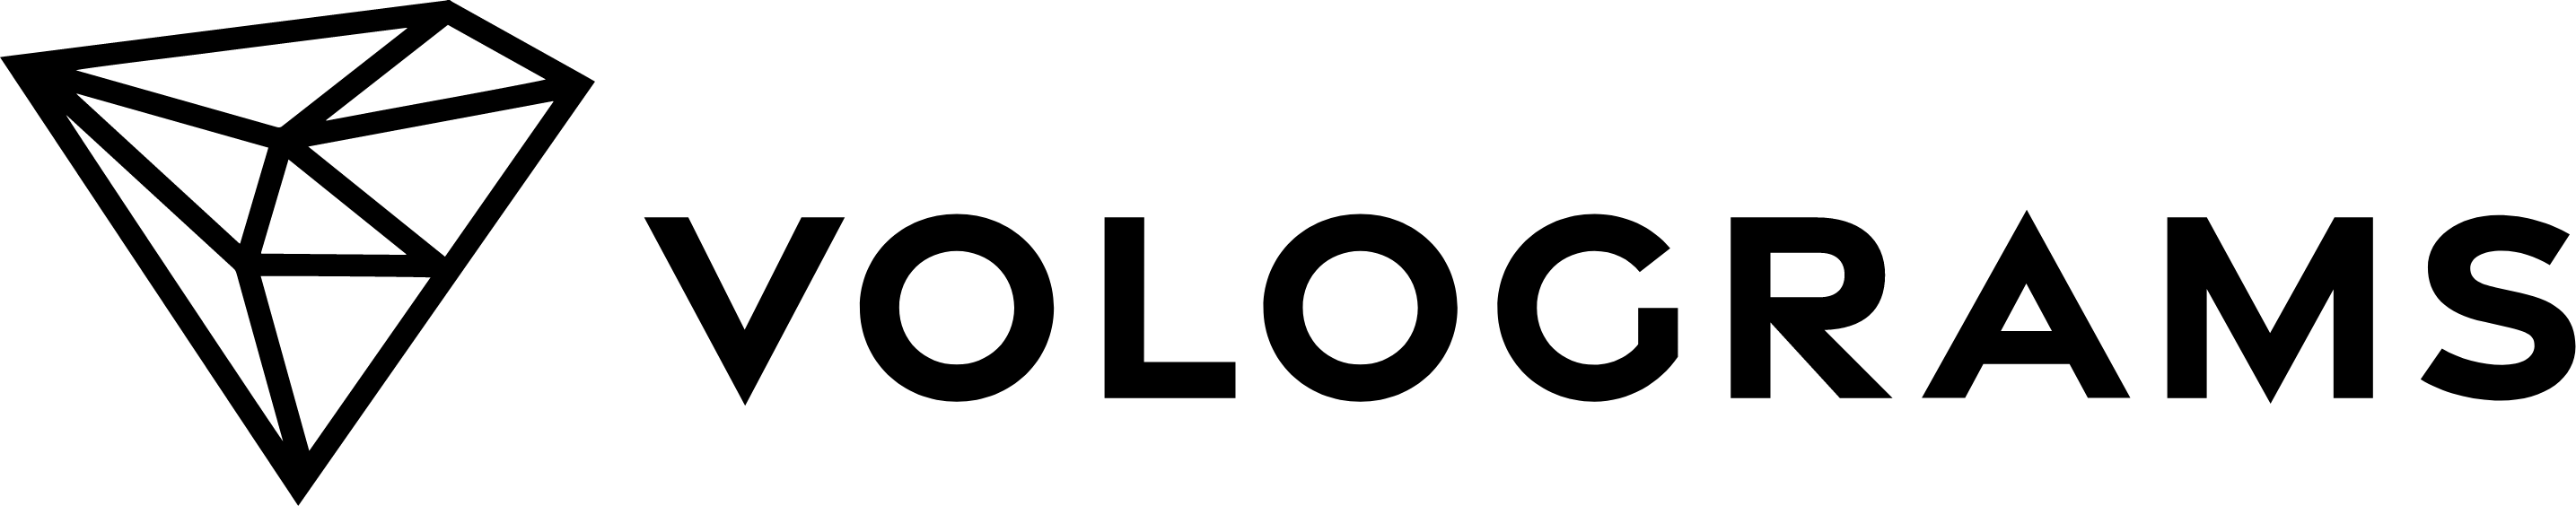

# Copyright (C) 2020-2021 Volograms Limited - All Rights Reserved

This file is part of VologramsAPI.

VologramsAPI can not be copied and/or distributed without the express
permission of Volograms Limited


<table align="left">
  <td>
    <a target="_blank" href="https://github.com/SaKi1309/VoloGAN/blob/master/VoloGAN_AdversarialDomainAdaptation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

<p> <big><u>Table of Contents</u></big></p>
<ul>
<li><a href="#0">0 - Initial Steps</a></li>
<li><a href="#1">1 - Environment</a></li>
<li><a href="#2">2 - Utilities and Helper Functions</a></li>
<li><a href="#3">3 - Data Preparation</a></li>
<li><a href="#4">4 - Model Definition</a></li>
<li><a href="#5">5 - Training the Model</a></li>
<li><a href="#6">6 - Validating the Model</a></li>
<li><a href="#7">7 - Run Inference and Generate Samples</a></li>
<li><a href="#A">A - Notes, Hints, Guides & Toturials</a></li>
</ul>

<a name="0"></a>
# 0 - Initial Steps

In [ ]:
!pip install tensorflow_addons

import tensorflow as tf         # Tensorflow framework
import numpy as np              # Tools for working with datastructures
import matplotlib.pyplot as plt # Plot data
import cv2                      # OpenCV for image processing
import tensorflow_addons as tfa # Aditional features for Tensorflow 
import seaborn as sns           # Visualize Data
import pandas as pd             # Organize datastructures
from tensorflow.keras.callbacks import TensorBoard

#import gc                       #garbage collector
import os
import io
import imageio
import random
import time
from zipfile import ZipFile
import json

#from tqdm import tqdm
from sklearn.decomposition import PCA

# Print package version of available packages
print("Tensorflow version: \t\t" + tf.__version__)
print("Numpy version: \t\t\t" + np.__version__)
print("Open CV version: \t\t" + cv2.__version__)
print("Tensorflow Ad-Ons version: \t" + tfa.__version__)
print("Seaborn version: \t\t" + sns.__version__)
print("Pandas version: \t\t" + pd.__version__)
!python --version
#!cat /etc/*-release

<a name="0-1"></a>
## 0.1 Distribution Strategy - HW Detection
Depending on the hardware available, different distribution strategies will be applied.

- If the TPU is available, the TPU Strategy is used.
Otherwise:
- If more than one GPU is available, then the Mirrored Strategy is applied
- If one GPU is available or if just the CPU is available, the default strategy is applied.

> Overview Distribution: https://www.tensorflow.org/api_docs/python/tf/distribute

> Tutorial of using td.distrubute on custom training: https://www.tensorflow.org/tutorials/distribute/custom_training

<table align="left">
  <td>
    
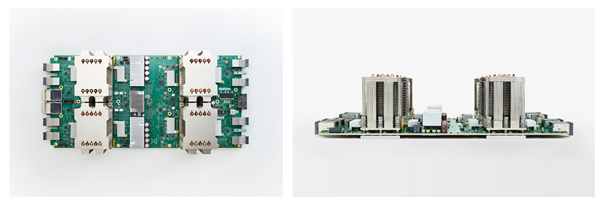
  </td>
  <td>
  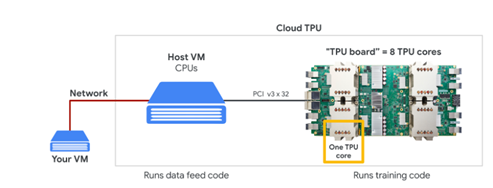
  </td>
</table>


In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  RUNTIME_ENVIRONMENT = "TPU"
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  RUNTIME_ENVIRONMENT = "GPU"
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  RUNTIME_ENVIRONMENT = "GPU"
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  RUNTIME_ENVIRONMENT = "CPU"
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

from tensorflow.python.client import device_lib
print("____________________________________________________________________________________")
print("Device List: ")
device_lib.list_local_devices()

<a name="0-2x"></a>
## 0.2 Notebook Settings
The following Parameters can be adapted to influence the behavior of the notebook.

In [ ]:
#@markdown <p align="center"> <big><u>General</u></big></p>
RUN_NOTE = "Final U-Net U-Net configuration..." #@param {type:"string"}
NOTEBOOK_ENVIRONMENT = 'Google_Colab' #@param ["Google_Colab", "Kaggle"]
SAVE_LOCATION = 'local' #@param ["local", "drive"]
#@markdown *(Determines wheter logfiles, models and checkpoints are stored locally or on google drive)*


#@markdown <br><p align="center"> <big><u>Model Architecture</u></big></p>
GENERATOR_DESIGN = 'UNet' #@param [ "ResNet", "UNet", "UNet_risidual_bottleneck","UNet_risidual_blocks"] 
DISCRIMINATOR_DESIGN = 'OneShot_GAN' #@param ["PatchGAN", "UNet", "OneShot_GAN"]

USE_BIAS_NODES = False #@param {type:"boolean"}
CONNECT_SKIPS = 'concat' #@param ["add", "concat"]
PIXEL_DISTANCE = 'per_channel' #@param ["per_channel", "per_image"]
SSIM_CALCULATION = 'per_channel' #@param ["per_channel", "per_image"]
NORMALIZE_DEPTH_CHANNEL = True #@param {type:"boolean"}
ADV_LOSS = 'mean_squared_error' #@param ["mean_squared_error", "binary_crossentropy","hinge"]
LAMBDA_CYCLE = 10.0 #@param {type:"raw"}
LAMBDA_IDENTITY =  0.5#@param {type:"raw"}
LAMBDA_SSIM =  1#@param {type:"raw"}
PADDING_TYPE = 'zero' #@param ["zero", "reflection"]
GLOBAL_ACTIVATION = 'leaky_relu' #@param ["relu", "leaky_relu","elu","prelu"]
GLOBAL_INITIALIZER = 'he_alpha_uniform' #@param ["random_normal", "random_uniform","glorot_normal", "glorot_uniform","he_normal","he_uniform","he_alpha_normal","he_alpha_uniform"]
USE_SPEC_NORM = True #@param {type:"boolean"}
USE_SELF_ATTENTION = False #@param {type:"boolean"}

#@markdown <br><p align="center"> <u>Generator Related Options</u></p>
GENERATOR_UP_DOWN_LEVELS = 5 #@param {type:"slider", min:1, max:10, step:1}
GENERATOR_CONV_FILTERS = 64 #@param [4, 8, 16, 32, 64, 128] {type:"raw"}
FIRST_GENERATOR_CONV_KERNEL = 3 #@param [3, 5, 7, 9] {type:"raw"}
GENERATOR_CONV_KERNELS = 3 #@param [3, 5, 7] {type:"raw"}
GENERATOR_NUM_CONVS_PER_BLOCK = 2 #@param [1, 2, 3] {type:"raw"}
GENERATOR_SPLIT_KERNELS = False #@param {type:"boolean"}
GENERATOR_UPSAMPLING = 'depth_to_space' #@param ["2D_upsample_and_conv", "transpose_conv", "depth_to_space", "bilinear_additive_residual"]
GENERATOR_DOWNSAMPLING = 'conv_stride_2' #@param ["max_pooling","average_pooling", "conv_stride_2", "space_to_depth"]
FINAL_GENERATOR_ACTIVATION = 'hard_sigmoid'  #@param ["sigmoid", "tanh","hard_sigmoid"]

#@markdown <br><p align="center"> <u>Discriminator Related Options</u></p>
DISCRIMINATOR_UP_DOWN_LEVELS = 3 #@param {type:"slider", min:1, max:10, step:1}
DISCRIMINATOR_CONV_FILTERS = 64 #@param [4, 8, 16, 32, 64, 128] {type:"raw"}
FIRST_DISCRIMINATOR_CONV_KERNEL = 3 #@param [3, 5, 7, 9] {type:"raw"}
DISCRIMINATOR_CONV_KERNELS = 3 #@param [3, 5, 7] {type:"raw"}
DISCRIMINATOR_NUM_CONVS_PER_BLOCK = 1 #@param [1, 2, 3] {type:"raw"}
DISCRIMINATOR_SPLIT_KERNELS = False #@param {type:"boolean"}
DISCRIMINATOR_UPSAMPLING = '2D_upsample_and_conv' #@param ["2D_upsample_and_conv", "transpose_conv", "depth_to_space","bilinear_additive_residual"]
DISCRIMINATOR_DOWNSAMPLING = 'average_pooling' #@param ["max_pooling","average_pooling", "conv_stride_2", "space_to_depth"]
DISCRIMINATOR_CUTMIX = False #@param {type:"boolean"}
CUTMIX_PROBABILITY = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

#@markdown <br><p align="center"> <big><u>Dataset</u></big></p>
COLOR_MODE = 'RGB' #@param [ "RGB", "Gray_Scale"]
HEIGHT_WIDTH = (64,64) #@param
CROP_TO_512_256 = False #@param {type:"boolean"}
DATASOURCE = 'generated_from_drive' #@param [ "cloud_bucket", "generated_from_drive"]
DATA_DIRECTORY_NAME = 'training_set_selected_2048_v1_64x64' #@param ['training_synthetic_995_real_XXX','training_set_real_2452_synthetic_10000','training_set_real_2452_synthetic_11477_v4_2','training_set_selected_2048_v1','training_set_selected_2048_v1_grayscale','training_set_selected_2048_v1_64x64'] {type:"string"}
DATASET_DATATYPE = 'float32' #@param ["float16", "float32"]
#@markdown > *Cloud Bucket Related Options:*
GCS_PATTERN = "gs://vologan_usa"  #@param ["gs://masterthesis-volograms-kirch","gs://vologan","gs://vologan_usa"] {type:"string"}
GCS_PROJECT_ID = 'vologan' #@param ['composite-shard-303117',"vologan"]{type:"string"}
#@markdown > *Generated from Drive Related Options:*
DATASET_STORAGE_SCHEME = 'loaded_to_RAM' #@param ["binary_stream_disk", "loaded_to_RAM"]
RECORDS_PER_FILE =  16#@param {type:"integer"} #8 per file (float32): 64Mbyte/file, 16 per file (float32): 128Mbyte/file
DOWNLOAD_GENERATED_FILES = False #@param {type:"boolean"}


#@markdown <br><p align="center"> <big><u>Training Prameter</u></big></p>
TRAINING_MODE = 'Training' #@param ["Training", "Hyperparameter_Tuning", "Inference"]
EPOCHS =  160#@param {type:"integer"}
WARM_UP_EPOCHS =  10#@param {type:"integer"}
LR_DECAY =  "cosine" #@param [ "none", "linear","cosine","exponential"]
GEN_OPTIMIZER = "nadam" #@param [ "adam", "sgd","nadam","swats_adam","swats_nadam"]
GEN_LEARNING_RATE = 3e-4 #@param ['1e-4','2e-4','3e-4','6e-4','1e-3'] {type:"raw"}
DISC_OPTIMIZER = "sgd" #@param [ "adam", "sgd","nadam","swats_adam","swats_nadam"]
DISC_LEARNING_RATE = 1e-4 #@param ['1e-4','2e-4','3e-4','6e-4','1e-3'] {type:"raw"}
USE_AMSGRAD = False #@param {type:"boolean"}
DROPOUT_RATE = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown batchsize of 128 is favorable due to TPU architecture (8cores * 128 batches = 1024samples!)
#@markdown the amount of samples per TPU must be dividable by 8 since there are 8 cores!!!
#@markdown good start for tpu is batch 1 and samples 480 and train_split 0,8
BATCH_SIZE_PER_REPLICA =  8#@param {type:"integer"}
NUM_SAMPLES_TO_LOAD =  2200 #@param [40, 80, 160, 480, 680, 960, 1360, 2000, 2200] {type:"raw"}
TRAIN_SPLIT = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
ADAPT_PIXEL_LOSS = False #@param {type:"boolean"}
TRAINING_START = 'Start from scratch' #@param ["Start from scratch", "Load checkpoint", "Load Model"]
CHECKPOINT_MODEL_FILEPATH = "checkpoint/<MODEL>/" #@param {type:"string"}
MODEL_FILEPATH = "/content/drive/MyDrive/Master/Volograms/Models/model_trained_1625124136_cropped_epochs80" #@param {type:"string"}

#@markdown <br><p align="center"> <big><u>Validation</u></big></p>
TRAINING_VALIDATION = True #@param {type:"boolean"}
VALIDATION_EPOCH_FREQUENCY =  5#@param {type:"integer"}
PLOT_PCA = False #@param {type:"boolean"}
PLOT_VALIDATION_IMAGES = True #@param {type:"boolean"}
PLOT_HISTOGRAM = False #@param {type:"boolean"}
TENSORBOARD_TRAINING = True #@param {type:"boolean"}
TENSORBOARD_MODEL_GRAPH = False #@param {type:"boolean"}
TENSORBOARD_PERFORMANCE_PROFILE = False #@param {type:"boolean"}
EPOCH_TO_PROFILE =  1#@param {type:"integer"} 

#@markdown <br><p align="center"> <big><u>Saving and Loading</u></big></p>
USE_CHECKPOINTS = False #@param {type:"boolean"}
CHECKPOINT_EPOCH_FREQUENCY =  3#@param {type:"integer"}
SAVE_MODELS = False #@param {type:"boolean"}

#@markdown <br><p align="center"> <big><u>Post Training</u></big></p>
RUN_INFERENCE = False #@param {type:"boolean"}


# Check Inputs:
#check sample count is dividable by 8 for TPU
TRAIN_COUNT = int(NUM_SAMPLES_TO_LOAD * TRAIN_SPLIT)
TEST_COUNT = int(round(NUM_SAMPLES_TO_LOAD * (1 - TRAIN_SPLIT)))
#assert TRAIN_COUNT % 8 == 0 and TEST_COUNT % 8 == 0, "Number of samples in either train or test set is not dividable by 8"

#Check that imgae size matches color_scheme
if COLOR_MODE == "Gray_Scale":
  IMG_SIZE = (HEIGHT_WIDTH[0],HEIGHT_WIDTH[1],2)
elif COLOR_MODE == "RGB":
  IMG_SIZE = (HEIGHT_WIDTH[0],HEIGHT_WIDTH[1],4)

assert not (NOTEBOOK_ENVIRONMENT=="Kaggle" and SAVE_LOCATION == "drive"), "Drive can only be accessed in read mode when using kaggle"
assert not (RUNTIME_ENVIRONMENT=="TPU" and (GEN_OPTIMIZER == "adam" or DISC_OPTIMIZER == "adam") and USE_AMSGRAD == True), "Amsgrad not supported on TPU"
assert not (RUNTIME_ENVIRONMENT=="TPU" and DATASET_STORAGE_SCHEME =="binary_stream_disk" and DATASOURCE != "cloud_bucket"), "Loading data as binary stream from disk is not supported with TPU."

<a name="1"></a>
# 1 - Environment

<a name="1-1"></a>
## 1.1 Mounting external Storage

Two different storages might be added to the notebook: Google Drive or Google Cloud Storage.

There is a different procedure in Google Colab and in Kaggle environment. 

Google Colab:
- Run the code cell bellow
- An authentification window appears asking for credentials.
- An authentification code must be copied and entered in colab

Kaggle:
- make directories in Google Drive sharable and insert the link in a latter code cell. Only works for downloading data but not for saving data! 
- Register your Cloud Storage in your Notebook Kaggle Environment.
- Credentials are stored permanently
- run the code cell bellow

In [ ]:
#Mounting Google Drive
if NOTEBOOK_ENVIRONMENT!="Kaggle" and (SAVE_LOCATION == "drive" or DATASOURCE == 'generated_from_drive' or TRAINING_START == "Load Model"):
  from google.colab import drive
  drive.mount('/content/drive')

#Mounting Google Cloud Storage
if DATASOURCE == 'cloud_bucket':
  if NOTEBOOK_ENVIRONMENT == 'Google_Colab':
    from google.colab import auth
    auth.authenticate_user()

    !gcloud config set project {GCS_PROJECT_ID}
    !gsutil ls
    !gsutil ls {GCS_PATTERN}
  else: #NOTEBOOK_ENVIRONMENT == 'Kaggle':
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)


<a name="1-2"></a>
## 1.2 Global Parameters

Following some global parameters used throughout the notebook. In contrast to the notebook settings, this parameters should not be changed.

> Mixed precission allows to set the preccisson of the processing hardware. In contrast to just setting the data to a certain type, where the processing hardware still is able tu run at other high precission, whenn setting the processing hardware to e.g. float16, float32 opperations are not working anymore! Hence the code must be adapted acordingly

> XLA acceleration can be used to compile a graph for executions in order to accelerate the computation. This is manly for CPU and GPU, since the TPU dous compile the code as standard setting. When active, it takes some time in the first epoch of training, to compile the code.

In [ ]:
#Seed is used to have comparability between runs while maintaining random behavior!
RANDOM_SEED = 10
random.seed(RANDOM_SEED)
np.random.seed(seed=RANDOM_SEED)

# The global batch size is the batch size per replica (1 in this case) times the number of replicas in the distribution strategy (In Colab: 8 for TPU, 1 for GPU and CPU).
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Used for the data pipline to feed the data to the network
BUFFER_SIZE = NUM_SAMPLES_TO_LOAD

# Determines whether the tensorboard is required or not
USE_TENSORBOARD = TENSORBOARD_TRAINING or PLOT_PCA or PLOT_VALIDATION_IMAGES or PLOT_HISTOGRAM or TENSORBOARD_MODEL_GRAPH or TENSORBOARD_PERFORMANCE_PROFILE or TRAINING_MODE == "Hyperparameter_Tuning"

#autotune function for parallelism.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Strategy for reducing the loss whan calculated over several replicas
REDUCTION_STRATEGY = tf.keras.losses.Reduction.NONE

# Name indication model architecture and timestamp. Can be used for saving unic progress. e.g. tensorboard or checkpoints
NAME = "{timestamp}_VoloGAN_{training_mode}".format(gen_design = GENERATOR_DESIGN, disc_design = DISCRIMINATOR_DESIGN, timestamp= int(time.time()), training_mode = TRAINING_MODE)

BASE_DRIVE_DIRECTORY = os.path.join("/content","drive","MyDrive","Master","Volograms")

if NOTEBOOK_ENVIRONMENT == "Google_Colab":
  BASE_VM_DIRECTORY = os.path.join("/content")
else: #NOTEBOOK_ENVIRONMENT == "Kaggle"
  BASE_VM_DIRECTORY = os.path.join("/kaggle","working")

if SAVE_LOCATION == 'drive':
  BASE_SAVE_DIRECTORY = BASE_DRIVE_DIRECTORY
else:
  BASE_SAVE_DIRECTORY = BASE_VM_DIRECTORY #local storage on VM

MIXED_PRECISION = False
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')



<a name="2"></a>
# 2 - Utilities and Helper Functions

<p> <big><u>Chapter Contents</u></big></p>
<ul>
<li><a href="#2-1">2.1 Visualization</a></li>
<li><a href="#2-2">2.2 Get Settings</a></li>
<li><a href="#2-3">2.3 Principal Component Analysis</a></li>
<li><a href="#2-4">2.4 CutMix</a></li>
<li><a href="#2-5">2.5 TFRecord Support</a></li>
<li><a href="#2-6">2.6 Loading Data Support</a></li>
</ul>

---

In this section helper and utility functions that are used throughout the notebook are implemented. The functions implemented here are indipendent and does not require previously defined classes etc. The helper functions that does, are implemented later in this notebook e.g. the helpers related with the model architecture that require custom classes.

Used dataformat after the data has been loaded:
>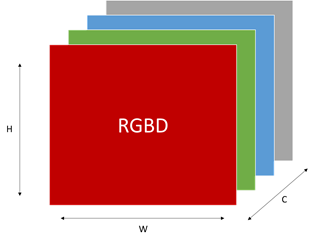

<table align="left" >
  <tr>
    <th>Param</th>
    <th>Value if COLOR_MODE == "RGB"</th>
    <th>Value if COLOR_MODE == "Gray_Scale"</th>
  </tr>
  <tr>
    <td>Hight</td>
    <td>512</td>
    <td>512</td>
  </tr>
  <tr>
    <td>Width</td>
    <td>512</td>
    <td>512</td>
  </tr>
  <tr>
    <td>Channel</td>
    <td>4</td>
    <td>2</td>
  </tr>
</table>

<a name="2-1"></a>
## 2.1 Visualization

Helper functions to plot image data in different representations e.g. image, histogram, pointcloud and to create an image file from a plot to be able to store images on TensorBoard.



Additional hints:

- matplotlib colormap refference: https://matplotlib.org/stable/gallery/color/colormap_reference.html
- Functions are implement to support all processing units (CPU, GPU and TPU)
- Note: plt.hist(tf.experimental.numpy.ravel(image),256,log=True,range =(0,1)) is not working on Keras TPU to make histograms, therfore a slightly more complicated solution is chosen.
- Matplotlib cannot plot float16 and therefore images must be casted to float32 before.



In [ ]:
def Plot_RGBD_Sample(rgbd,  title = "RGBD Plot"):
  ''' Plots the color channel and the depth channel of a single image seperatly including a histogram for each channel '''
  
  rgbd =  tf.cast(rgbd, tf.float32) # Matplotlib can not plot float16

  for i in range(rgbd.shape[2]):
    print("Dimension {0} - shape: {1} min: {2:.3f} max: {3:.3f} mean: {4:.3f} var: {5:.3f} std: {6:.3f} ".format(
        i,
        np.shape(rgbd[:,:,i]),
        np.min(rgbd[:,:,i]),
        np.max(rgbd[:,:,i]),
        np.mean(rgbd[:,:,i]),
        np.var(rgbd[:,:,i]),
        np.std(rgbd[:,:,i]))
    )

  fig = plt.figure()
  fig = plt.figure(figsize=[20,10])
  fig.suptitle(title, fontsize=20)
  
  ax = fig.add_subplot(2, 2, 1)

  if COLOR_MODE == "RGB":
    image = rgbd[:,:,0:3]
    imgplot = plt.imshow(image)
  else: # COLOR_MODE == "Gray_Scale"
    image = rgbd[:,:,0]
    imgplot = plt.imshow(image, cmap='gray', vmin=0, vmax=1)
  ax.set_title('Image (all channels)')

  ax = fig.add_subplot(2, 2, 2)
  hist = tf.histogram_fixed_width(image, [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  ax.plot(x_Range,hist)
  ax.set_yscale('log')
  ax.fill_between(x_Range, 0, hist)
  ax.set_title('Histogram Image (all channels)')
  
  ax = fig.add_subplot(2, 2, 3)
  depth = rgbd[:,:,-1]
  imgplot = plt.imshow(depth, cmap='nipy_spectral', vmin=0, vmax=1) #-1 -> last dimension!
  ax.set_title('Depth')
  #plt.colorbar()

  ax = fig.add_subplot(2, 2, 4)
  hist = tf.histogram_fixed_width(depth, [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  ax.plot(x_Range,hist)
  ax.set_yscale('log')
  ax.fill_between(x_Range, 0, hist)
  ax.set_title('Histogram Depth')

  plt.show()

def Plot_Multiple_RGBD(images, rows, columns, plot_title = "RGBD Plot", writeToTensorboard = False,log_dir = None, save_str = None, epoch = None):
  '''Plots two matricies of several images. First matrix contains color channel and second matrix the depth channel'''
  images_to_show = rows * columns
  images = tf.cast(images, tf.float32)
  #pad if not enough images ar requiured
  while images_to_show > len(images):
    padd_image = np.ones_like(images[0:1])
    images = np.append(images, padd_image, axis = 0 )
  final_image = np.concatenate([ np.concatenate([images[(a+b*columns),...] for a in range(columns)], axis = 1) for b in range(rows) ],axis = 0)
    
  fig = plt.figure()
  fig = plt.figure(figsize=[50,30])
  fig.suptitle(plot_title, fontsize=20)

  ax = fig.add_subplot(2, 1, 1)
  ax.set_title('Image (all channels)')
  ax.axis("off")
    
  if COLOR_MODE == "RGB":
    image = final_image[:,:,0:3]
    plt.imshow(image)
  else: # COLOR_MODE == "Gray_Scale"
    image = final_image[:,:,0]
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
  
  ax = fig.add_subplot(2, 1, 2)
  ax.set_title('Depth')
  ax.axis("off")
  depth = final_image[:,:,-1]
  plt.imshow(depth, cmap='nipy_spectral', vmin=0, vmax=1) #-1 -> last dimension!

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image(save_str, plot_to_image(fig), step= epoch)
  else:
    plt.show()

def Plot_RGBD_Seperatly(rgbd,  title = "RGBD Plot"):
  """plots each channel individually (including the color channels) and a histogram for each channel"""
  rgbd =  tf.cast(rgbd, tf.float32) # Matplotlib can not plot float16

  fig = plt.figure(figsize=[24,10])
  fig.suptitle(title, fontsize=20)

  ax = fig.add_subplot(2, 5, 1)
  imgplot = plt.imshow(rgbd[:,:,0:3])
  ax.set_title('RGB')

  hx = fig.add_subplot(2, 5, 6)
  hist = tf.histogram_fixed_width(rgbd[:,:,0:3], [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hx.plot(x_Range,hist)
  hx.set_yscale('log')
  hx.fill_between(x_Range, 0, hist)
  hx.set_title('Histogram RGB')

  ar = fig.add_subplot(2, 5, 2)
  imgplot = plt.imshow(rgbd[:,:,0], cmap='Reds')
  ar.set_title('Red')

  hr = fig.add_subplot(2, 5, 7, sharey=hx)
  hist = tf.histogram_fixed_width(rgbd[:,:,0], [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hr.plot(x_Range,hist)
  hr.set_yscale('log')
  hr.fill_between(x_Range, 0, hist)
  hr.set_title('Histogram Red')

  ag = fig.add_subplot(2, 5, 3)
  imgplot = plt.imshow(rgbd[:,:,1], cmap='Greens')
  ag.set_title('Green')

  hg = fig.add_subplot(2, 5, 8, sharey=hx)
  hist = tf.histogram_fixed_width(rgbd[:,:,1], [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hg.plot(x_Range,hist)
  hg.set_yscale('log')
  hg.fill_between(x_Range, 0, hist)
  hg.set_title('Histogram Green')

  ab = fig.add_subplot(2, 5, 4)
  imgplot = plt.imshow(rgbd[:,:,2], cmap='Blues')
  ab.set_title('Blue')

  hb = fig.add_subplot(2, 5, 9, sharey=hx)
  hist = tf.histogram_fixed_width(rgbd[:,:,2], [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hb.plot(x_Range,hist)
  hb.set_yscale('log')
  hb.fill_between(x_Range, 0, hist)
  hb.set_title('Histogram Blue')

  ad = fig.add_subplot(2, 5, 5)
  imgplot = plt.imshow(rgbd[:,:,3], cmap='nipy_spectral', vmin=0, vmax=1)
  ad.set_title('Depth')

  hd = fig.add_subplot(2, 5, 10, sharey=hx)
  hist = tf.histogram_fixed_width(rgbd[:,:,3], [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hd.plot(x_Range,hist)
  hd.set_yscale('log')
  hd.fill_between(x_Range, 0, hist)
  hd.set_title('Histogram Depth')

  plt.show()

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def Plot_generator_prediction(input, prediction, plot_title, writeToTensorboard = False, log_dir = None, save_str = None, epoch = None):
  '''Plots the output generated by a generator model'''
  #input_local = input.astype(np.float32) # input from dataset might be float16
    
  fig = plt.figure(figsize=[20,8])
  fig.suptitle(plot_title, fontsize=20)

  aix = fig.add_subplot(2, 4, 1)
  if COLOR_MODE == "RGB":
    input_image = input[:,:,0:3]
    imgplot = plt.imshow(input_image)
  else: # COLOR_MODE == "Gray_Scale"
    input_image = input[:,:,0]
    imgplot = plt.imshow(input_image, cmap='gray', vmin=0, vmax=1)
  aix.set_title('Input Image')
  aix.axis("off")

  aid = fig.add_subplot(2, 4, 2)
  input_depth = input[:,:,-1]
  imgplot = plt.imshow(input_depth, cmap='nipy_spectral', vmin=0, vmax=1)
  aid.set_title('Input Depth')
  aid.axis("off")

  aox = fig.add_subplot(2, 4, 3)
  if COLOR_MODE == "RGB":
    predicted_image = prediction[:,:,0:3]
    imgplot = plt.imshow(predicted_image)
  else: # COLOR_MODE == "Gray_Scale"
    predicted_image = prediction[:,:,0]
    imgplot = plt.imshow(predicted_image, cmap='gray', vmin=0, vmax=1)
  aox.set_title('Output Image')
  aox.axis("off")

  aod = fig.add_subplot(2, 4, 4)
  predicted_depth = prediction[:,:,-1]
  imgplot = plt.imshow(predicted_depth, cmap='nipy_spectral', vmin=0, vmax=1)
  aod.set_title('Output Depth')
  aod.axis("off")
  
  hix = fig.add_subplot(2, 4, 5)
  hist = tf.histogram_fixed_width(input_image, [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hix.plot(x_Range,hist)
  hix.set_yscale('log')
  hix.fill_between(x_Range, 0, hist)
  hix.set_title('Histogram Input Image')

  hid = fig.add_subplot(2, 4, 6, sharey=hix)
  hist = tf.histogram_fixed_width(input_depth, [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hid.plot(x_Range,hist)
  hid.set_yscale('log')
  hid.fill_between(x_Range, 0, hist)
  hid.set_title('Histogram Input Depth')

  hox = fig.add_subplot(2, 4, 7, sharey=hix)
  hist = tf.histogram_fixed_width(predicted_image, [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hox.plot(x_Range,hist)
  hox.set_yscale('log')
  hox.fill_between(x_Range, 0, hist)
  hox.set_title('Histogram Output Image')

  hod = fig.add_subplot(2, 4, 8, sharey=hix)
  hist = tf.histogram_fixed_width(predicted_depth, [0.0,1.0], nbins=256)
  x_Range = np.linspace(0,1,256)
  hod.plot(x_Range,hist)
  hod.set_yscale('log')
  hod.fill_between(x_Range, 0, hist)
  hod.set_title('Histogram Output Depth')

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image(save_str, plot_to_image(fig), step= epoch)
  else:
    plt.show()

    
def Plot_discriminator_prediction(input, prediction, plot_title, global_prediction = None, writeToTensorboard = False, log_dir = None, save_str = None, epoch = None):
  '''Plots the output generated by a discriminator model'''
  #input_local = input.astype(np.float32) # input from dataset might be float16
  
  fig = plt.figure(figsize=[12,6])
  fig.suptitle(plot_title, fontsize=20)
  ax = fig.add_subplot(1, 3, 1)
  
  if COLOR_MODE == "RGB":
    imgplot = plt.imshow(input[:,:,0:3])
  else: # COLOR_MODE == "Gray_Scale"
    imgplot = plt.imshow(input[:,:,0], cmap='gray', vmin=0, vmax=1)
  ax.set_title('Input Image')
  ax.axis("off")

  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(input[:,:,-1], cmap='nipy_spectral', vmin=0, vmax=1)
  ax.set_title('Input Depth')
  ax.axis("off")

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(prediction[0,...,-1], cmap='RdYlGn')
  if global_prediction:
    ax.set_title("Prediction: {}".format(global_prediction))
  else:
    ax.set_title('Prediction')
  
  ax.axis("off")
  plt.colorbar()

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image(save_str, plot_to_image(fig), step= epoch)
  else:
    plt.show()

def PlotPointCloud(RGBD, step, writeToTensorboard = False, log_dir = None, save_str = None, epoch = None, title = "Point Cloud"):
  ''' plots a 3D point cloud from a given RGBD or grayscale image'''

  def PointCloud(img, d, step, elevation, azimuth, color_channels, ax):
    ax.set_title('Elevation:{}° Azimuth:{}°'.format(elevation,azimuth))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, IMG_SIZE[0])
    ax.set_zlim(0, IMG_SIZE[1])

    for x in range(0, img.shape[0], step):
      for y in range(0, img.shape[1], step):
        if d[x,y] != 0:
          ax.scatter(
            d[x,y], y, x,
            c=[tuple(img[x, y, :color_channels])], s=color_channels)      
      ax.view_init(elevation, azimuth)

  if COLOR_MODE == "RGB":
    color_channels = 3
  elif COLOR_MODE == "Gray_Scale":
    color_channels = 1

  img = RGBD[:,:,0:color_channels]
  d = RGBD[:,:,-1]
  
  img = np.flipud(img)
  d = np.flipud(d)

  fig = plt.figure(figsize=(32,8))
  fig.suptitle(title + ", step size {}".format(step), fontsize=20)

  ax = fig.add_subplot(1, 4, 1,projection='3d')
  PointCloud(img, d, step, 20, -45, color_channels, ax)

  ax = fig.add_subplot(1, 4, 2,projection='3d')
  PointCloud(img, d, step, 20, 0, color_channels, ax)

  ax = fig.add_subplot(1, 4, 3,projection='3d')
  PointCloud(img, d, step, 90, 0, color_channels, ax)

  ax = fig.add_subplot(1, 4, 4,projection='3d')
  PointCloud(img, d, step, 20, 45, color_channels, ax)

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image(save_str, plot_to_image(fig), step= epoch)
  else:
    plt.show()

<a name="2-2"></a>
## 2.2 Get Settings


In [ ]:
def get_settings():
  '''Gets the values of all global parameters and returns it as formated string'''
  setting = ""
  setting += "Param | Value\n"
  setting += "--- | ---\n" 
  setting += "RUN_NOTE | {}\n".format(RUN_NOTE)
  setting += "NOTEBOOK_ENVIRONMENT | {}\n".format(NOTEBOOK_ENVIRONMENT)
  setting += "RUNTIME_ENVIRONMENT | {}\n".format(RUNTIME_ENVIRONMENT)
  setting += "SAVE_LOCATION | {}\n".format(SAVE_LOCATION)
  setting += "GENERATOR_DESIGN | {}\n".format(GENERATOR_DESIGN)
  setting += "DISCRIMINATOR_DESIGN | {}\n".format(DISCRIMINATOR_DESIGN)
  setting += "USE_BIAS_NODES | {}\n".format(USE_BIAS_NODES)
  setting += "CONNECT_SKIPS | {}\n".format(CONNECT_SKIPS)
  setting += "PIXEL_DISTANCE | {}\n".format(PIXEL_DISTANCE)
  setting += "SSIM_CALCULATION | {}\n".format(SSIM_CALCULATION)
  setting += "NORMALIZE_DEPTH_CHANNEL | {}\n".format(NORMALIZE_DEPTH_CHANNEL)
  setting += "ADV_LOSS | {}\n".format(ADV_LOSS)
  setting += "LAMBDA_CYCLE | {}\n".format(LAMBDA_CYCLE)
  setting += "LAMBDA_IDENTITY | {}\n".format(LAMBDA_IDENTITY)
  setting += "LAMBDA_SSIM | {}\n".format(LAMBDA_SSIM)
  setting += "PADDING_TYPE | {}\n".format(PADDING_TYPE)
  setting += "GLOBAL_ACTIVATION | {}\n".format(GLOBAL_ACTIVATION)
  setting += "GLOBAL_INITIALIZER | {}\n".format(GLOBAL_INITIALIZER)
  setting += "USE_SPEC_NORM | {}\n".format(USE_SPEC_NORM)
  setting += "USE_SELF_ATTENTION | {}\n".format(USE_SELF_ATTENTION)
  setting += "GENERATOR_UP_DOWN_LEVELS | {}\n".format(GENERATOR_UP_DOWN_LEVELS)
  setting += "GENERATOR_CONV_FILTERS | {}\n".format(GENERATOR_CONV_FILTERS)
  setting += "FIRST_GENERATOR_CONV_KERNEL | {}\n".format(FIRST_GENERATOR_CONV_KERNEL)
  setting += "GENERATOR_CONV_KERNELS | {}\n".format(GENERATOR_CONV_KERNELS)
  setting += "GENERATOR_NUM_CONVS_PER_BLOCK | {}\n".format(GENERATOR_NUM_CONVS_PER_BLOCK)
  setting += "GENERATOR_SPLIT_KERNELS | {}\n".format(GENERATOR_SPLIT_KERNELS)
  setting += "GENERATOR_UPSAMPLING | {}\n".format(GENERATOR_UPSAMPLING)
  setting += "GENERATOR_DOWNSAMPLING | {}\n".format(GENERATOR_DOWNSAMPLING) 
  setting += "FINAL_GENERATOR_ACTIVATION | {}\n".format(FINAL_GENERATOR_ACTIVATION)
  setting += "DISCRIMINATOR_UP_DOWN_LEVELS | {}\n".format(DISCRIMINATOR_UP_DOWN_LEVELS)
  setting += "DISCRIMINATOR_CONV_FILTERS | {}\n".format(DISCRIMINATOR_CONV_FILTERS)
  setting += "FIRST_DISCRIMINATOR_CONV_KERNEL | {}\n".format(FIRST_DISCRIMINATOR_CONV_KERNEL)
  setting += "DISCRIMINATOR_CONV_KERNELS | {}\n".format(DISCRIMINATOR_CONV_KERNELS)
  setting += "DISCRIMINATOR_NUM_CONVS_PER_BLOCK | {}\n".format(DISCRIMINATOR_NUM_CONVS_PER_BLOCK)
  setting += "DISCRIMINATOR_SPLIT_KERNELS | {}\n".format(DISCRIMINATOR_SPLIT_KERNELS)
  setting += "DISCRIMINATOR_UPSAMPLING | {}\n".format(DISCRIMINATOR_UPSAMPLING)
  setting += "DISCRIMINATOR_DOWNSAMPLING | {}\n".format(DISCRIMINATOR_DOWNSAMPLING)
  setting += "DISCRIMINATOR_CUTMIX | {}\n".format(DISCRIMINATOR_CUTMIX)
  setting += "CUTMIX_PROBABILITY | {}\n".format(CUTMIX_PROBABILITY)
  setting += "DATASOURCE | {}\n".format(DATASOURCE)
  setting += "COLOR_MODE | {}\n".format(COLOR_MODE)
  setting += "COLOR_MODE | {}\n".format(CROP_TO_512_256)
  setting += "DATASET_STORAGE_SCHEME | {}\n".format(DATASET_STORAGE_SCHEME)
  setting += "GCS_PATTERN | {}\n".format(GCS_PATTERN)
  setting += "GCS_PROJECT_ID | {}\n".format(GCS_PROJECT_ID)
  setting += "RECORDS_PER_FILE | {}\n".format(RECORDS_PER_FILE)
  setting += "DATA_DIRECTORY_NAME | {}\n".format(DATA_DIRECTORY_NAME)
  setting += "DATASET_DATATYPE | {}\n".format(DATASET_DATATYPE)
  setting += "DOWNLOAD_GENERATED_FILES | {}\n".format(DOWNLOAD_GENERATED_FILES)
  setting += "TRAINING_MODE | {}\n".format(TRAINING_MODE)
  setting += "EPOCHS | {}\n".format(EPOCHS)
  setting += "WARM_UP_EPOCHS | {}\n".format(WARM_UP_EPOCHS)
  setting += "LR_DECAY | {}\n".format(LR_DECAY)
  setting += "GEN_OPTIMIZER | {}\n".format(GEN_OPTIMIZER)
  setting += "GEN_LEARNING_RATE | {}\n".format(GEN_LEARNING_RATE)
  setting += "DISC_OPTIMIZER | {}\n".format(DISC_OPTIMIZER)
  setting += "DISC_LEARNING_RATE | {}\n".format(DISC_LEARNING_RATE)
  setting += "USE_AMSGRAD | {}\n".format(USE_AMSGRAD)
  setting += "DROPOUT_RATE | {}\n".format(DROPOUT_RATE)
  setting += "BATCH_SIZE_PER_REPLICA | {}\n".format(BATCH_SIZE_PER_REPLICA)
  setting += "NUM_SAMPLES_TO_LOAD | {}\n".format(NUM_SAMPLES_TO_LOAD)
  setting += "TRAIN_SPLIT | {}\n".format(TRAIN_SPLIT)
  setting += "ADAPT_PIXEL_LOSS | {}\n".format(ADAPT_PIXEL_LOSS)
  setting += "TRAINING_START | {}\n".format(TRAINING_START)
  setting += "CHECKPOINT_MODEL_FILEPATH | {}\n".format(CHECKPOINT_MODEL_FILEPATH)
  setting += "MODEL_FILEPATH | {}\n".format(MODEL_FILEPATH)
  setting += "TRAINING_VALIDATION | {}\n".format(TRAINING_VALIDATION)
  setting += "VALIDATION_EPOCH_FREQUENCY | {}\n".format(VALIDATION_EPOCH_FREQUENCY)
  setting += "PLOT_PCA | {}\n".format(PLOT_PCA)
  setting += "PLOT_VALIDATION_IMAGES | {}\n".format(PLOT_VALIDATION_IMAGES)
  setting += "PLOT_HISTOGRAM | {}\n".format(PLOT_HISTOGRAM)
  setting += "TENSORBOARD_TRAINING | {}\n".format(TENSORBOARD_TRAINING)
  setting += "TENSORBOARD_MODEL_GRAPH | {}\n".format(TENSORBOARD_MODEL_GRAPH)
  setting += "TENSORBOARD_PERFORMANCE_PROFILE | {}\n".format(TENSORBOARD_PERFORMANCE_PROFILE)
  setting += "EPOCH_TO_PROFILE | {}\n".format(EPOCH_TO_PROFILE)
  setting += "USE_CHECKPOINTS | {}\n".format(USE_CHECKPOINTS)
  setting += "CHECKPOINT_EPOCH_FREQUENCY | {}\n".format(CHECKPOINT_EPOCH_FREQUENCY)
  setting += "SAVE_MODELS | {}\n".format(SAVE_MODELS)
  setting += "RUN_INFERENCE | {}\n".format(RUN_INFERENCE)
  setting += "GLOBAL_BATCH_SIZE | {}\n".format(GLOBAL_BATCH_SIZE)
  setting += "BUFFER_SIZE | {}\n".format(BUFFER_SIZE)
  setting += "IMG_SIZE | {}\n".format(IMG_SIZE)
  setting += "AUTOTUNE | {}\n".format(AUTOTUNE)
  setting += "REDUCTION_STRATEGY | {}\n".format(REDUCTION_STRATEGY)
  setting += "NAME | {}\n".format(NAME)
  setting += "BASE_DRIVE_DIRECTORY | {}\n".format(BASE_DRIVE_DIRECTORY)
  setting += "BASE_VM_DIRECTORY | {}\n".format(BASE_VM_DIRECTORY)
  setting += "BASE_SAVE_DIRECTORY | {}\n".format(BASE_SAVE_DIRECTORY)
  return setting

<a name="2-3"></a>
## 2.3 Principal Component Analysis

Pricipal component analysis (PCA) is used to compare the distribution of the main features of a dataset (here an image). It is used to compare if the generated image has the same (or similar) statistics as a real image as a prove that the domain adaptation was successfull.

Important:
- first calculate PCA on each data, then combine! Reason: the main components for both inputs would change, eventhough only one dataset is changed!!!





In [ ]:
def Run_PCA(synthetic, target, dimension, mode, writeToTensorboard, log_dir = None, epoch = None, model_name = NAME):
  '''PCA calculation and plot on two different datasets for comparison'''
  pca = PCA(dimension)
  shape_synthetic = synthetic.shape
  num_samples_synthetic = shape_synthetic[0]
  flatten_length_synthetic = shape_synthetic[1] * shape_synthetic[2] * shape_synthetic[3]

  shape_target = target.shape
  num_samples_target = shape_target[0]
  flatten_length_target = shape_target[1] * shape_target[2] * shape_target[3]

  # reshape inputs
  temp1 = np.reshape(synthetic,(num_samples_synthetic,flatten_length_synthetic))
  temp2 = np.reshape(target,(num_samples_target,flatten_length_target))
  
  del synthetic, target

  projected1 = pca.fit_transform(temp1)
  projected2 = pca.fit_transform(temp2)
  del temp1, temp2

  df1 = pd.DataFrame(projected1)
  df1['domain'] = 'synthetic'
  df2 = pd.DataFrame(projected2)
  df2['domain'] = 'target'
  df12 = df1.append(df2)
  del projected1, projected2, df1, df2

  # plot data
  plt.ioff() # turn off automatic plot 
  g = sns.pairplot(data=df12, hue='domain')
  g.fig.suptitle("Principal Component Analysis.Samples:{}, Mode: {}, Color_Mode: {}".format(shape_synthetic[0],mode, COLOR_MODE), y=1.04) # y= some height>1
  g.map_diag(sns.kdeplot)
  
  g.add_legend()

  if writeToTensorboard:
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(log_dir).as_default():
        tf.summary.image("PCA", plot_to_image(g.fig), step= epoch)
  else:
    g

  #restore automatic plot!  
  plt.ion()
  # Free RAM memory (When run in method, garbage collection should take cake when scope left)
  del df12, g

def Run_PCA_on_dataset(dataset,  dimension = 5, mode = "image_depth", writeToTensorboard = False, log_dir = None, epoch = None):
  '''Runs PCA calculation depending on the mode selected'''
  if mode == "image_depth":
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)
  elif mode == "image":
    # swap dimensions of dataset and select every channel without depth
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,0:-1]
  elif mode == "depth":
    # swap dimensions of dataset and select depth channel only
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,-1:]
  else:
    print("Unvalid mode provided!")
    return

  del dataset

  Run_PCA(synthetic, target, dimension, mode, writeToTensorboard, log_dir = log_dir, epoch = epoch)

<a name="2-4"></a>
## 2.4 CutMix
Cutmix is a regularization technique, where two images are mixed, based on a randomly generated mask.

Inspired by: 
- U-Net based Discriminator: http://arxiv.org/abs/2002.12655  
- CutMix paper: http://arxiv.org/abs/1905.04899 

Hint on discriminator outputs:
- 0: Image is fake
- 1: Image is real

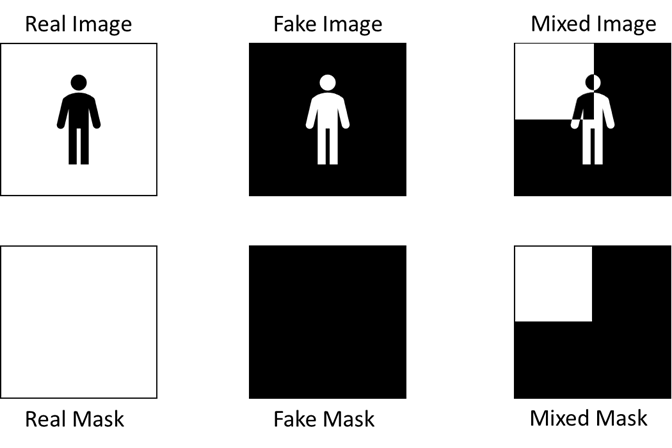

The CutMix implementation has been enhanced (can be selected optionally), to only mix regions were both images have non-background images. The reason is, that otherwise, the background of the fake image would be interpreted as fake by the discriminator, eventhough it would be correct in the real image, which would introduce an undesired bias.

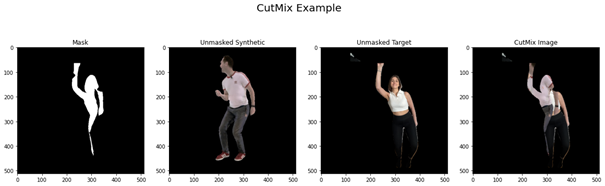

Ground truth MAsk:
0: fake (missing peaces from real image or content of fake image)
1: real

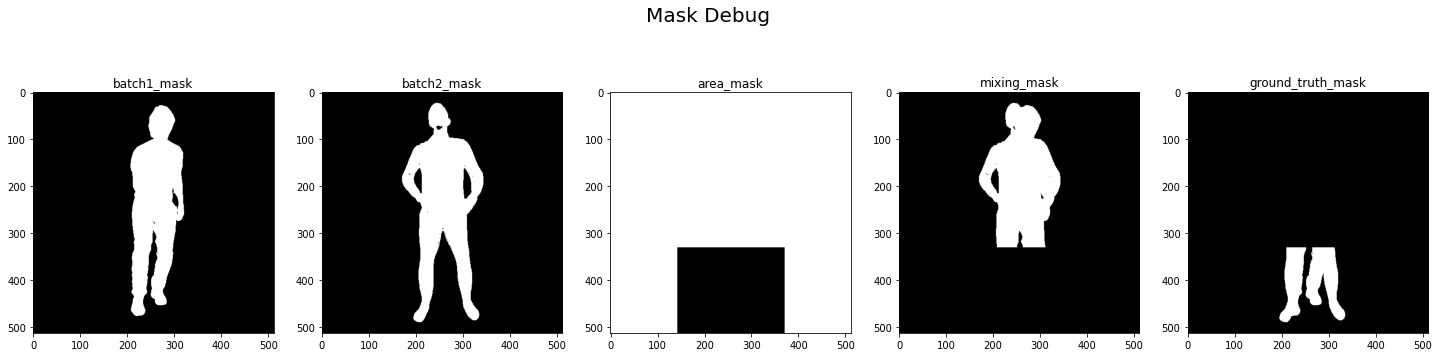

In [ ]:
def random_boundingbox(height, width, lam):
  '''Generates a random bounding box'''
  r = np.sqrt(1. - lam)
  w = np.int(width * r)
  h = np.int(height * r)
  x = np.random.randint(width)
  y = np.random.randint(height)

  x1 = np.clip(x - w // 2, 0, width)
  y1 = np.clip(y - h // 2, 0, height)
  x2 = np.clip(x + w // 2, 0, width)
  y2 = np.clip(y + h // 2, 0, height)

  return x1, y1, x2, y2

def GetCutmixMask(batch_size, height, width, channel):
  '''generates a mask for a given image dimensions'''
  mask = np.ones(shape=(batch_size, height, width, channel))
  for element in range(batch_size):
    lam = np.random.beta(1,1)
    x1, y1, x2, y2 = random_boundingbox(height, width, lam)
    mask[element, x1:x2,y1:y2,:]=0
  mask = tf.convert_to_tensor(mask, dtype=tf.float32)
  return mask

def CutMix(batch1, batch2, ignoreBackground,invertGroundTruth = False, mixing_mask = None):
  '''performs the cutmix operation of two image batches'''
  
  batch1 = tf.cast(batch1,tf.float32)
  batch2 = tf.cast(batch2,tf.float32)
  
  if mixing_mask == None: # generate mask
    batch_size, height, width, channel = batch1.shape
    mixing_mask = GetCutmixMask(batch_size, height, width, channel)
    
  if ignoreBackground: #check where in image are no background pixels (value = 1)
    batch1_mask = tf.cast(tf.where(batch1 > 0 ,1 , 0), tf.int32)
    batch2_mask = tf.cast(tf.where(batch2 > 0 ,1 , 0), tf.int32)
    mutal_person_mask = tf.cast(tf.clip_by_value((batch1_mask + batch2_mask),0,1), tf.float32)    
    ground_truth_mask = (1-(1-mixing_mask) * mutal_person_mask)

  else:
    ground_truth_mask = mixing_mask

  if invertGroundTruth:
      ground_truth_mask = 1 - ground_truth_mask

  new_batch = batch1*ground_truth_mask + batch2*(1-ground_truth_mask)

  return ground_truth_mask, new_batch

    
def GetImageAndMask(batch1, batch2, cutmix = True, probability = 0.5, ignoreBackground = True, mixing_mask = None, invertGroundTruth=False):
  '''Initiates the CutMix operation acc. to a certain probability, otherwise the same batch is retaurn with an all-true mask'''
  if cutmix and np.random.uniform(0,1) < probability:
    return CutMix(batch1, batch2,ignoreBackground, invertGroundTruth, mixing_mask)
  else:
    if invertGroundTruth:
      ground_truth_mask = tf.zeros_like(batch1)
      OneZeroRatio = 0
    else:
      ground_truth_mask = tf.ones_like(batch1)
      OneZeroRatio = 1
    new_batch = batch1
    return [ground_truth_mask, OneZeroRatio], new_batch



<a name="2-5"></a>
## 2.5 TFRecord Support

TFRecords is a special datatype that allows implementing binary streams of data from hard disk to RAM. Since the data is transmitted as raw binary stream, data must be converted to a binary stream and vice-versa to reconstruct the data after reading. In addition, the TFRecord files must be written.

In [ ]:
 # Create a dictionary describing the features.
IMAGE_FEATURE_DESCRIPTION = {
  'synthetic_image': tf.io.FixedLenFeature([], tf.string),
  'target_image': tf.io.FixedLenFeature([], tf.string)
}

def bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def float_featureArray(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(syntheticSample, targetSample):
  feature = {
    'synthetic_image': bytes_feature(syntheticSample.tobytes()),
    'target_image': bytes_feature(targetSample.tobytes())
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

def WriteTFRecord(synthetic_combined, real_combined, save_directory, fileNumber):
  """ Writes a TFRecord file containing one or multiple training examples """
  with tf.io.TFRecordWriter(save_directory + 'rgbd_batch-{0:08d}.tfrecords'.format(fileNumber)) as writer:
    for sample in zip(synthetic_combined, real_combined):
      tf_example = image_example(sample[0], sample[1])
      writer.write(tf_example.SerializeToString())

def parse_and_decode(example_proto):

  dtype = np.dtype(DATASET_DATATYPE)

  example = tf.io.parse_single_example(example_proto, IMAGE_FEATURE_DESCRIPTION)
  synthetic_image_raw = example['synthetic_image']
  target_image_raw = example['target_image']
 
  synthetic_image = tf.io.decode_raw(synthetic_image_raw, out_type = dtype)
  synthetic_image = tf.reshape(synthetic_image, IMG_SIZE)
 
  target_image = tf.io.decode_raw(target_image_raw, out_type = dtype)
  target_image = tf.reshape(target_image, IMG_SIZE)
 
  return synthetic_image, target_image

def CropVolos(synthetic_image, target_image):

  synthetic_image = tf.image.crop_to_bounding_box(image = synthetic_image, 
                                            offset_height = 0, 
                                            offset_width = 128, 
                                            target_height = 512, 
                                            target_width = 256)
  target_image = tf.image.crop_to_bounding_box(image = target_image, 
                                            offset_height = 0, 
                                            offset_width = 128, 
                                            target_height = 512, 
                                            target_width = 256)
  return synthetic_image, target_image

<a name="2-6"></a>
## 2.6 Loading Data Support

In this section, helper functions to support loading data from several sources are provided. 

When loading data into RAM, color-channel and depth channel are loaded individually using a JSON file containing the file locations and are then scaled and combined.



Note:
- Copying zip-file from Drive to VM as whole and then unzip is way faster then loading image by image!

The content of the json file has to following format:


```json
{
  "synthetic_data": [
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.exr",
       "color_path": "RENDER/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.jpg"
    },
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.jpg"
    }
    ...
  ],
  "real_data": [
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dave/2019_09_Optum_Dave_Frame_00515/62_0_00.jpg"
    },
    {
      "depth_path": "DEPTH_EXR/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.exr",
      "color_path": "RENDER/2019_09_Optum_Dominic/2019_09_Optum_Dominic_Frame_00915/272_0_00.jpg"
    }
    ...
  ]
}
```



In [ ]:
def read_json_file(directoryName):
  #Defeine paths
  unzipDirectory = os.path.join(BASE_VM_DIRECTORY, directoryName)
  jsonConfigFile = os.path.join(unzipDirectory, "training_paths.json")

  #Unzip data
  if os.path.isdir(unzipDirectory):
    print("Data already unzipped.")
  else: #Download and unzip
    if NOTEBOOK_ENVIRONMENT == "Google_Colab":
      zipFile = os.path.join(BASE_DRIVE_DIRECTORY, "Datasets", directoryName+".zip")
    else: #NOTEBOOK_ENVIRONMENT == "Kaggle"
      !pip install gdown
      import gdown

      if directoryName == "training_set_real_2452_synthetic_10000":
        url = 'https://drive.google.com/uc?id=1Brj6EvvSvjQSOKdqhCUonn2TptUtEBrJ'
      elif directoryName == "training_set_real_2452_synthetic_11477_v4_2":
        url = 'https://drive.google.com/uc?id=18x9_1kPW-aKoMvzDG7p9AKGV_aOW4kZk'  
      elif directoryName == "training_set_selected_2048_v1":
        url = 'https://drive.google.com/uc?id=1h8OfH74sHexOZOxjQly6wQQNDClW-yu-'
      elif directoryName == "training_set_selected_2048_v1_64x64":
        url = 'https://drive.google.com/uc?id=1XcsBqthLHmMPCGRUExhML0VdE-iye0jI'
      else: 
        raise Exception("Unknown File! Need sharable Link to Google Drive!")
      
      zipFile = '{}/{}.zip'.format(BASE_VM_DIRECTORY,directoryName)
      gdown.download(url, zipFile, quiet=False)
    with ZipFile(zipFile, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      print('Start Unzipping file {} to {}'.format(zipFile, unzipDirectory)) 
      zipObj.extractall(unzipDirectory)
      print('Finnished unzipping')

  # Read json config file
  print("Read config file...")
  with open(jsonConfigFile) as f:
    data = json.load(f)
  return data

**Note**:
- numpy is super memory expensive, since with every operation a copy of the object is created. In addition, the standard format of numbers (float or int) is using 64 bit, which also requires a lot of memory. For that reason, the code cell bellow is optimized slightly to have less memory footprint.

**Data scaling**:
- a simple min-max scaling ($x' = \frac{x - x_{min}}{x_{max}-x_{min}}$) is applied, to scale the data to values between 0 and 1. 

- color channel: $RGB' = \frac{RGB - min(uint8)}{max(uint8)-min(uint8)} = \frac{RGB}{255}$

- depth channel: $Depth' = \frac{Depth - min(Depth)}{max(Depth)-min(Depth)} = \frac{Depth + 1}{2}$

**Info:**
- Normalizing vs. standardization vs scaling:
https://developers.google.com/machine-learning/data-prep/transform/normalization





In [ ]:
def Read_and_Combine_RGBD_to_TFRecord(data_dict, target_directory, NumberOfSamplesToRead):
  save_directory = "TFRecord_Files/"
  numberOfSamples_syntethic = len(data_dict["synthetic_data"])
  numberOfSamples_real = len(data_dict["real_data"])

  print("Identified {} synthetic samples and {} real samples".format(numberOfSamples_syntethic, numberOfSamples_real))

  #randomize Filenames!
  random.shuffle(data_dict["synthetic_data"])
  random.shuffle(data_dict["real_data"])

  if NumberOfSamplesToRead:
    # incase more samples are requested as there are available
    samples_to_read = min(numberOfSamples_syntethic, numberOfSamples_real , NumberOfSamplesToRead)
    if NumberOfSamplesToRead > samples_to_read:
      print("More samples requested than available. {} will be read instead of {}".format(samples_to_read, NumberOfSamplesToRead))
  else:
    samples_to_read =  min(numberOfSamples_syntethic, numberOfSamples_real) 
  
  print("Total Samples to read: {}".format(samples_to_read))
  #empty array container
  synthetic_combined = []
  real_combined = []

  fileNumber = 0

  for i, sample in enumerate(zip(data_dict["synthetic_data"], data_dict["real_data"])):
    synthetic_sample = sample[0]
    real_sample = sample[1]

    if COLOR_MODE == "RGB":
      synthetic_image = cv2.imread(os.path.join(target_directory, synthetic_sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
      real_image = cv2.imread(os.path.join(target_directory, real_sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
    else: # COLOR_MODE == "Gray_Scale"
      synthetic_image = cv2.imread(os.path.join(target_directory, synthetic_sample["color_path"]), 0) # read Gray Scale
      real_image = cv2.imread(os.path.join(target_directory, real_sample["color_path"]), 0) # read Gray Scale
    
    synthetic_depth = cv2.imread(os.path.join(target_directory, synthetic_sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
    real_depth = cv2.imread(os.path.join(target_directory, real_sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
    
    synthetic_image = synthetic_image / 255
    synthetic_depth = (synthetic_depth + 1)/2
    real_image = real_image / 255
    real_depth = (real_depth + 1)/2

    if COLOR_MODE == "RGB":
      synthetic_combined.append(np.concatenate((synthetic_image , np.expand_dims(synthetic_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64
      real_combined.append(np.concatenate((real_image , np.expand_dims(real_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64
    else: # COLOR_MODE == "Gray_Scale"
      synthetic_combined.append(np.concatenate((np.expand_dims(synthetic_image, axis = 2) , np.expand_dims(synthetic_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64
      real_combined.append(np.concatenate((np.expand_dims(real_image, axis = 2) , np.expand_dims(real_depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))#saved as float32, since after division with 255, datatype is float64

    print(".", end = "")

    if (i+1) % 100 == 0:
      print (" - Images processed: {}".format(i+1))

    if (i+1) == samples_to_read:
      WriteTFRecord(synthetic_combined, real_combined, save_directory, fileNumber)
      synthetic_combined = []
      real_combined = []
      print (" - Images processed: {}, Files created: {}".format((i+1),(fileNumber+1)))
      break

    if ((i+1) % RECORDS_PER_FILE) == 0:
      WriteTFRecord(synthetic_combined, real_combined, save_directory, fileNumber)
      synthetic_combined = []
      real_combined = []
      fileNumber += 1

def Read_and_Combine_RGBD_to_RAM(data_dict, target_directory, NumberOfSamplesToRead , info_str = ""):
  numberOfSamples = len(data_dict)

  #randomize Filenames!
  random.shuffle(data_dict)

  if NumberOfSamplesToRead:
    # incase more samples are requested as there are available
    readCount = min(numberOfSamples, NumberOfSamplesToRead)
  else:
    readCount = numberOfSamples  

  #empty array container
  combined = []

  print("Identified {} samples of {}".format(numberOfSamples, info_str))
  if readCount > 0:
    print("Start reading {} of {} samples of {} ...".format(readCount,numberOfSamples, info_str))
    for i, sample in enumerate(data_dict):

      #print(sample)
      if COLOR_MODE == "RGB":
        image = cv2.imread(os.path.join(target_directory, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!! dtype uint8
      else: # COLOR_MODE == "Gray_Scale"
        image = cv2.imread(os.path.join(target_directory, sample["color_path"]),0) # read Gray Scale

      depth = cv2.imread(os.path.join(target_directory, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) # dtype float32
      
      if i == 0:
        print("Datatype of images: {}".format(image.dtype))
        print("Datatype of depths: {}".format(depth.dtype))
      
      image = image / 255
      depth = (depth + 1)/2

      if COLOR_MODE == "RGB":
        combined.append(np.concatenate((image , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE))) #saved as float32, since after division with 255, datatype is float64
      else: # COLOR_MODE == "Gray_Scale"
        combined.append(np.concatenate((np.expand_dims(image, axis = 2) , np.expand_dims(depth, axis = 2)), axis = 2).astype(np.dtype(DATASET_DATATYPE)))

      print(".", end = "")
      if (i+1) % 100 == 0:
        print (" - Images processed: {}".format(i+1))

      if (i+1) == readCount:
        break

    print("\nShape of combined images and depths: {}, where (Sample, Height, Width, Channel)".format(np.shape(combined)))

  else:
    print("No data will be read.")

  return np.array(combined, dtype = np.dtype(DATASET_DATATYPE))

In [ ]:
# Folder must be located at "/content/drive/My Drive/Master/DatasetVolograms"+directoryName+".zip"
def Load_and_Combine_Training_Samples(directoryName, NumberOfSamplesToRead = None):
  data_dict = read_json_file(directoryName)
  target_directory = os.path.join(BASE_VM_DIRECTORY, directoryName)

  if DATASET_STORAGE_SCHEME == 'binary_stream_disk':
    
    !rm -rf $BASE_VM_DIRECTORY/TFRecord_Files/
    os.makedirs("{}/TFRecord_Files".format(BASE_VM_DIRECTORY))
    
    Read_and_Combine_RGBD_to_TFRecord(data_dict, target_directory, NumberOfSamplesToRead)
    
    print("\n")
    print("Training Files:")
    !ls $BASE_VM_DIRECTORY/TFRecord_Files
    print("\n")
    print("Memory usage of TFRecord dataset files:")
    !du -sh $BASE_VM_DIRECTORY/TFRecord_Files

    if DOWNLOAD_GENERATED_FILES:
      !zip -r $BASE_VM_DIRECTORY/TFRecord_Files.zip $BASE_VM_DIRECTORY/TFRecord_Files
      if NOTEBOOK_ENVIRONMENT == 'Google_Colab':
        from google.colab import files
        files.download("{}/TFRecord_Files.zip".format(BASE_VM_DIRECTORY))
  else:
    rgbd_synthetic = Read_and_Combine_RGBD_to_RAM(data_dict['synthetic_data'], target_directory, NumberOfSamplesToRead, "synthetic data")
    rgbd_real = Read_and_Combine_RGBD_to_RAM(data_dict['real_data'], target_directory, NumberOfSamplesToRead, "real data")
    return rgbd_synthetic, rgbd_real


<a name="3"></a>
# 3 - Data Preparation

<p> <big><u>Chapter Contents</u></big></p>
<ul>
<li><a href="#3-1">3.1 Define Data Augmentation</a></li>
<li><a href="#3-2">3.2 Define Dataset Pipeline</a></li>
<li><a href="#3-3">3.3 Load Data</a></li>
<li><a href="#3-4">3.4 Analyze Data</a></li>
</ul>

<a name="3-1"></a>
## 3.1 Define Data Augmentation

In this section, data augmentation techniques are implemented that are later applied on the training set. The test data is not augmented. In addition, scaling is done before training to save computation resources and accelerate training.



**Randomly flipp left-right**: 

>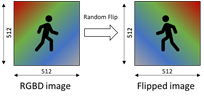

**Shift Image augmentation**:

>Zero padding is working to shift the image, since all pixels except of the person in the center are zero
> 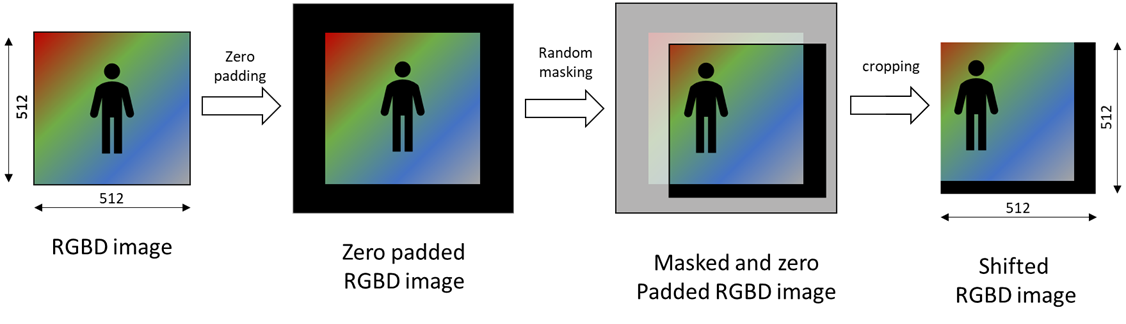


In [ ]:
HEIGHT_WIDTH

def Shift_image(img):
  img = tf.image.pad_to_bounding_box(image = img, offset_height = 0, offset_width = 0, target_height = (HEIGHT_WIDTH[0] + int(HEIGHT_WIDTH[0]*0.1)), target_width = (HEIGHT_WIDTH[1] + int(HEIGHT_WIDTH[1]*0.4)))
  img = tf.image.random_crop(value = img, size = [GLOBAL_BATCH_SIZE] +  list(IMG_SIZE),seed=RANDOM_SEED)
  return img

def Augmentate_Data(synthetic_rgbd, target_rgbd):
  # is already random
  synthetic_rgbd = tf.image.random_flip_left_right(synthetic_rgbd,seed=RANDOM_SEED)
  target_rgbd = tf.image.random_flip_left_right(target_rgbd,seed=RANDOM_SEED)
  
  # 0nly apply in roughly 20% of the cases 
  if not CROP_TO_512_256:
    if np.random.uniform(0,1) < 0.2:
      synthetic_rgbd = Shift_image(synthetic_rgbd)

    if np.random.uniform(0,1) < 0.2:
      target_rgbd = Shift_image(target_rgbd)

  return synthetic_rgbd, target_rgbd

@tf.function
def Preprocess_Train_Data(synthetic_rgbd, target_rgbd):
  synthetic_rgbd, target_rgbd = Augmentate_Data(synthetic_rgbd, target_rgbd)
  return synthetic_rgbd, target_rgbd

<a name="3-2"></a>
## 3.2 Define Dataset Pipeline

When training on the TPU, synchronous data paralism is applied. In data parallel training, the same model is distributed among multiple devices. Each device is trained on a subset of the training batch. The loss of all devices is reduced by for example adding them or averaging them, depending on the loss function used. Finally, the gradients are calculated, and the model is updated on all devices. In that scenario, a single thread of the client can drive the training loop, while bulk of the model computation is distributed among several devices.

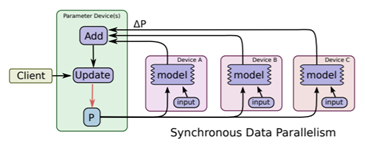

**Best practice summary**

Here is a summary of the best practices for designing performant TensorFlow input pipelines:

- Use the prefetch transformation to overlap the work of a producer and consumer
- Parallelize the data reading transformation using the interleave transformation
- Parallelize the map transformation by setting the num_parallel_calls argument
- Use the cache transformation to cache data in memory during the first epoch
- Vectorize user-defined functions passed in to the map transformation
- Reduce memory usage when applying the interleave, prefetch, and shuffle transformations



In [ ]:
def Create_tensorflow_dataset(data, trainSplit = 0.8):
  assert trainSplit <= 1.0 and trainSplit >=0 , "trainSplit needs to be a float between 0...1"
 
  numberOfSamples = data.shape[0]  
  train_size = int(trainSplit * numberOfSamples)
  train = tf.data.Dataset.from_tensor_slices(data[:train_size,...])
  test = tf.data.Dataset.from_tensor_slices(data[train_size:,...])
  print("\nDataset created. Total samples: {}, training split: {}, training samples: {}, test samples: {}".format(numberOfSamples, trainSplit, train_size, numberOfSamples-train_size))
  return [train, test]

def load_dataset(fileNames):
  ignore_order = tf.data.Options()
  ignore_order.experimental_deterministic = False  # disable order, increase speed
  
  dataset = tf.data.Dataset.from_tensor_slices(fileNames)
  dataset = dataset.with_options(ignore_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTOTUNE)
  
  dataset = dataset.map(parse_and_decode, num_parallel_calls=AUTOTUNE) #Dataset of synthetic_image, target_image
  
  if CROP_TO_512_256:
    dataset = dataset.map(CropVolos, num_parallel_calls=AUTOTUNE)

  return dataset

def get_RAM_datasets(rgbd_synthetic, rgbd_target):
  #Create Tensorflow Datasets for the synthetic and the target data and split them into training and test sets. 
  train_synthetic, test_synthetic = Create_tensorflow_dataset(rgbd_synthetic, trainSplit = TRAIN_SPLIT)
  del rgbd_synthetic
  train_target, test_target = Create_tensorflow_dataset(rgbd_target, trainSplit = TRAIN_SPLIT)
  del rgbd_target

  #create a single train set and a single test set from the synthetic and the target data. IMPORTANT: Shapes need to match
  train = tf.data.Dataset.zip((train_synthetic, train_target))
  del train_synthetic, train_target

  test = tf.data.Dataset.zip((test_synthetic, test_target))
  del test_synthetic, test_target

  #test = test.map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)

  return train, test
 
def get_TFRecord_datasets(filenames, num_samples_to_load, train_split):

  files_to_load = min(int(num_samples_to_load / RECORDS_PER_FILE), len(filenames))
  random.shuffle(filenames)
  train_size = int(files_to_load * TRAIN_SPLIT)
  trainFiles = filenames[:train_size]
  testFiles = filenames[train_size:files_to_load]
  train = load_dataset(trainFiles)
  test = load_dataset(testFiles)

  return train, test
 
def get_distributed_datasets(train, test):
  
  train = (
    train
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=True) #first batch then apply further functions to vectorize operations! 
    .map(Preprocess_Train_Data, num_parallel_calls=AUTOTUNE)
    #.shuffle(BUFFER_SIZE,seed=RANDOM_SEED) #shuffle requires memory and shuffeling a batch of 1 does not makes sense!!! In addition I shuffle filenames before loading! 
    .prefetch(AUTOTUNE)
  )
 
  test = (
    test
    .batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTOTUNE)
  )
 
  train_distributed = strategy.experimental_distribute_dataset(train)
  test_distributed = strategy.experimental_distribute_dataset(test)
  del train, test
 
  return train_distributed, test_distributed

<a name="3-3"></a>
## 3.3 Load Data

In [ ]:
#Generate TFRecords if configured 
if DATASOURCE == "generated_from_drive":
  if DATASET_STORAGE_SCHEME == 'binary_stream_disk':
    Load_and_Combine_Training_Samples(DATA_DIRECTORY_NAME, NUM_SAMPLES_TO_LOAD)
    FILENAMES = tf.io.gfile.glob("{}/TFRecord_Files/*.tfrecords".format(BASE_VM_DIRECTORY))
    trainDataset, testDataset = get_TFRecord_datasets(FILENAMES, NUM_SAMPLES_TO_LOAD, TRAIN_SPLIT)
 
  else: # DATASET_STORAGE_SCHEME == loaded_to_RAM
    rgbd_synthetic, rgbd_target = Load_and_Combine_Training_Samples(DATA_DIRECTORY_NAME, NUM_SAMPLES_TO_LOAD)
    #create Dataset
    trainDataset, testDataset = get_RAM_datasets(rgbd_synthetic, rgbd_target)
    # free up RAM
    del rgbd_synthetic, rgbd_target

else: # DATASOURCE == "cloud_bucket"
  FILENAMES = tf.io.gfile.glob("{}/{}/*.tfrecords".format(GCS_PATTERN, DATA_DIRECTORY_NAME))
  trainDataset, testDataset = get_TFRecord_datasets(FILENAMES, NUM_SAMPLES_TO_LOAD, TRAIN_SPLIT)
  if CROP_TO_512_256:
    global IMG_SIZE
    IMG_SIZE = (IMG_SIZE[0], 256, IMG_SIZE[2])

print("DATASOURCE: {}".format(DATASOURCE))
print("DATASET_STORAGE_SCHEME: {}".format(DATASET_STORAGE_SCHEME))
print(trainDataset)

<a name="3-4"></a>
## 3.4 Analyze Data

In this section, data can be optionally analyzed, by selecting the checkbox "Run_Cell"

In [ ]:
#@markdown ### PCA - Principal Component Analysis
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(trainDataset.shuffle(BUFFER_SIZE).take(-1).as_numpy_iterator()) # get all samples of the dataset
  Run_PCA_on_dataset(dataset, dimension = 5, mode = "image_depth")
  #Run_PCA_on_dataset(dataset, dimension = 5, mode = "image")
  #Run_PCA_on_dataset(dataset, dimension = 5, mode = "depth")

In [ ]:
#@markdown ### Plot Point Cloud
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(trainDataset.shuffle(BUFFER_SIZE).take(1).as_numpy_iterator()) # get 1 sample of the dataset
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  PlotPointCloud(rgbd_target[0,...], step = 1, title = "Point Cloud rgbd_target")

  PlotPointCloud(rgbd_synthetic[0,...], step = 1, title = "Point Cloud rgbd_synthetic")
  

  

In [ ]:
#@markdown ### Plot Image Example
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:

  dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
  #dataset = list(testDataset.take(10).as_numpy_iterator()) # get 1 sample of the dataset
  print(np.shape(dataset))

  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  #Inspect Datasamples
  Plot_RGBD_Sample(rgbd_synthetic[0,...],  title = "Synthetic Domain RGBD Example")
  Plot_RGBD_Sample(rgbd_target[0,...], title = "Target Domain RGBD Example")
  
  if COLOR_MODE == "RGB":
    Plot_RGBD_Seperatly(rgbd_synthetic[0,...],  title = "Synthetic Domain RGBD Example")
    Plot_RGBD_Seperatly(rgbd_target[0,...],  title = "Target Domain RGBD Example")

  del dataset, rgbd_synthetic, rgbd_target

In [ ]:
#@markdown ### Plot cropped Image Example
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:

  dataset = list(testDataset.shuffle(BUFFER_SIZE).take(1).as_numpy_iterator()) # get 1 sample of the dataset
  #dataset = list(testDataset.take(10).as_numpy_iterator()) # get 1 sample of the dataset
  print(np.shape(dataset))

  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  synthetic = tf.image.crop_to_bounding_box(image = rgbd_synthetic, 
                                            offset_height = 0, 
                                            offset_width = 128, 
                                            target_height = 512, 
                                            target_width = 256)
  target = tf.image.crop_to_bounding_box(image = rgbd_target[0,...], 
                                            offset_height = 0, 
                                            offset_width = 128, 
                                            target_height = 512, 
                                            target_width = 256)

  del dataset, rgbd_synthetic, rgbd_target

  #Inspect Datasamples
  Plot_RGBD_Sample(synthetic[0,...],  title = "Synthetic Domain RGBD Example")
  Plot_RGBD_Sample(target, title = "Target Domain RGBD Example")
  
  if COLOR_MODE == "RGB":
    Plot_RGBD_Seperatly(synthetic[0,...],  title = "Synthetic Domain RGBD Example")
    Plot_RGBD_Seperatly(target,  title = "Target Domain RGBD Example")

  del synthetic, target

In [ ]:
#@markdown ### Plot Multiple Image Examples
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(trainDataset.shuffle(BUFFER_SIZE).take(10).as_numpy_iterator()) # get 1 sample of the dataset
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)
  Plot_Multiple_RGBD(rgbd_synthetic, rows = 2, columns = 5, plot_title = "Synthetic Domain")
  Plot_Multiple_RGBD(rgbd_target, rows = 2, columns = 5, plot_title = "Target Domain")

In [ ]:
#@markdown ### Plot Multiple Cropped Image Examples
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(trainDataset.take(30).as_numpy_iterator()) # get 1 sample of the dataset
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  rgbd_synthetic = tf.image.crop_to_bounding_box(image = rgbd_synthetic, 
                                            offset_height = 0, 
                                            offset_width = 128, 
                                            target_height = 512, 
                                            target_width = 256)
  rgbd_target = tf.image.crop_to_bounding_box(image = rgbd_target, 
                                            offset_height = 0, 
                                            offset_width = 128, 
                                            target_height = 512, 
                                            target_width = 256)
  
  print(rgbd_synthetic.shape)

  Plot_Multiple_RGBD(rgbd_synthetic, rows = 3, columns = 10, plot_title = "Synthetic Domain")
  Plot_Multiple_RGBD(rgbd_target, rows = 3, columns = 10, plot_title = "Target Domain")

Hint on discriminator outputs:
- 0: Image is fake
- 1: Image is real

In [ ]:
#@markdown ### Plot CutMix Images
Run_Cell = False #@param {type:"boolean"}
if Run_Cell:
  dataset = list(testDataset.take(8).as_numpy_iterator()) # get 1 sample of the dataset

  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)

  element = 1

  rgbd_synthetic = tf.cast(rgbd_synthetic, tf.float32)
  rgbd_target = tf.cast(rgbd_target, tf.float32)
  batch_size, height, width, channel = rgbd_synthetic.shape
  mixing_mask = GetCutmixMask(batch_size, height, width, channel)
  mask, new_batch = GetImageAndMask(rgbd_synthetic, rgbd_target, invertGroundTruth=True, cutmix = True,  probability = 1,ignoreBackground = True, mixing_mask = mixing_mask)


  fig = plt.figure(figsize=[20,6])
  fig.suptitle("CutMix Example", fontsize=20)

  ax = fig.add_subplot(1, 4, 1)
  imgplot = ax.imshow(mask[element,:,:,0], cmap="gray")
  ax.set_title('Mask')

  ax = fig.add_subplot(1, 4, 2)
  imgplot = ax.imshow(rgbd_synthetic[element,:,:,0:3])
  ax.set_title('Unmasked Synthetic')

  ax = fig.add_subplot(1, 4, 3)
  imgplot = ax.imshow(rgbd_target[element,:,:,0:3])
  ax.set_title('Unmasked Target')

  ax = fig.add_subplot(1, 4, 4)
  imgplot = ax.imshow(new_batch[element,:,:,0:3])
  ax.set_title('CutMix Image')

  plt.show()

<a name="4"></a>
# 4 - Model Definition
<p> <big><u>Chapter Contents</u></big></p>
<ul>
  <li><a href="#4-1">4.1 Custom Initializer</a></li>
  <li><a href="#4-2">4.2 Custom Layer</a></li>
  <ul>
    <li><a href="#4-2-1">4.2.1 Global Sum Pooling</a></li>
    <li><a href="#4-2-2">4.2.2 Reflection Padding</a></li>
  </ul>
  <li><a href="#4-3">4.3 Model Helper Functions</a></li>
  <li><a href="#4-4">4.4 Custom Loss Functions</a></li>
  <li><a href="#4-5">4.5 Custom Optimizer</a></li>
  <li><a href="#4-6">4.6 Basic Building Blocks</a></li>
  <ul>
    <li><a href="#4-6-1">4.6.1 Convolutional Block</a></li>
    <li><a href="#4-6-2">4.6.2 Down-Sample Block</a></li>
    <li><a href="#4-6-3">4.6.3 Up-Sample Block</a></li>
    <li><a href="#4-6-4">4.6.4 Residual Identity Block</a></li>
    <li><a href="#4-6-5">4.6.5 Residual Down-Sample Block</a></li>
    <li><a href="#4-6-6">4.6.6 Residual Down-Sample Block</a></li>
    <li><a href="#4-6-7">4.6.7 Non-local Block</a></li>
  </ul>
  <li><a href="#4-7">4.7 Sub-Model Building Blocks</a></li>
  <ul>
    <li><a href="#4-7-1">4.7.1 Encoder</a></li>
    <li><a href="#4-7-2">4.7.2 Bottle Neck</a></li>
    <li><a href="#4-7-3">4.7.3 Decoder</a></li>
  </ul>
  <li><a href="#4-8">4.8 Model Architectures</a></li>
  <ul>
    <li><a href="#4-8-1">4.8.1 U-Net Generator</a></li>
    <li><a href="#4-8-2">4.8.2 ResNet Generator</a></li>
    <li><a href="#4-8-3">4.8.3 PatchGAN Discriminator</a></li>
    <li><a href="#4-8-4">4.8.4 U-Net Discriminator</a></li>
    <li><a href="#4-8-5">4.8.5 One-Shot Discriminator</a></li>
    <li><a href="#4-8-6">4.8.6 VoloGAN</a></li>
  </ul>
</ul>


<a name="4-1"></a>
## 4.1 Custom Initializer

Initializer is crucial!!!!:
> he initializer paper: https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf 

> Explainaition for random, xavier and he initializer: https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/

> another great source that also mentions uniform vs normal: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404

_compute_fans() is taken from TensorFlow Code: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/ops/init_ops.py 

In [ ]:
class HeAlpha(tf.keras.initializers.Initializer):
  def __init__(self,alpha = 0.3, seed = None):
    self.alpha = alpha
    self.seed = seed    

  def __call__(self, shape, dtype=None, **kwargs):
    raise NotImplementedError()

  def get_config(self):  # To support serialization
    return {"alpha": self.alpha, "seed":self.seed}

  def compute_fans(self, shape):
    """Computes the number of input and output units for a weight shape.
    Args:
      shape: Integer shape tuple or TF tensor shape.
    Returns:
      A tuple of integer scalars (fan_in, fan_out).
    """
    if len(shape) < 1:  # Just to avoid errors for constants.
      fan_in = fan_out = 1
    elif len(shape) == 1:
      fan_in = fan_out = shape[0]
    elif len(shape) == 2:
      fan_in = shape[0]
      fan_out = shape[1]
    else:
      # Assuming convolution kernels (2D, 3D, or more).
      # kernel shape: (..., input_depth, depth)
      receptive_field_size = 1
      for dim in shape[:-2]:
        receptive_field_size *= dim
      fan_in = shape[-2] * receptive_field_size
      fan_out = shape[-1] * receptive_field_size
    return int(fan_in), int(fan_out)

class HeAlphaUniform(HeAlpha):
  def __init__(self,alpha = 0.3, seed = None):
    super(HeAlphaUniform, self).__init__(alpha, seed)  

  def __call__(self, shape, dtype=None, **kwargs):
    fan_in, _ = self.compute_fans(shape)
    limit = np.sqrt(6/((1+self.alpha**2)*fan_in))
    return tf.random.uniform( shape,-limit,limit, dtype=dtype,seed = self.seed)

class HeAlphaNormal(HeAlpha):
  def __init__(self, alpha = 0.3, seed = None):
    super(HeAlphaNormal, self).__init__(alpha, seed)  

  def __call__(self, shape, dtype=None, **kwargs):
    fan_in, _ = self.compute_fans(shape)
    std = np.sqrt(2)/np.sqrt((1+self.alpha**2)*fan_in)
    return tf.random.truncated_normal(shape, mean=0, stddev=std, dtype=dtype,seed = self.seed)

<a name="4-2"></a>
## 4.2 Custom Layer
Keep in Mind: There are <b>no activations possible in custom layers</b> if not manually implemented!

---


<a name="4-2-1"></a>
### 4.2.1 Global Sum Pooling

Inspired by Tensorflows implementation of GlobalAvaragePadding2D() https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/layers/pooling.py#L857

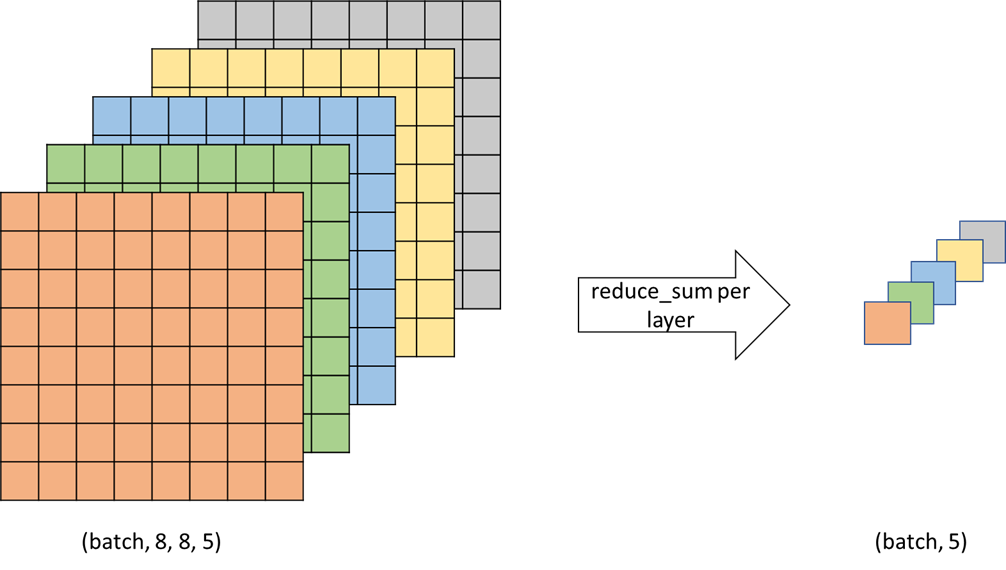

In [ ]:
class GlobalSumPooling2D(tf.keras.layers.Layer):
  def __init__(self, data_format=None, **kwargs):
    super(GlobalSumPooling2D, self).__init__(**kwargs)
    self.data_format = 'channels_last'
    self.input_spec = tf.keras.layers.InputSpec(ndim=4)

  def compute_output_shape(self, input_shape):
    input_shape = tf.keras.TensorShape(input_shape).as_list()
    if self.data_format == 'channels_last':
      return tensor_shape.TensorShape([input_shape[0], input_shape[3]])

  def call(self, inputs):
    return tf.reduce_sum(input_tensor=inputs, axis=[1,2], keepdims=False)

  def get_config(self):
    config = {'data_format': self.data_format}
    return config

<a name="4-2-2"></a>
### 4.2.2 Reflection Padding


Reflection Padding is used in original cycleGAN paper. 

Reflection PAdding works on CPU, but is yet not supported for TPUs : https://cloud.google.com/tpu/docs/tensorflow-ops 

Solution: Symmetry Padding is a similar approach that is still better than zero padding

TPU does not support Gradient calculation of mirrored paddings like "SYMMETRIC" and "REFLECTION" Therefore, a custom gradient needs to be defined as well, by cropping the padding and passing the gradients from the previous layer. 

Custom Gradient: https://www.tensorflow.org/api_docs/python/tf/custom_gradient 

Crop_to_bounding Box: https://www.tensorflow.org/api_docs/python/tf/image/crop_to_bounding_box

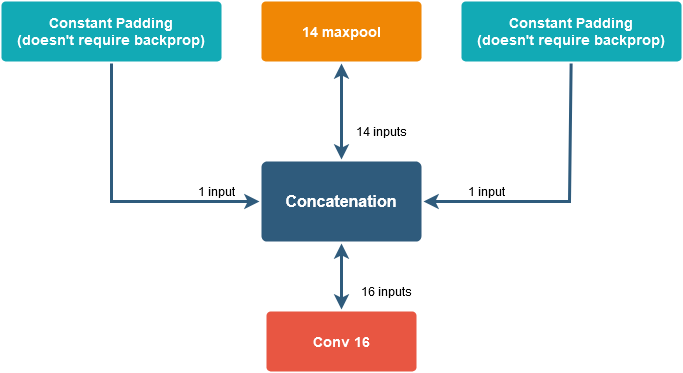


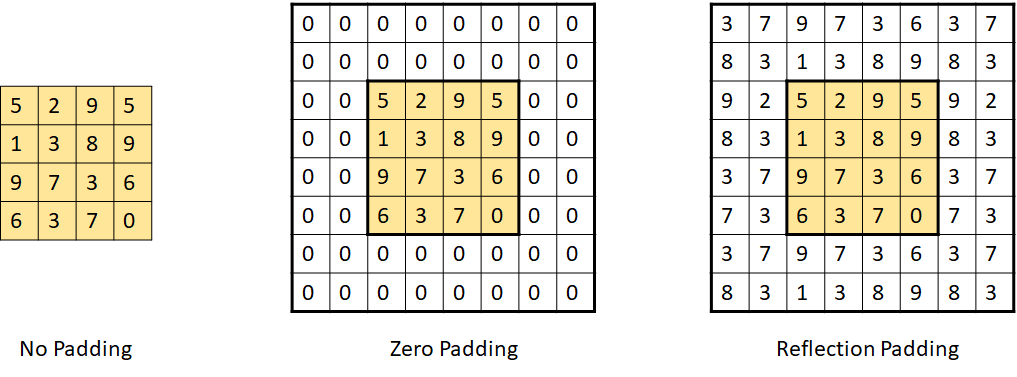

In [ ]:
class ReflectionPadding2D(tf.keras.layers.Layer):
  def __init__(self, padding=(1, 1), **kwargs):
    self.padding = tuple(padding)
    super(ReflectionPadding2D, self).__init__(**kwargs)
  
  @tf.custom_gradient
  def padding_func(self, input_tensor):
    padding_width, padding_height = self.padding
    padding_tensor = [
      [0, 0],
      [padding_height, padding_height],
      [padding_width, padding_width],
      [0, 0],
    ]
    result = tf.pad(input_tensor, padding_tensor, mode="REFLECT")

    # upstream gradient is the chainrule of all previous gradients!
    def custom_grad(upstream):
      #The gradients that represent the padding are cut, since they are not relevant! 
      custom_grad = tf.image.crop_to_bounding_box(
          image = upstream, 
          offset_height = 0, 
          offset_width = 0, 
          target_height = upstream.shape[1]- 2 * padding_height, 
          target_width= upstream.shape[2] - 2* padding_width
          )
      new_upstream = custom_grad
      return new_upstream #new upstream gradient!

    return result, custom_grad

  def compute_output_shape(self, input_shape):
    """ If you are using "channels_last" configuration"""
    return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

  def call(self, input_tensor, mask=None):
    return self.padding_func(input_tensor)

<a name="4-3"></a>
## 4.3 Model Helper Functions

In [ ]:
def GetInitializer(initializerString, seed = None):
  if initializerString == "random_normal":
    return tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=seed)
  elif initializerString == "random_uniform":
    return tf.keras.initializers.RandomUniform(minval=-0.002, maxval=0.02, seed=seed)
  elif initializerString == "glorot_normal":
    return tf.keras.initializers.GlorotNormal(seed=seed)
  elif initializerString == "glorot_uniform":
    return tf.keras.initializers.GlorotUniform(seed=seed)
  elif initializerString == "he_normal":
    return tf.keras.initializers.HeNormal(seed=seed)
  elif initializerString == "he_uniform":
    return tf.keras.initializers.HeUniform(seed=seed)
  elif initializerString == "he_alpha_normal":
    return HeAlphaNormal(seed=seed)
  elif initializerString == "he_alpha_uniform":
    return HeAlphaUniform(seed=seed)
  else:
    raise Exception("Undefined optimizer provided")


In [ ]:
# Weights initializer for the layers.
KERNEL_INIT = GetInitializer(GLOBAL_INITIALIZER, seed = RANDOM_SEED)

# Gamma initializer for instance normalization.
GAMMA_INIT = GetInitializer(GLOBAL_INITIALIZER, seed = RANDOM_SEED) 

#last convolution before a sigmoid or a tanh activation gets the glorot initializer!!
if FINAL_GENERATOR_ACTIVATION == "tanh":
  LAST_KERNEL_INIT = GetInitializer("glorot_uniform", seed = RANDOM_SEED)
else:
  LAST_KERNEL_INIT = GetInitializer("he_uniform", seed = RANDOM_SEED) 

In [ ]:
def pad_func(padding=(1, 1), pad_type = PADDING_TYPE):
  if pad_type == "reflection":
    return ReflectionPadding2D(padding=padding)
  elif pad_type == "zero":
    return tf.keras.layers.ZeroPadding2D(padding=padding)
  else:
    raise Exception("Undefined padding type provided")

In [ ]:
def activation_func(activationFuncString):
  if activationFuncString == "relu":
    return tf.keras.layers.ReLU()
  elif activationFuncString == "leaky_relu":
    return tf.keras.layers.LeakyReLU()
  elif activationFuncString == "elu":
    return tf.keras.layers.ELU()
  elif activationFuncString == "prelu":
    return tf.keras.layers.PReLU(shared_axes=[1, 2]) #each filter has only one param!
  elif activationFuncString == "tanh":
    return tf.keras.activations.tanh
  elif activationFuncString == "sigmoid":
    return tf.keras.activations.sigmoid
  elif activationFuncString == "hard_sigmoid":
    return tf.keras.activations.hard_sigmoid
  elif activationFuncString == "none":
    return tf.keras.activations.get(None)
  else:
    raise Exception("Undefined activation type provided")

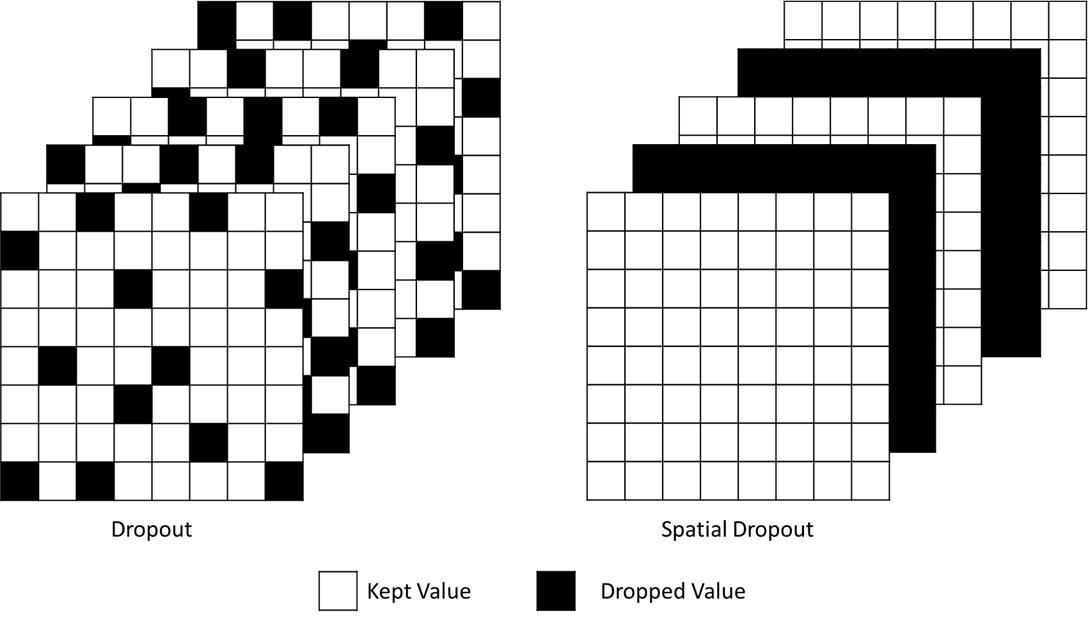

In [ ]:
def dropout_func(n_filters, dropout_rate):
  if n_filters > 1:
    return tf.keras.layers.SpatialDropout2D(dropout_rate)
  else:
    return tf.keras.layers.Dropout(dropout_rate)

<a name="4-4"></a>
## 4.4 Custom Loss Functions

loss Reduction Explanation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Reduction

Hinweis: 
- da in der methode:distributed_train_step() die reduction strategy "sum" ist, muss ich hier durch die globale Batch size teilen.

Comonly Loss Functions: https://phuctrt.medium.com/loss-functions-why-what-where-or-when-189815343d3f

Adversarial Loss:
- Use Mean absolute squared(MSE) error.
>$MSE = \frac{\sum_{i=1}^n(y_{i}-y_{i}^p)^2}{n}$ = tf.reduce_mean(tf.square(real - identity))

Identity Loss:
- Uses pixel distance. Idially there is no difference! MAE (Mean Absolute Error) is used. This is a regression loss function
>$MAE = \frac{\sum_{i=1}^n|y_{i}-y_{i}^p|}{n}$ = tf.reduce_mean(tf.abs(real - identity))

Cycle Loss:
- Uses pixel distance. Idially there is no difference! MAE (Mean Absolute Error) is used. This is a regression loss function
>$MAE = \frac{\sum_{i=1}^n|y_{i}-y_{i}^p|}{n}$ = tf.reduce_mean(tf.abs(real - cycled))

SSIM Loss:
 - inspired by: http://arxiv.org/abs/1901.04604 and https://ieeexplore.ieee.org/document/1284395
 > $SSIM = [l(\hat{x},x)]^{\alpha} \cdot [c(\hat{x},x)]^{\beta} \cdot [s(\hat{x},x)]^{\gamma} $

 > $ l(\hat{x},x) = \frac{2\mu_{\hat{x}}\mu_x + C_1}{\mu_{\hat{x}}^2 + \mu_x^2 + C_1} $

 > $ c(\hat{x},x) = \frac{2\sigma_{\hat{x}}\sigma_x + C_2}{\sigma_{\hat{x}}^2 + \sigma_x^2 + C_2} $

 > $ s(\hat{x},x) = \frac{\sigma_{\hat{x}x} + C_3}{\sigma_{\hat{x}}  \sigma_x + C_3}  $

 > $L_{SSIM} = 1- SSIM$
 
ACHTUNG: Im bezug auf die reduction strategy
-  tf.reduce_sum(loss) * (1/shape) = tf.reduce_mean(loss)
- since reduction strategy = None, the ruslt must be reduced manually and divided by the global batch_size! e.g. `gen_loss_encoder = tf.reduce_mean(gen_loss_encoder) * (1. / GLOBAL_BATCH_SIZE)` 



Loss examples in a cycleGAN: https://arxiv.org/pdf/1912.06112.pdf

My Deviations:
- instead of BCE I use MSE and MAE
- I do calculate the loss per channel to avoid channel polution



In [ ]:
# Loss function for evaluating adversarial loss

if ADV_LOSS == "mean_squared_error":
  adv_loss_fn = tf.keras.losses.MeanSquaredError(reduction=REDUCTION_STRATEGY)
elif ADV_LOSS == "binary_crossentropy":
  adv_loss_fn = tf.keras.losses.BinaryCrossentropy(reduction=REDUCTION_STRATEGY)
elif ADV_LOSS == "hinge":
  adv_loss_fn = tf.keras.losses.Hinge(reduction=REDUCTION_STRATEGY)
else:
  raise Exception("loss type is not defined") 

# Define the loss function for the generators
def generator_loss_fn(generated):
  gen_loss = adv_loss_fn(tf.ones_like(generated), generated)
  gen_loss = tf.reduce_mean(gen_loss) * (1. / GLOBAL_BATCH_SIZE)
  return gen_loss

# Generator loss function for UNet based Discriminator
def generator_loss_fn_UNet_Disc(generatedEncoder, generatedDecoder):
  gen_loss_encoder = adv_loss_fn(tf.ones_like(generatedEncoder), generatedEncoder)
  gen_loss_decoder = adv_loss_fn(tf.ones_like(generatedDecoder), generatedDecoder)
  
  gen_loss_encoder = tf.reduce_mean(gen_loss_encoder) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_decoder = tf.reduce_mean(gen_loss_decoder) * (1. / GLOBAL_BATCH_SIZE) 

  gen_loss = gen_loss_encoder + gen_loss_decoder

  return gen_loss

def generator_loss_fn_OneShot_Disc(generated_low_level, generated_layout, generated_content):
  gen_loss_low_level = adv_loss_fn(tf.ones_like(generated_low_level), generated_low_level)
  gen_loss_layout = adv_loss_fn(tf.ones_like(generated_layout), generated_layout)
  gen_loss_content = adv_loss_fn(tf.ones_like(generated_content), generated_content)

  gen_loss_low_level = tf.reduce_mean(gen_loss_low_level) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_layout = tf.reduce_mean(gen_loss_layout) * (1. / GLOBAL_BATCH_SIZE) 
  gen_loss_content = tf.reduce_mean(gen_loss_content) * (1. / GLOBAL_BATCH_SIZE) 

  gen_loss = gen_loss_low_level + gen_loss_layout + gen_loss_content # times two is suggested by paper! 

  return gen_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, generated):
  real_loss = adv_loss_fn(tf.ones_like(real), real)
  generated_loss = adv_loss_fn(tf.zeros_like(generated), generated)
  disc_loss = (real_loss + generated_loss) * 0.5
  
  disc_loss = tf.reduce_mean(disc_loss) * (1. / GLOBAL_BATCH_SIZE) 
  return disc_loss

# Discriminator loss function for UNet based Discriminator
def discriminator_loss_fn_UNet_Disc(realEncoder, 
                                    realDecoder,
                                    generatedEncoder, 
                                    generatedDecoder, 
                                    descriminatedCutmix, 
                                    cutmixDescriminated):

  #calculate encoder loss
  real_loss_encoder = adv_loss_fn(tf.ones_like(realEncoder), realEncoder)
  gen_loss_encoder = adv_loss_fn(tf.zeros_like(generatedEncoder), generatedEncoder)
  disc_loss_encoder = (real_loss_encoder + gen_loss_encoder) * 0.5
  disc_loss_encoder = tf.reduce_mean(disc_loss_encoder) * (1. / GLOBAL_BATCH_SIZE)

  #calculate decoder loss
  real_loss_decoder = adv_loss_fn(tf.ones_like(realDecoder), realDecoder)
  gen_loss_decoder = adv_loss_fn(tf.zeros_like(generatedDecoder), generatedDecoder)
  disc_loss_decoder = (real_loss_decoder + gen_loss_decoder) * 0.5
  disc_loss_decoder = tf.reduce_mean(disc_loss_decoder) * (1. / GLOBAL_BATCH_SIZE)

  #calculate disriminator loss
  disc_loss = disc_loss_encoder + disc_loss_decoder

  if descriminatedCutmix != None and cutmixDescriminated != None:
    lambda_consistency = 1
    #calculate decoder consistency loss (L2 Norm)
    decoder_consistency = tf.square(descriminatedCutmix - cutmixDescriminated) 
    disc_loss_decoder_consistency = tf.reduce_mean(decoder_consistency) * (1. / GLOBAL_BATCH_SIZE)

    #Enhance disriminator loss
    disc_loss = disc_loss + lambda_consistency * disc_loss_decoder_consistency
  
  return disc_loss

# Discriminator loss function for UNet based Discriminator
def discriminator_loss_fn_OneShot_Disc(real_low_level, real_layout, real_content, generated_low_level, generated_layout, generated_content):

  #calculate low_level loss
  real_loss_low_level = adv_loss_fn(tf.ones_like(real_low_level), real_low_level)
  gen_loss_low_level = adv_loss_fn(tf.zeros_like(generated_low_level), generated_low_level)
  disc_loss_low_level = (real_loss_low_level + gen_loss_low_level) * 0.5
  disc_loss_low_level = tf.reduce_mean(disc_loss_low_level) * (1. / GLOBAL_BATCH_SIZE)
  

  #calculate layout loss
  real_loss_layout = adv_loss_fn(tf.ones_like(real_layout), real_layout)
  gen_loss_layout = adv_loss_fn(tf.zeros_like(generated_layout), generated_layout)
  disc_loss_layout = (real_loss_layout + gen_loss_layout) * 0.5
  disc_loss_layout = tf.reduce_mean(disc_loss_layout) * (1. / GLOBAL_BATCH_SIZE)

  #calculate content loss
  real_loss_content = adv_loss_fn(tf.ones_like(real_content), real_content)
  gen_loss_content = adv_loss_fn(tf.zeros_like(generated_content), generated_content)
  disc_loss_content = (real_loss_content + gen_loss_content) * 0.5
  disc_loss_content = tf.reduce_mean(disc_loss_content) * (1. / GLOBAL_BATCH_SIZE)

  #calculate disriminator loss
  disc_loss = disc_loss_low_level + disc_loss_layout + disc_loss_content
  
  return disc_loss

#calculates the abs pixel distance between two images
def pixel_distance_loss(img1, img2, norm ):
  img1 = tf.cast(img1, tf.dtypes.float32)
  img2 = tf.cast(img2, tf.dtypes.float32)
  pixel_distance_loss = 0

  if PIXEL_DISTANCE == "per_channel":
    #initialize all weights with 1
    channelWeight = np.ones(img1.shape[-1])
    if NORMALIZE_DEPTH_CHANNEL:
      #set weight of the depth channel according to the number of color channels: e.g. for RGB = 3
      channelWeight[-1] = len(channelWeight)-1
    if norm == "l1":
      #loop over all channels of the image
      for i in range(img1.shape[-1]): 
        pixel_distance_loss += channelWeight[i] * tf.reduce_mean(tf.abs(img1[:,:,:,i] - img2[:,:,:,i])) * (1. / GLOBAL_BATCH_SIZE)
    elif norm == "l2":
      #loop over all channels of the image
      for i in range(img1.shape[-1]): 
        pixel_distance_loss += channelWeight[i] * tf.reduce_mean(tf.square(img1[:,:,:,i] - img2[:,:,:,i])) * (1. / GLOBAL_BATCH_SIZE)
    else:
      raise Exception("parameter norm={} is not defined. Use 'l1' or 'l2' instead.".format(norm))
    
  elif PIXEL_DISTANCE == "per_image":
    if norm == "l1":
      pixel_distance_loss = tf.reduce_mean(tf.abs(img1 - img2)) * (1. / GLOBAL_BATCH_SIZE)
    elif norm == "l2":
      pixel_distance_loss = tf.reduce_mean(tf.square(img1 - img2)) * (1. / GLOBAL_BATCH_SIZE)
    else:
      raise Exception("parameter norm={} is not defined. Use 'l1' or 'l2' instead.".format(norm))
     
  else:
    raise Exception("pixel distance type is not defined")

  return pixel_distance_loss

# Cycle Consistency Loss
#requires wrapper since only two input parameters are allowed in the loss delegate!
def cycle_loss_l1_fn(real, identity):
  return pixel_distance_loss(real, identity, norm = "l1")

def cycle_loss_l2_fn(real, identity):
  return pixel_distance_loss(real, identity, norm = "l2")

# Identity Loss 
#requires wrapper since only two input parameters are allowed in the loss delegate!
def identity_loss_l1_fn(real, same):
  return pixel_distance_loss(real, same, norm = "l1")

def identity_loss_l2_fn(real, same):
  return pixel_distance_loss(real, same, norm = "l2")

def SSIM(tensor1, tensor2):
  alpha = 1
  beta = 1
  gamma = 1
  C1 = 0.01**2
  C2 = 0.03**2
  C3 = C2/2

  mu1 = tf.reduce_mean(tensor1) #mean
  mu2 = tf.reduce_mean(tensor2)
  sigma1 = tf.reduce_mean((tensor1-mu1)**2)**0.5 #standard deviation
  sigma2 = tf.reduce_mean((tensor2-mu2)**2)**0.5  
  covar = tf.reduce_mean((tensor1-mu1)*(tensor2-mu2)) #covariance

  l = (2*mu1*mu2 + C1)/(mu1**2 + mu2**2 + C1)
  c = (2*sigma1*sigma2 + C2)/(sigma1**2 + sigma2**2 + C2)
  s = (covar + C3)/(sigma1 * sigma2 + C3)

  SSIM = l**alpha * c**beta * s**gamma 
  ssim = (1- SSIM) * (1. / GLOBAL_BATCH_SIZE)

  return ssim

def ssim_loss_fn(img1, img2):
  img1 = tf.cast(img1, tf.dtypes.float32)
  img2 = tf.cast(img2, tf.dtypes.float32)
  alpha = 1
  beta = 1
  gamma = 1
  C1 = 0.01**2
  C2 = 0.03**2
  C3 = C2/2
  ssim = 0

  if SSIM_CALCULATION == "per_image":
    ssim = SSIM(img1,img1)
  elif SSIM_CALCULATION == "per_channel":
    #initialize all weights with 1
    channelWeight = np.ones(img1.shape[-1])
    if NORMALIZE_DEPTH_CHANNEL:
      #set weight of the depth channel according to the number of color channels: e.g. for RGB = 3
      channelWeight[-1] = len(channelWeight)-1
    #loop over all channels of the image
    for i in range(img1.shape[-1]):
      ssim += channelWeight[i]*SSIM(img1[:,:,:,i],img2[:,:,:,i])
  else:
    raise Exception("ssim calculation type is not defined")

  return ssim


<a name="4-5"></a>
## 4.5 Custom Optimizer

The SWATS Optimizer is an optimizer that starts with ADAM and switches to SGD after a certain epoch. 

Since this optimizer is not available in Tensorflow, it has been implemented based on the original tensorflow implementation of ADAM and SGD.
> SWATS Paper: http://arxiv.org/abs/1712.07628 

>TensorFlow ADAM: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/optimizer_v2/adam.py

> Tensorflow SGD: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/optimizer_v2/gradient_descent.py


In addition to the original SWATS optimizer, I implemented an enhanced version using NADAM instead of ADAM, see SWATS_NADAM class.
> Tensorflow NADAM: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/optimizer_v2/nadam.py 

**Note on functionality**:
>Custom optimizer work fine in Google Colab using a GPU. on the TPU it might not work, since due to the extensive padding, there is not enough memory for further parameters in the optimzer (for a given model) and hence the model architecture must be simplified a lot!









In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.eager import def_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export

from tensorflow.python.keras.optimizer_v2 import learning_rate_schedule
from tensorflow.python.ops import variables as tf_variables

In [ ]:
class SWATS_ADAM(optimizer_v2.OptimizerV2):

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
              learning_rate=0.001,
              beta_1=0.9,
              beta_2=0.999,
              epsilon=1e-7,
              amsgrad=False,
              momentum=0.0,
              nesterov=False,
              name='SWATS_ADAM',
              **kwargs):
    super(SWATS_ADAM, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.amsgrad = amsgrad
    self.currentOptimizer = "adam"

    self._momentum = False
    if isinstance(momentum, ops.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError("`momentum` must be between [0, 1].")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self.amsgrad:
      for var in var_list:
        self.add_slot(var, 'vhat')
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(SWATS_ADAM, self)._prepare_local(var_device, var_dtype, apply_state)

    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    beta_1_power = math_ops.pow(beta_1_t, local_step)
    beta_2_power = math_ops.pow(beta_2_t, local_step)
    lr = (apply_state[(var_device, var_dtype)]['lr_t'] * (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            epsilon=ops.convert_to_tensor_v2_with_dispatch(self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t))
    
    apply_state[(var_device, var_dtype)]["momentum"] = array_ops.identity(self._get_hyper("momentum", var_dtype))

  def set_weights(self, weights):
    params = self.weights
    # If the weights are generated by Keras V1 optimizer, it includes vhats
    # even without amsgrad, i.e, V1 optimizer has 3x + 1 variables, while V2
    # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
    num_vars = int((len(params) - 1) / 2)
    if len(weights) == 3 * num_vars + 1:
      weights = weights[:len(params)]
    super(SWATS_ADAM, self).set_weights(weights)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self.currentOptimizer == "sgd":
      if self._momentum:
        momentum_var = self.get_slot(var, "momentum")
        return gen_training_ops.ResourceApplyKerasMomentum(
            var=var.handle,
            accum=momentum_var.handle,
            lr=coefficients["lr_t"],
            grad=grad,
            momentum=coefficients["momentum"],
            use_locking=self._use_locking,
            use_nesterov=self.nesterov)
      else:
        return gen_training_ops.ResourceApplyGradientDescent(
            var=var.handle,
            alpha=coefficients["lr_t"],
            delta=grad,
            use_locking=self._use_locking)

    elif self.currentOptimizer == "adam":
      m = self.get_slot(var, 'm')
      v = self.get_slot(var, 'v')
      if not self.amsgrad:
        return gen_training_ops.ResourceApplyAdam(
            var=var.handle,
            m=m.handle,
            v=v.handle,
            beta1_power=coefficients['beta_1_power'],
            beta2_power=coefficients['beta_2_power'],
            lr=coefficients['lr_t'],
            beta1=coefficients['beta_1_t'],
            beta2=coefficients['beta_2_t'],
            epsilon=coefficients['epsilon'],
            grad=grad,
            use_locking=self._use_locking)
      else:
        vhat = self.get_slot(var, 'vhat')
        return gen_training_ops.ResourceApplyAdamWithAmsgrad(
            var=var.handle,
            m=m.handle,
            v=v.handle,
            vhat=vhat.handle,
            beta1_power=coefficients['beta_1_power'],
            beta2_power=coefficients['beta_2_power'],
            lr=coefficients['lr_t'],
            beta1=coefficients['beta_1_t'],
            beta2=coefficients['beta_2_t'],
            epsilon=coefficients['epsilon'],
            grad=grad,
            use_locking=self._use_locking)
    else:
      raise Exception("Optimizer is not Defined. Use adam or sgd.")
    
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self.currentOptimizer == "sgd":
      momentum_var = self.get_slot(var, "momentum")
      return gen_training_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)

    elif self.currentOptimizer == "adam":
      m = self.get_slot(var, 'm')
      m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
      m_t = state_ops.assign(m, m * coefficients['beta_1_t'], use_locking=self._use_locking)
      with ops.control_dependencies([m_t]):
        m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

      v = self.get_slot(var, 'v')
      v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
      v_t = state_ops.assign(v, v * coefficients['beta_2_t'], use_locking=self._use_locking)
      with ops.control_dependencies([v_t]):
        v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

      if not self.amsgrad:
        v_sqrt = math_ops.sqrt(v_t)
        var_update = state_ops.assign_sub(var, coefficients['lr'] * m_t / (v_sqrt + coefficients['epsilon']), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t])
      else:
        v_hat = self.get_slot(var, 'vhat')
        v_hat_t = math_ops.maximum(v_hat, v_t)
        with ops.control_dependencies([v_hat_t]):
          v_hat_t = state_ops.assign(v_hat, v_hat_t, use_locking=self._use_locking)
        v_hat_sqrt = math_ops.sqrt(v_hat_t)
        var_update = state_ops.assign_sub( var, oefficients['lr'] * m_t / (v_hat_sqrt + coefficients['epsilon']), use_locking=self._use_locking)
        return control_flow_ops.group(*[var_update, m_t, v_t, v_hat_t])
    else:
      raise Exception("Optimizer is not Defined. Use adam or sgd.")

  def get_config(self):
    config = super(SWATS_ADAM, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        'amsgrad': self.amsgrad,
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
        "current_optimizer": self.currentOptimizer,
    })
    return config



In [ ]:
class SWATS_NADAM(optimizer_v2.OptimizerV2):

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
                learning_rate=0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-7,
                momentum=0.0,
                nesterov=False,
                name='SWATS_NADAM',
                **kwargs):
    super(SWATS_NADAM, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.currentOptimizer = "nadam"

    self._momentum = False
    if isinstance(momentum, ops.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError("`momentum` must be between [0, 1].")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov
    self._m_cache = None

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self._m_cache is None:
      var_dtype = var_list[0].dtype.base_dtype
      self._m_cache = self.add_weight(
        'momentum_cache',
        shape=[],
        dtype=var_dtype,
        initializer='ones',
        trainable=False,
        aggregation=tf_variables.VariableAggregation.ONLY_FIRST_REPLICA)
    self._weights.append(self._m_cache)
    
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")
    

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(SWATS_NADAM, self)._prepare_local(var_device, var_dtype, apply_state)

    # From Nadam Optimizer!
    lr_t = array_ops.identity(self._get_hyper('learning_rate', var_dtype))
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    next_step = math_ops.cast(self.iterations + 2, var_dtype)
    decay_base = math_ops.cast(0.96, var_dtype)
    m_t = beta_1_t * (1. - 0.5 * (math_ops.pow(decay_base, self._initial_decay * local_step)))
    m_t_1 = beta_1_t * (1. - 0.5 * (math_ops.pow(decay_base, self._initial_decay * next_step)))
    m_schedule_new = math_ops.cast(self._m_cache_read, var_dtype) * m_t
    if var_dtype is self._m_cache.dtype:
      m_schedule_new = array_ops.identity(state_ops.assign(self._m_cache, m_schedule_new, use_locking=self._use_locking))
    m_schedule_next = m_schedule_new * m_t_1

    apply_state[(var_device, var_dtype)] = dict(
      lr_t=lr_t,
      neg_lr_t=-lr_t,
      epsilon=ops.convert_to_tensor_v2_with_dispatch(self.epsilon, var_dtype),
      beta_1_t=beta_1_t,
      beta_2_t=beta_2_t,
      m_t=m_t,
      m_t_1=m_t_1,
      one_minus_beta_1_t=1 - beta_1_t,
      one_minus_beta_2_t=1 - beta_2_t,
      one_minus_m_t=1. - m_t,
      one_minus_m_schedule_new=1. - m_schedule_new,
      one_minus_m_schedule_next=1. - m_schedule_next,
      v_t_prime_denominator=1. - math_ops.pow(beta_2_t, local_step),
      )
    
    #from SGD Optimizer
    apply_state[(var_device, var_dtype)]["momentum"] = array_ops.identity(self._get_hyper("momentum", var_dtype))

  def _prepare(self, var_list):
    # Get the value of the momentum cache before starting to apply gradients.
    self._m_cache_read = array_ops.identity(self._m_cache)
    return super(SWATS_NADAM, self)._prepare(var_list)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    #SGD Optimizer!
    if self.currentOptimizer == "sgd":
      if self._momentum:
        momentum_var = self.get_slot(var, "momentum")
        return gen_training_ops.ResourceApplyKerasMomentum(
            var=var.handle,
            accum=momentum_var.handle,
            lr=coefficients["lr_t"],
            grad=grad,
            momentum=coefficients["momentum"],
            use_locking=self._use_locking,
            use_nesterov=self.nesterov)
      else:
        return gen_training_ops.ResourceApplyGradientDescent(
            var=var.handle,
            alpha=coefficients["lr_t"],
            delta=grad,
            use_locking=self._use_locking)
    #Nadam Optimizer!
    elif self.currentOptimizer == "nadam":
      m = self.get_slot(var, 'm')
      v = self.get_slot(var, 'v')
      g_prime = grad / coefficients['one_minus_m_schedule_new']
      m_t = (coefficients['beta_1_t'] * m +coefficients['one_minus_beta_1_t'] * grad)
      m_t = state_ops.assign(m, m_t, use_locking=self._use_locking)
      m_t_prime = m_t / coefficients['one_minus_m_schedule_next']
      v_t = (coefficients['beta_2_t'] * v + coefficients['one_minus_beta_2_t'] * math_ops.square(grad))
      v_t = state_ops.assign(v, v_t, use_locking=self._use_locking)
      v_t_prime = v_t / coefficients['v_t_prime_denominator']
      m_t_bar = (coefficients['one_minus_m_t'] * g_prime + coefficients['m_t_1'] * m_t_prime)
      var_t = var - coefficients['lr_t'] * m_t_bar / ( math_ops.sqrt(v_t_prime) + coefficients['epsilon'])
      return state_ops.assign(var, var_t, use_locking=self._use_locking).op
    else:
      raise Exception("Optimizer is not Defined. Use nadam or sgd.")
    
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    # SGD Part
    if self.currentOptimizer == "sgd":
      momentum_var = self.get_slot(var, "momentum")
      return gen_training_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)
    # Nadam Part
    elif self.currentOptimizer == "nadam":

      m = self.get_slot(var, 'm')
      v = self.get_slot(var, 'v')

      g_prime = grad / coefficients['one_minus_m_schedule_new']

      m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
      m_t = state_ops.assign(m, m * coefficients['beta_1_t'], use_locking=self._use_locking)

      with ops.control_dependencies([m_t]):
        m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_t_slice = array_ops.gather(m_t, indices)

      m_t_prime = m_t_slice / coefficients['one_minus_m_schedule_next']
      m_t_bar = (coefficients['one_minus_m_t'] * g_prime + coefficients['m_t_1'] * m_t_prime)

      v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
      v_t = state_ops.assign(v, v * coefficients['beta_2_t'], use_locking=self._use_locking)

      with ops.control_dependencies([v_t]):
        v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)
        v_t_slice = array_ops.gather(v_t, indices)

      v_t_prime = v_t_slice / coefficients['v_t_prime_denominator']
      v_prime_sqrt_plus_eps = math_ops.sqrt(v_t_prime) + coefficients['epsilon']

      var_update = self._resource_scatter_add( var, indices, coefficients['neg_lr_t'] * m_t_bar / v_prime_sqrt_plus_eps)
      return control_flow_ops.group(*[var_update, m_t_bar, v_t])
    else:
      raise Exception("Optimizer is not Defined. Use nadam or sgd.")

  def get_config(self):
    config = super(SWATS_NADAM, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
        "current_optimizer": self.currentOptimizer,
    })
    return config


<a name="4-6"></a>
## 4.6 Basic Building Blocks

<a name="4-6-1"></a>
### 4.6.1 Convolutional Block

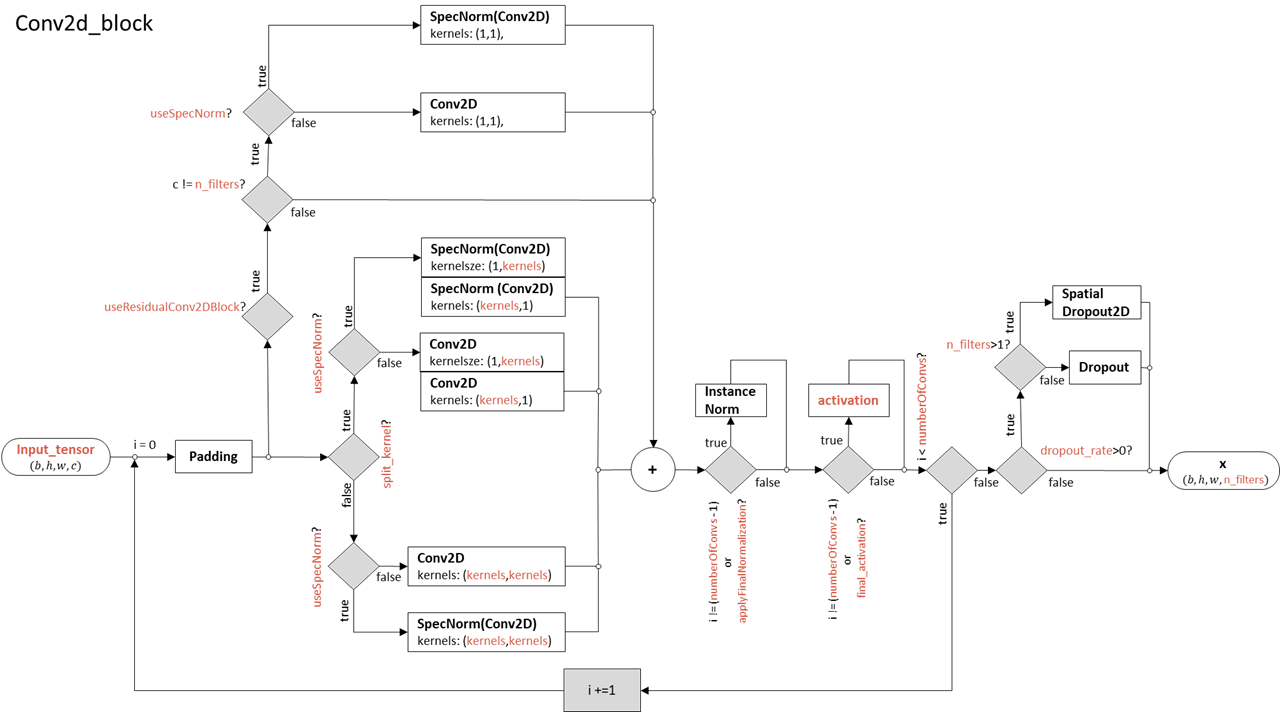

In [ ]:
def conv2d_block(
    input_tensor, 
    n_filters, 
    useResidualConv2DBlock, 
    kernels, 
    split_kernels, 
    numberOfConvs, 
    activation, 
    dropout_rate=0, 
    final_activation = True, 
    useSpecNorm = USE_SPEC_NORM, 
    strides = (1,1), 
    applyPadding = True, 
    applyFinalNormalization = True
    ):
  
  pad = int((kernels-1)/2) # assumes odd kernel size, which is typical!

  # first layer
  x = input_tensor
  for i in range(numberOfConvs):
    residual = x
    numFilters = tf.keras.backend.int_shape(residual)[-1]
    
    if pad != 0 and applyPadding:
      x = pad_func(padding = (pad,pad))(x)

    if split_kernels:
      conv2DLayer1 = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (1, kernels), 
                                            kernel_initializer = KERNEL_INIT,
                                            use_bias = USE_BIAS_NODES,strides=strides)
      conv2DLayer11 = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernels, 1),
                                             kernel_initializer = KERNEL_INIT,
                                             use_bias = USE_BIAS_NODES,strides=strides)
      if useSpecNorm:
        x = tfa.layers.SpectralNormalization(conv2DLayer1)(x)
        x = tfa.layers.SpectralNormalization(conv2DLayer11)(x)
      else:
        x = conv2DLayer1(x)
        x = conv2DLayer11(x)
    else:
      conv2DLayer1 = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernels, kernels),
                                            kernel_initializer = KERNEL_INIT,
                                            use_bias = USE_BIAS_NODES,strides=strides)
      if useSpecNorm:
        x = tfa.layers.SpectralNormalization(conv2DLayer1)(x)
      else:
        x = conv2DLayer1(x)
    
    
    if useResidualConv2DBlock:
      if numFilters != n_filters:
        conv2DLayer2 = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = 1,
                                              kernel_initializer = KERNEL_INIT,
                                              use_bias = USE_BIAS_NODES, strides=strides)
        if useSpecNorm:
          residual = tfa.layers.SpectralNormalization(conv2DLayer2)(residual)
        else:
          residual = conv2DLayer2(residual)
      x = tf.keras.layers.Add()([x, residual])  
  
    if i != (numberOfConvs - 1) or applyFinalNormalization:
        x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)

    if i != (numberOfConvs - 1) or final_activation:
      x = activation_func(activation)(x)

  if dropout_rate > 0:
    x = dropout_func(n_filters, dropout_rate)(x)

  return x

#Testcode

#inputs = tf.keras.layers.Input(shape = (512,512,64))
#model = tf.keras.Model(inputs=inputs, outputs=conv2d_block(inputs, n_filters = 1, useResidualConv2DBlock = True, kernels = 3, split_kernels  = False, useSpecNorm = True, numberOfConvs = 2, activation = "relu", dropout_rate =0.1, final_activation = False, applyFinalNormalization = True))
#model.summary()
#model_filename = '{}_gen_model.png'.format(NAME)
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=True, to_file=model_filename)


<a name="4-6-2"></a>
### 4.6.2 Down-Sample Block







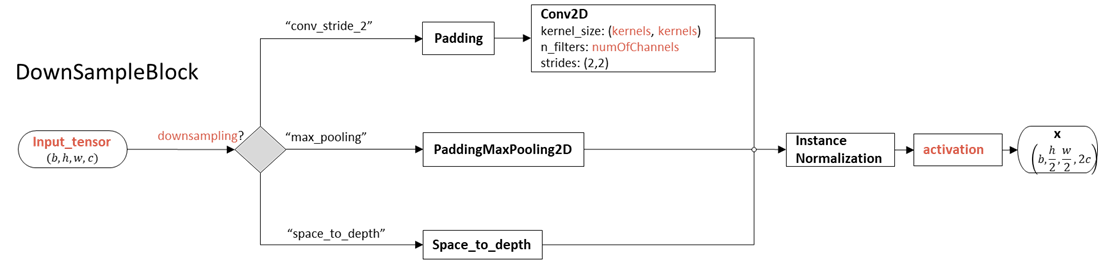

In [ ]:
def DownSampleBlock(input_tensor, numOfChannels, kernels, downsampling, activation, useSpecNorm):
  x = input_tensor
  if downsampling == "conv_stride_2":
    x = conv2d_block(input_tensor, numOfChannels, False, kernels, False, 1, activation, strides = (2,2), useSpecNorm=useSpecNorm)
  elif downsampling == "max_pooling":
    #Only spatial downsampling, increase in features is done by the conv2D_block specified later!
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
  elif downsampling =="average_pooling":
    x = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(x)
  elif downsampling == "space_to_depth":
    #Only spatial downsampling, increase in features is done by the conv2D_block specified later!
    x = tf.nn.space_to_depth(x, block_size = 2)
  else:
    raise Exception("Undefined downsampling provided")
  return x

#Testcode
#inputs = tf.keras.layers.Input(shape = (512,512,4))
#model = tf.keras.Model(inputs=inputs, outputs=DownSampleBlock(inputs, numOfChannels = 64, kernels = 3,  downsampling = "conv_stride_2", activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)

<a name="4-6-3"></a>
### 4.6.2 Up-Sample Block

In [ ]:
def BilinearAdditiveResidualUpsampling(input_tensor, numOfChannels,  kernels , split_kernels, activation,useSpecNorm):
  inputShape = tf.keras.backend.int_shape(input_tensor)
  assert inputShape[-1] % int(inputShape[-1]/4) == 0

  outputShape = [inputShape[0], int(inputShape[1]*2), int(inputShape[2]*2), int(inputShape[3]/4)]

  channel_split = int(inputShape[-1] / outputShape[-1])

  x = tf.keras.layers.UpSampling2D(interpolation="bilinear")(input_tensor)

  def testLayer(input_tensor):
    res_list = []
    for i in range(outputShape[-1]):
        input_tensor = input_tensor[:,:,:,i*channel_split:(i+1)*channel_split]
        res_list.append(tf.reduce_sum(input_tensor, axis = -1))
    return tf.stack(res_list, axis = -1)

  res = tf.keras.layers.Lambda(testLayer)(x)

  y = tf.nn.depth_to_space(input_tensor, block_size = 2)
  x = conv2d_block(x, n_filters = numOfChannels, useResidualConv2DBlock = False, kernels = kernels, split_kernels = split_kernels, numberOfConvs = 1, activation = activation,useSpecNorm=useSpecNorm)

  output = tf.keras.layers.Add()([res,y])

  return output

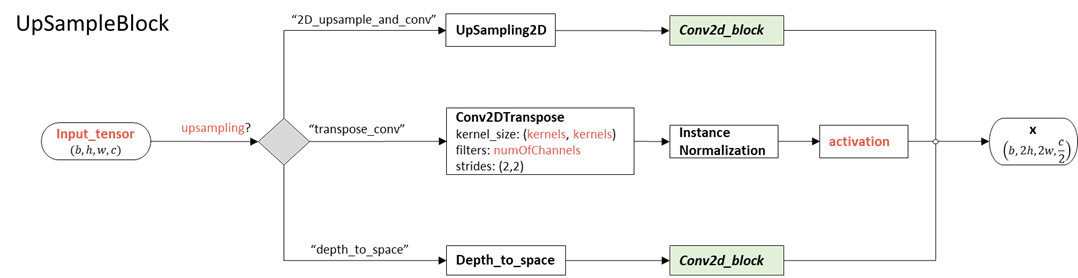

In [ ]:
def UpSampleBlock(input_tensor, numOfChannels,  kernels , split_kernels, upsampling , activation, useSpecNorm):
  x = input_tensor
  if upsampling == "2D_upsample_and_conv":
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(x)
    x = conv2d_block(x, n_filters = numOfChannels, useResidualConv2DBlock = False, kernels = 1, split_kernels = split_kernels, numberOfConvs = 1, activation = activation,useSpecNorm=useSpecNorm)
  elif upsampling == "transpose_conv":
    x = tf.keras.layers.Conv2DTranspose(numOfChannels,kernel_size = (3, 3),strides=(2,2),kernel_initializer = KERNEL_INIT,padding='same',use_bias = USE_BIAS_NODES)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(x)
    x = activation_func(activation)(x)
  elif upsampling == "depth_to_space":
    x = conv2d_block(x, n_filters = 4 * numOfChannels, useResidualConv2DBlock = False, kernels = 1, split_kernels = False, numberOfConvs = 1, activation = activation,useSpecNorm=useSpecNorm)
    x = tf.nn.depth_to_space(x, block_size = 2)
  elif upsampling =="bilinear_additive_residual":
    x = BilinearAdditiveResidualUpsampling(x, numOfChannels, kernels, split_kernels, activation)
  else:
    raise Exception("Undefined upsampling provided")

  return x

#Testcode
#inputs = tf.keras.layers.Input(shape = (256,256,64))
#model = tf.keras.Model(inputs=inputs, outputs=UpSampleBlock(inputs, numOfChannels = 32, kernels = 5, upsampling = "depth_to_space", split_kernels  = False, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)

<a name="4-6-4"></a>
### 4.6.4 Residual Identity Block

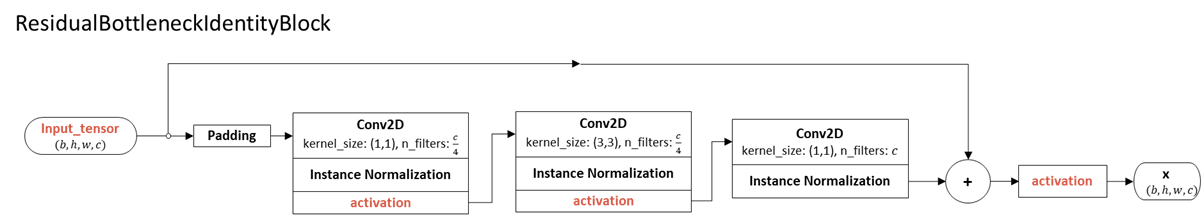

In [ ]:
def ResidualBottleneckIdentityBlock(input_tensor, activation, n_filters,kernels,numberOfBlocks,useSpecNorm, cardinality =1, dropout_rate = 0):
  numFilters = tf.keras.backend.int_shape(input_tensor)[-1]
  pading = int((kernels-1)/2) # assumes odd kernel size, which is typical!

  if cardinality > 1:
    intermediateFilters = int(n_filters/64)
  else:
    intermediateFilters = int(n_filters/4)

  if numFilters != n_filters:
    input_tensor = conv2d_block(input_tensor=input_tensor, n_filters=n_filters, useResidualConv2DBlock=False, kernels=1, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)

  x = input_tensor
  
  for i in range(numberOfBlocks):
    residual = x
    pad = pad_func(padding = (pading,pading))(residual) #padding=1 since 1 times 3x3 kernels bellow
    cardinals = []
    for _ in range(cardinality):

      x = conv2d_block(input_tensor=pad, n_filters=intermediateFilters, useResidualConv2DBlock=False, kernels=1, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)
      x = conv2d_block(input_tensor=x, n_filters=intermediateFilters, useResidualConv2DBlock=False, kernels=kernels, split_kernels=False, numberOfConvs=1, activation=activation,applyPadding=False,useSpecNorm=useSpecNorm)
      x = conv2d_block(input_tensor=x, n_filters=n_filters, useResidualConv2DBlock=False, kernels=1, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)
      cardinals.append(x)

    if len(cardinals)>1:
      x = tf.math.add_n(cardinals)
    x = tf.keras.layers.Add()([x, residual])
  
  if dropout_rate > 0:
    x = dropout_func(n_filters, dropout_rate)(x)

  return x 

#Testcode
#inputs = tf.keras.layers.Input(shape = (512,512,4))
#model = tf.keras.Model(inputs=inputs, outputs=ResidualBottleneckIdentityBlock(inputs,n_filters =64, activation = "leaky_relu", kernels = 3, numberOfBlocks=2,useSpecNorm = False, cardinality =5,dropout_rate=0.2))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=False)

<a name="4-6-5"></a>
### 4.6.5 Residual Down-Sample Block

Idea: 
- Large Scale GAN Training for High Fidelity Natural Image Synthesis, http://arxiv.org/abs/1809.11096



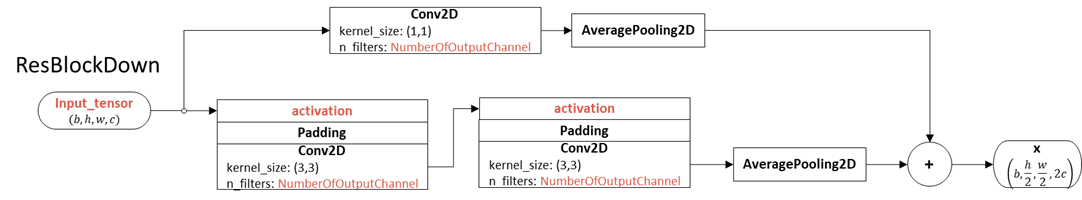

In [ ]:
def ResBlockDown(input_tensor, NumberOfOutputChannel, activation, useSpecNorm ):
  path1 = input_tensor
  path2 = input_tensor

  path1 = conv2d_block(input_tensor=path1, n_filters=NumberOfOutputChannel, useResidualConv2DBlock=False, kernels=1, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)
  path1 = tf.keras.layers.AveragePooling2D()(path1)

  path2 = conv2d_block(input_tensor=path2, n_filters=NumberOfOutputChannel, useResidualConv2DBlock=False, kernels=3, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)
  path2 = conv2d_block(input_tensor=path2, n_filters=NumberOfOutputChannel, useResidualConv2DBlock=False, kernels=3, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)
  path2 = tf.keras.layers.AveragePooling2D()(path2)
  
  output = tf.keras.layers.Add()([path1, path2])

  return output

#Testcode
#input = tf.keras.layers.Input(shape=IMG_SIZE)
#model = tf.keras.Model(inputs=input, outputs=ResBlockDown(input, 8, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-6-6"></a>
### 4.6.6 Residual Up-Sample Block

Idea: 
- Large Scale GAN Training for High Fidelity Natural Image Synthesis, http://arxiv.org/abs/1809.11096


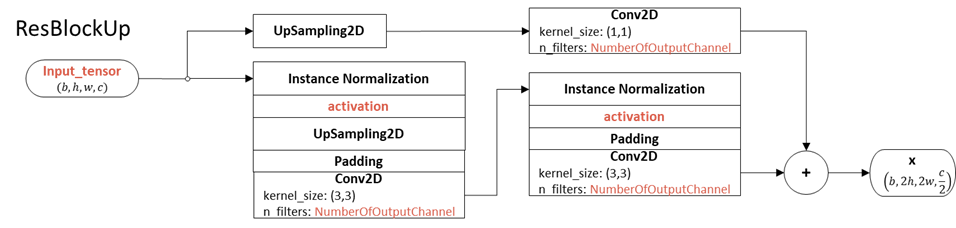

In [ ]:
def ResBlockUp(input_tensor, NumberOfOutputChannel, activation,useSpecNorm):

  path1 = input_tensor
  path2 = input_tensor

  path1 = tf.keras.layers.UpSampling2D()(path1)
  path1 = conv2d_block(input_tensor=path1, n_filters=NumberOfOutputChannel, useResidualConv2DBlock=False, kernels=1, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)

  path2 = tf.keras.layers.UpSampling2D()(path2)
  path2 = conv2d_block(input_tensor=path2, n_filters=NumberOfOutputChannel, useResidualConv2DBlock=False, kernels=3, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)
  path2 = conv2d_block(input_tensor=path2, n_filters=NumberOfOutputChannel, useResidualConv2DBlock=False, kernels=3, split_kernels=False, numberOfConvs=1, activation=activation,useSpecNorm=useSpecNorm)

  output = tf.keras.layers.Add()([path1, path2])

  return output

#Testcode
#inputs = tf.keras.layers.Input(shape=IMG_SIZE)
#model = tf.keras.Model(inputs=inputs, outputs=ResBlockUp(inputs, 4, activation = "leaky_relu"))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-6-7"></a>
### 4.6.7 Self-Attention Block

Non-Local Block Paper: https://arxiv.org/pdf/1711.07971.pdf

Self-Attention GAN: https://arxiv.org/pdf/1805.08318.pdf 

Hint: 
- Non-local Block != Self Attention Block from SAGAN.
- Softmax is applied to each row, not each channel!!

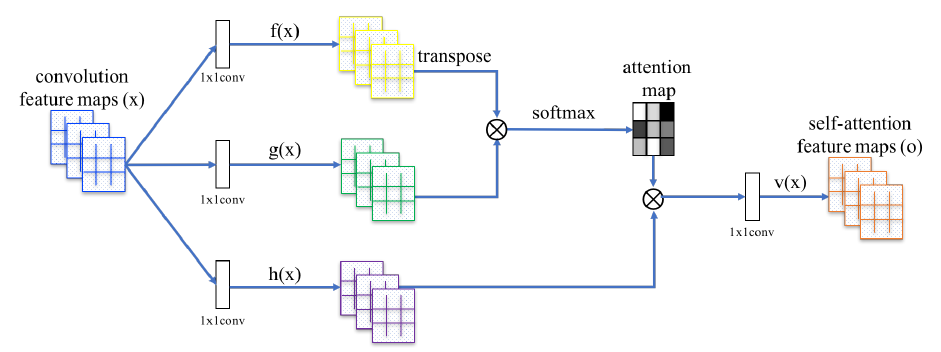

Scale layer is required to have a trainable scale!


In [ ]:
class NonNegative(tf.keras.constraints.Constraint):
 def __call__(self, w):
   return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)

class ScaleLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(ScaleLayer, self).__init__()
    #self.scale = tf.Variable([0.],shape = (1),trainable =True)
    self.scale = self.add_weight(shape=[1],initializer = tf.keras.initializers.Zeros(), constraint=NonNegative() , trainable=True)

  def call(self, inputs):
    return inputs * self.scale

  def get_config(self):
    config = super(ScaleLayer, self).get_config()
    config.update({"scale": self.scale})
    return config


In [ ]:
def SelfAttention(input_tensor,useSpecNorm = USE_SPEC_NORM):
  batchSize, height, width, numChannel = input_tensor.get_shape().as_list()
  location_num = height * width
  intermediateChannel = int(numChannel/8)

  #f = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
  f = conv2d_block(input_tensor, n_filters = intermediateChannel,useResidualConv2DBlock = False, kernels = 1,split_kernels  = False, numberOfConvs = 1, activation = "none", useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  f = tf.keras.layers.LayerNormalization(gamma_initializer = GAMMA_INIT)(f)
  f = tf.keras.layers.Permute(dims=(2, 1, 3))(f)

  #g = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
  g = conv2d_block(input_tensor, n_filters = intermediateChannel,useResidualConv2DBlock = False, kernels = 1,split_kernels  = False, numberOfConvs = 1, activation = "none", useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  g = tf.keras.layers.LayerNormalization(gamma_initializer = GAMMA_INIT)(g)

  #h = tf.keras.layers.Conv2D(filters = intermediateChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(input_tensor)
  h = conv2d_block(input_tensor, n_filters = intermediateChannel,useResidualConv2DBlock = False, kernels = 1,split_kernels  = False, numberOfConvs = 1, activation = "none", useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  h = tf.keras.layers.LayerNormalization(gamma_initializer = GAMMA_INIT)(h)

  f_g = tf.keras.layers.Multiply()([f, g])
  f_g = tf.keras.layers.Softmax(axis=1)(f_g)

  f_g_h = tf.keras.layers.Multiply()([f_g, h])
  #f_g_h = tf.keras.layers.Conv2D(filters = numChannel, kernel_size = (1,1), kernel_initializer = KERNEL_INIT,use_bias = USE_BIAS_NODES)(f_g_h)
  f_g_h = conv2d_block(f_g_h, n_filters = numChannel,useResidualConv2DBlock = False, kernels = 1,split_kernels  = False, numberOfConvs = 1, activation = "none", useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  f_g_h = tf.keras.layers.LayerNormalization(gamma_initializer = GAMMA_INIT)(f_g_h)
  f_g_h = ScaleLayer()(f_g_h)

  z = tf.keras.layers.Add()([f_g_h, input_tensor])

  return z
#Testcode
#input = tf.keras.layers.Input(shape=(128,128,128),batch_size=1)
#model = tf.keras.Model(inputs=input, outputs=SelfAttention(input))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

<a name="4-7"></a>
## 4.7 Sub-Model Building Blocks

<a name="4-7-1"></a>
### 4.7.1 Encoder


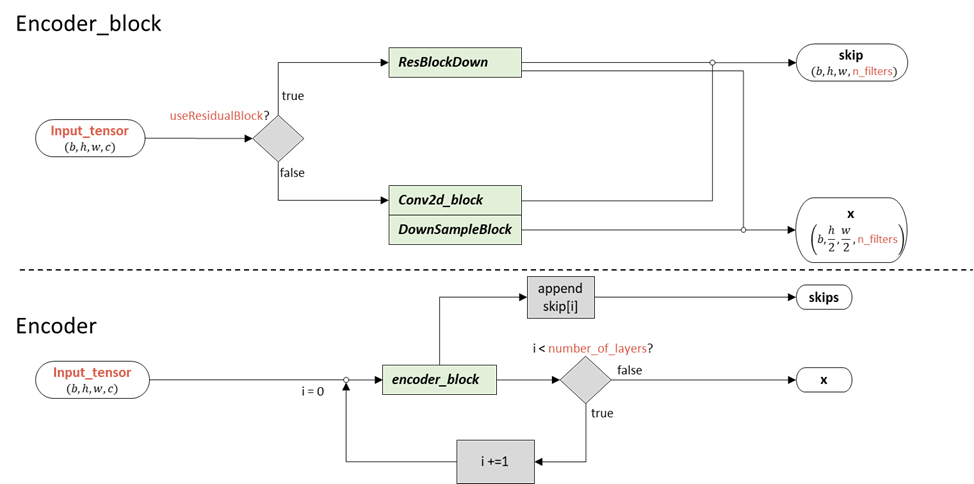

In [ ]:
def encoder_block(input_tensor, 
                  n_filters, 
                  useResidualConv2DBlock, 
                  downsampling, 
                  kernels, 
                  split_kernels, 
                  useResidualBlock, 
                  numberOfConvs, 
                  activation,
                  useSpecNorm, 
                  dropout_rate):

  if useResidualBlock:
    skip = ResidualBottleneckIdentityBlock(input_tensor,n_filters =n_filters, activation = activation, 
                                           kernels = kernels,numberOfBlocks=numberOfConvs,
                                           useSpecNorm=useSpecNorm,dropout_rate=dropout_rate)
    x = ResBlockDown(skip, NumberOfOutputChannel = n_filters, activation = activation,
                     useSpecNorm=useSpecNorm)
  else:
    skip = conv2d_block(input_tensor, n_filters=n_filters, useResidualConv2DBlock = useResidualConv2DBlock,
                        kernels = kernels,split_kernels = split_kernels, activation = activation, 
                        numberOfConvs=numberOfConvs,useSpecNorm=useSpecNorm,dropout_rate=dropout_rate)
    # Downsample does only decrease spatial width and assumes conv_2d with  2* n_filters to extract features!  
    x = DownSampleBlock(input_tensor = skip, numOfChannels = n_filters, kernels = kernels, 
                        downsampling = downsampling, activation=activation,useSpecNorm=useSpecNorm)

  return skip, x


def encoder(input_tensor, 
            number_of_layers, 
            n_filters, 
            limit_n_filters, 
            useResidualConv2DBlock, 
            downsampling, 
            kernels,
            split_kernels,
            numberOfConvs,
            activation,
            first_kernel = None,  
            useResidualBlock = False, 
            channelList = None,
            useSpecNorm=USE_SPEC_NORM, 
            dropout_rate=0,
            useSelfAttention=False):

  x = input_tensor
  skips = []

  if channelList == None:
    channelList = [min(n_filters * 2**i, limit_n_filters) for i in range(number_of_layers)]

  for i, ch in enumerate(channelList):
    if i == 0 and first_kernel:
      encoder_kernels = first_kernel
    else:
      encoder_kernels = kernels
    height = tf.keras.backend.int_shape(x)[1]
    if height == 32 and useSelfAttention:
      x = SelfAttention(x)
    skip, x = encoder_block(x, n_filters = ch, useResidualConv2DBlock = useResidualConv2DBlock, 
                            downsampling = downsampling, kernels = encoder_kernels, 
                            split_kernels = split_kernels, useResidualBlock=useResidualBlock,
                            numberOfConvs=numberOfConvs,activation=activation,useSpecNorm=useSpecNorm,
                            dropout_rate=dropout_rate)
    skips.append(skip)
  
  return x, skips

<a name="4-7-2"></a>
### 4.7.2 Bottle Neck

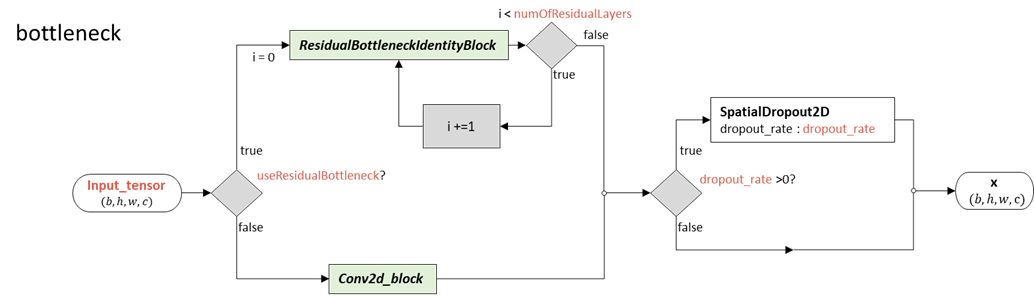

In [ ]:
def bottleneck(input_tensor, useResidualBottleNeck, n_bottleneck_blocks, useResidualConv2DBlock, kernels,split_kernels,numberOfConvs, activation , dropout_rate, channelList = None,useSpecNorm = False ):
  if channelList == None:
    ch = tf.keras.backend.int_shape(input_tensor)[-1]
    channelList = [ch for i in range(n_bottleneck_blocks)]

  x = input_tensor

  for ch in channelList:
    if useResidualBottleNeck:
      x = ResidualBottleneckIdentityBlock(input_tensor = x, activation = activation,n_filters=ch, kernels = kernels,numberOfBlocks=numberOfConvs,useSpecNorm=useSpecNorm)  
    else:
      x = conv2d_block(x, n_filters=ch, useResidualConv2DBlock = useResidualConv2DBlock, kernels = kernels, split_kernels = split_kernels,numberOfConvs=numberOfConvs,activation=activation,useSpecNorm=useSpecNorm)

  if dropout_rate > 0:
    x = dropout_func(channelList[-1], dropout_rate)(x)

  return x

#Testcode
#inputs = tf.keras.layers.Input(shape=(4,4,512))
#model = tf.keras.Model(inputs=inputs, outputs=bottleneck(inputs,True, 3, False, 3,False,1, GLOBAL_ACTIVATION , dropout_rate = 0.2, channelList = [512,256] ))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-7-3"></a>
### 4.7.3 Decoder

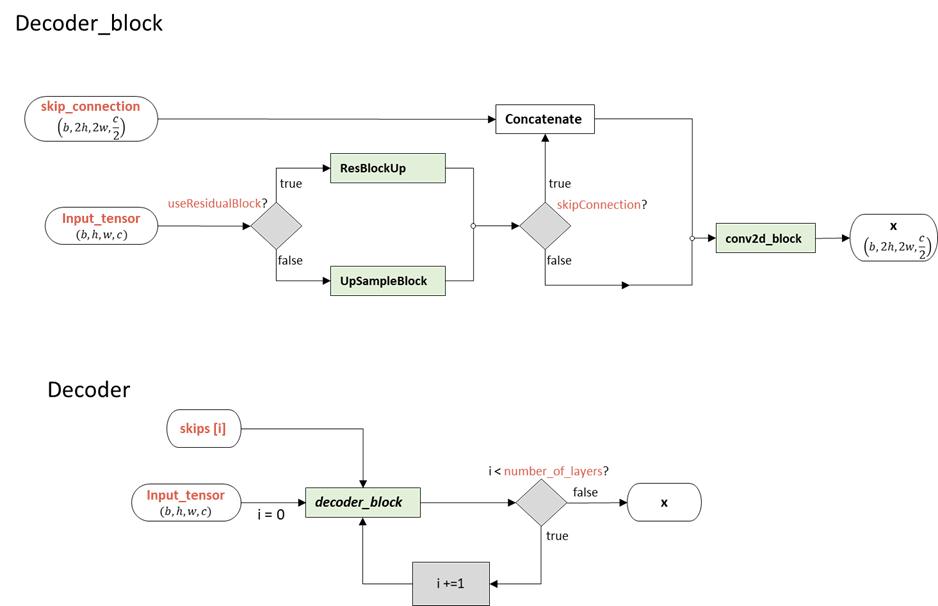

In [ ]:
def decoder_block(input_tensor, skipConnection, upsampling, n_filters, useResidualConv2DBlock, kernels, split_kernels, useResidualBlock,numberOfConvs,activation, dropout_rate,useSpecNorm, connect_skips = CONNECT_SKIPS):
  if useResidualBlock:
    x = ResBlockUp(input_tensor, NumberOfOutputChannel = n_filters,activation=activation,useSpecNorm=useSpecNorm)
  else:
    x = UpSampleBlock(input_tensor = input_tensor, numOfChannels = n_filters, kernels = kernels, upsampling = upsampling, split_kernels = split_kernels,activation=activation,useSpecNorm=useSpecNorm)
  
  if skipConnection != None: 
    if connect_skips == "add":
      x = tf.keras.layers.add([x, skipConnection])
    elif connect_skips == "concat":
      x = tf.keras.layers.concatenate([x, skipConnection])
    else:
      raise Exception("Cennection type:'{}' is not defined".format(connect_skips))

  if useResidualBlock:
    x = ResidualBottleneckIdentityBlock(x, n_filters =n_filters, activation = activation, kernels = kernels,numberOfBlocks=numberOfConvs,useSpecNorm=useSpecNorm,dropout_rate=dropout_rate)
  else:
    x = conv2d_block(x, n_filters,useResidualConv2DBlock=useResidualConv2DBlock, kernels = kernels,split_kernels=split_kernels, activation = activation,numberOfConvs=numberOfConvs, dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
  
  return x


def decoder(input_tensor,
            number_of_layers, 
            upsampling, 
            n_filters, 
            limit_n_filters, 
            useResidualConv2DBlock,
            kernels,
            split_kernels,
            numberOfConvs,
            activation, 
            dropout_rate, 
            skipConnection = None, 
            useResidualBlock = False,
            channelList = None, 
            useSpecNorm=USE_SPEC_NORM, 
            useSelfAttention=False):
  x = input_tensor

  if channelList == None:
    channelList = [min(n_filters * 2**i, limit_n_filters) for i in reversed(range(number_of_layers))]
  else:
    number_of_layers = len(channelList)

  for i, ch in enumerate(channelList):
    #number_of_filters = min(n_filters * 2**i, limit_n_filters)  #i=0 -> 64, i=1 -> 128, i=2 -> 256, ... Hint: Reversed! 
    if i < int(number_of_layers/2): # ">" since i is reversed
      dropout_rate = dropout_rate
    else:
      dropout_rate = 0
    height = tf.keras.backend.int_shape(x)[1]
    if height == 32 and useSelfAttention:
      x = SelfAttention(x)
    if skipConnection:
      x = decoder_block(x, skipConnection[number_of_layers - (i+1)], upsampling, n_filters = ch, useResidualConv2DBlock = useResidualConv2DBlock, kernels=kernels, split_kernels=split_kernels,useResidualBlock = useResidualBlock,numberOfConvs=numberOfConvs,activation=activation,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
    else:
      x = decoder_block(x, None, upsampling, n_filters = ch, useResidualConv2DBlock = useResidualConv2DBlock, kernels=kernels, split_kernels=split_kernels,useResidualBlock = useResidualBlock, numberOfConvs=numberOfConvs,activation=activation,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
    
  return x

#Testcode
#inputs = tf.keras.layers.Input(shape=(4,4,512))
#model = tf.keras.Model(inputs=inputs, outputs=decoder(inputs,3, GENERATOR_UPSAMPLING, 64, 512, False, 3, False,1,GLOBAL_ACTIVATION, 0.2, skipConnection = None, useResidualBlock = False, channelList = None))
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-8"></a>
## 4.8 Model Architectures 

<a name="4-8-1"></a>
### 4.8.1 U-Net Generator

Idea: http://arxiv.org/abs/1505.04597

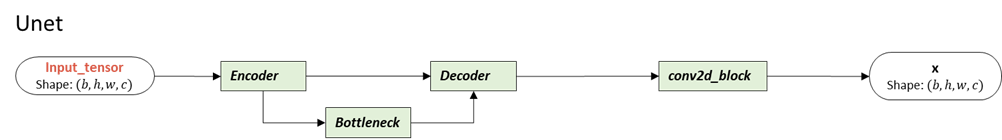

In [ ]:
def UNet(
    inputShape = IMG_SIZE, 
    number_of_layers = GENERATOR_UP_DOWN_LEVELS, 
    upsampling = GENERATOR_UPSAMPLING, 
    downsampling = GENERATOR_DOWNSAMPLING,  
    final_activation = FINAL_GENERATOR_ACTIVATION, 
    n_filters = GENERATOR_CONV_FILTERS, 
    kernels = GENERATOR_CONV_KERNELS,
    first_kernel = FIRST_GENERATOR_CONV_KERNEL,
    split_kernels = GENERATOR_SPLIT_KERNELS,
    numberOfConvs = GENERATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    limit_n_filters = 512, 
    useResidualConv2DBlock = False, 
    useResidualBottleNeck = False,
    useResidualBlock = False, 
    n_bottleneck_blocks = 1, 
    dropout_rate = DROPOUT_RATE, 
    useSpecNorm = USE_SPEC_NORM,
    name = None):

  # specify the input shape
  input_tensor = tf.keras.layers.Input(shape = inputShape)

  # feed the inputs to the encoder
  encoder_output, skipConnection = encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, 
                                           useResidualConv2DBlock, downsampling, kernels, split_kernels,
                                           numberOfConvs,activation, first_kernel,useResidualBlock,useSpecNorm=useSpecNorm)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, n_bottleneck_blocks, 
                           useResidualConv2DBlock, kernels, split_kernels,numberOfConvs, 
                           activation = activation, dropout_rate=dropout_rate,
                           useSpecNorm=useSpecNorm)

  # feed the bottleneck output and encoder block skip connections to the decoder
  decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, 
                           useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation,
                           dropout_rate, skipConnection,useResidualBlock,useSpecNorm=useSpecNorm,useSelfAttention=USE_SELF_ATTENTION)

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  outputs = conv2d_block(decoder_output, n_filters = inputShape[-1],useResidualConv2DBlock = False, kernels = 1, 
                         split_kernels  = False, numberOfConvs = 1, activation = final_activation,
                         useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  
  # create the model
  model = tf.keras.Model(inputs=input_tensor, outputs=outputs, name = name)

  return model

#Testcode
#model = UNet(first_kernel = 9,number_of_layers = 4, kernels = 3, numberOfConvs=3, downsampling = "conv_stride_2", upsampling = "depth_to_space", n_filters = 64, useResidualConv2DBlock = False, useResidualBottleNeck = False,useResidualBlock=False, n_bottleneck_blocks = 5, name = None,useSpecNorm = True)
#model = UNet()
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, show_dtype=True, to_file='Unet_model.png')


<a name="4-8-2"></a>
### 4.8.2 ResNet Generator

Idea taken from: https://arxiv.org/abs/1512.03385


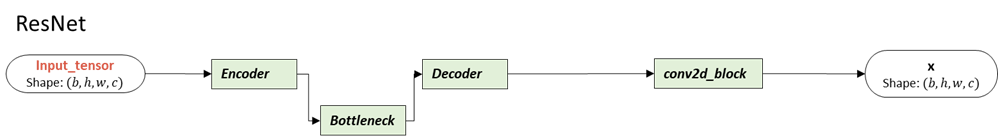

In [ ]:
def ResNet(
    inputShape = IMG_SIZE, 
    name = None, 
    n_filters=GENERATOR_CONV_FILTERS,  
    number_of_layers = GENERATOR_UP_DOWN_LEVELS, 
    split_kernels = GENERATOR_SPLIT_KERNELS,
    kernels = GENERATOR_CONV_KERNELS,
    first_kernel = FIRST_GENERATOR_CONV_KERNEL,
    numberOfConvs = GENERATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    final_activation = FINAL_GENERATOR_ACTIVATION,
    useResidualConv2DBlock = True,
    useResidualUpDownBlock = True,
    limit_n_filters = 512, 
    num_res_blocks = 5, 
    upsampling = GENERATOR_UPSAMPLING, 
    downsampling = GENERATOR_DOWNSAMPLING,
    dropout_rate = DROPOUT_RATE,
    useSpecNorm=USE_SPEC_NORM
    ):

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor

  # feed the inputs to the encoder
  encoder_output,_ = encoder(x, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels,numberOfConvs,activation,first_kernel,useResidualBlock=useResidualUpDownBlock,useSpecNorm=useSpecNorm)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output, useResidualUpDownBlock, num_res_blocks, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs , activation = activation,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)

  # feed the bottleneck and encoder block outputs to the decoder
  decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation,dropout_rate, useResidualBlock=useResidualUpDownBlock,useSpecNorm=useSpecNorm,useSelfAttention=USE_SELF_ATTENTION)

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  outputs = conv2d_block(decoder_output, n_filters = inputShape[-1],useResidualConv2DBlock = False, kernels = 1, split_kernels  = False, numberOfConvs = 1, activation = final_activation,useSpecNorm=useSpecNorm, applyFinalNormalization = False)

  return tf.keras.Model(inputs=input_tensor, outputs=outputs, name = name)

# Test Code
#model = ResNet(first_kernel = 3,number_of_layers=4,useResidualConv2DBlock = False,useResidualUpDownBlock=False)
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-8-3"></a>
### 4.8.3 PatchGAN Discriminator

The PatchGAN has been used in the Pix2Pix model: https://www.tensorflow.org/tutorials/generative/pix2pix

Instead of having only a single output classification of the discriminator, the PatchGAN, provides a prediction for several patches of the image

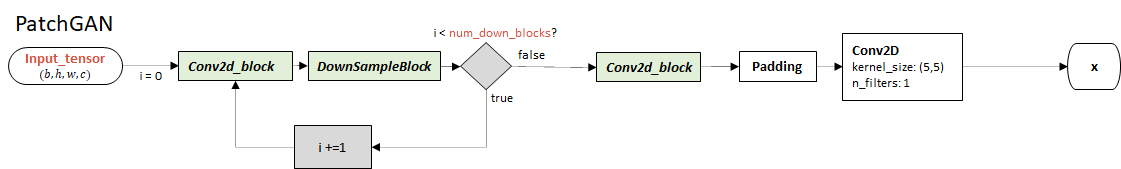

In [ ]:
def PatchGAN(
    inputShape = IMG_SIZE, 
    name = None, 
    n_filters = DISCRIMINATOR_CONV_FILTERS,
    downsampling = DISCRIMINATOR_DOWNSAMPLING, 
    kernels = DISCRIMINATOR_CONV_KERNELS,
    first_kernel = FIRST_DISCRIMINATOR_CONV_KERNEL,
    split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
    numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    num_down_blocks = 3,
    dropout_rate = DROPOUT_RATE,
    useSpecNorm=USE_SPEC_NORM
    ):

  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  x = input_tensor

  #Downsampling Blocks
  x ,_ = encoder(x, num_down_blocks, n_filters, 512, False, downsampling, kernels, split_kernels,numberOfConvs,activation,first_kernel,useSpecNorm=useSpecNorm,useSelfAttention=USE_SELF_ATTENTION)

  #increase channels while keeping spatial dimensions
  x = conv2d_block(x, n_filters = n_filters * (2**(num_down_blocks)), useResidualConv2DBlock = False, kernels = kernels, split_kernels = split_kernels, numberOfConvs = numberOfConvs, activation = activation,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  x = conv2d_block(x, n_filters = 1,useResidualConv2DBlock = False, kernels = 5, split_kernels  = False, numberOfConvs = 1, activation = "none",useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  
  return tf.keras.Model(inputs=input_tensor, outputs=x, name = name)

# Test Code
#model = PatchGAN(name = "PatchGAN")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-8-4"></a>
### 4.8.4 U-Net Discriminator
> Idea taken from: https://openaccess.thecvf.com/content_CVPR_2020/papers/Schonfeld_A_U-Net_Based_Discriminator_for_Generative_Adversarial_Networks_CVPR_2020_paper.pdf

> Git: https://github.com/boschresearch/unetgan 

> Clarifications of the paper: https://github.com/boschresearch/unetgan/blob/master/how_to_unetgan.pdf

The basic idea is to use a U-Net to generate a pixel-wise prediction (decoder output) and a global prediction (encoder output) in the discriminator to strengthen the discriminator. In that way, the generator can benefit from a better feedback of the discriminator

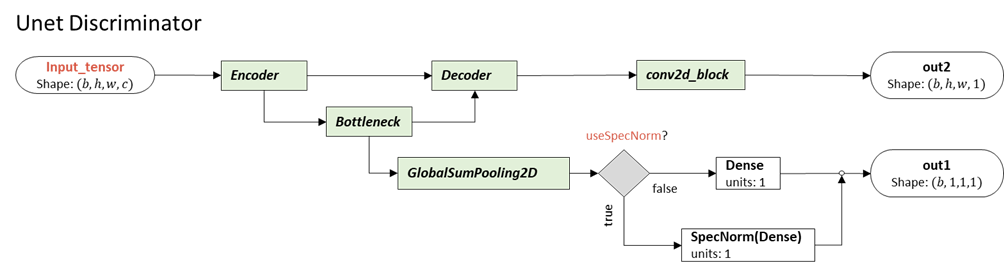

In [ ]:
DISC_VERSION = 'from_paper' #@param ["from_paper", "adapted"]

def UNetDiscriminator(
    inputShape = IMG_SIZE, 
    number_of_layers = DISCRIMINATOR_UP_DOWN_LEVELS,
    upsampling = DISCRIMINATOR_UPSAMPLING, 
    downsampling = DISCRIMINATOR_DOWNSAMPLING,
    kernels = DISCRIMINATOR_CONV_KERNELS,
    first_kernel = FIRST_DISCRIMINATOR_CONV_KERNEL,
    split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
    numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION, 
    useResidualConv2DBlock = False,
    useResidualUpDownBlock = False,
    limit_n_filters = 512,
    useResidualBottleNeck = False, 
    n_bottleneck_blocks = 1,
    useBottleneckIdentity = False,   
    n_filters = DISCRIMINATOR_CONV_FILTERS, 
    useSelfAttention = False,
    dropout_rate = DROPOUT_RATE, 
    name = None,
    useSpecNorm=USE_SPEC_NORM
    ):
  
  # Define functional API
  input_tensor = tf.keras.layers.Input(shape=inputShape)

  if DISC_VERSION == "from_paper":
    ch = DISCRIMINATOR_CONV_FILTERS
    # feed the inputs to the encoder
    encoder_output, skipConnections = encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels, split_kernels,numberOfConvs,activation,first_kernel, useResidualBlock=useResidualUpDownBlock, channelList=[ch,2*ch,4*ch,8*ch,8*ch], useSpecNorm=useSpecNorm,useSelfAttention=USE_SELF_ATTENTION)
    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, n_bottleneck_blocks, useResidualConv2DBlock, kernels, split_kernels, numberOfConvs, activation = activation,dropout_rate=dropout_rate, channelList=[16*ch], useSpecNorm=useSpecNorm)
    # feed the bottleneck and encoder block outputs to the decoder
    decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs,activation,dropout_rate, useResidualBlock=useResidualUpDownBlock, skipConnection= skipConnections, channelList=[8*ch,8*ch,4*ch,2*ch,ch], useSpecNorm=useSpecNorm)
  else:
    # feed the inputs to the encoder
    encoder_output, skipConnections = encoder(input_tensor, number_of_layers, n_filters, limit_n_filters, useResidualConv2DBlock, downsampling, kernels,split_kernels,numberOfConvs, activation,first_kernel, useResidualBlock=useResidualUpDownBlock,useSpecNorm=useSpecNorm,useSelfAttention=USE_SELF_ATTENTION)
    # feed the encoder output to the bottleneck
    bottle_neck = bottleneck(encoder_output, useResidualBottleNeck, n_bottleneck_blocks, useResidualConv2DBlock, kernels, split_kernels,numberOfConvs, activation = activation,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
    # feed the bottleneck and encoder block outputs to the decoder
    decoder_output = decoder(bottle_neck, number_of_layers, upsampling, n_filters, limit_n_filters, useResidualConv2DBlock, kernels, split_kernels, numberOfConvs,activation, dropout_rate, useResidualBlock=useResidualUpDownBlock, skipConnection= skipConnections,useSpecNorm=useSpecNorm)

  # Real/Fake Output
  out1 = bottle_neck
  out1 = GlobalSumPooling2D()(out1)  
  linear = tf.keras.layers.Dense(1, kernel_initializer = KERNEL_INIT,use_bias = True)
  if useSpecNorm:
    out1 = tfa.layers.SpectralNormalization(linear)(out1)
  else:
    out1 = linear(out1)

  # Conv layer before final layer (if tanh or sigmoid) gets the glorot Initializer!
  out2 = conv2d_block(decoder_output, n_filters = 1, useResidualConv2DBlock = False, kernels = 1, split_kernels  = False, numberOfConvs = 1, activation = "none",useSpecNorm=useSpecNorm, applyFinalNormalization = False)

  return tf.keras.Model(inputs=input_tensor, outputs=[out1, out2], name = name)

# Test Code
#model = UNetDiscriminator(name = "UNetDiscriminator")
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-8-5"></a>
### 4.8.5 One-Shot Discriminator

Inspired by: http://arxiv.org/abs/2103.13389 



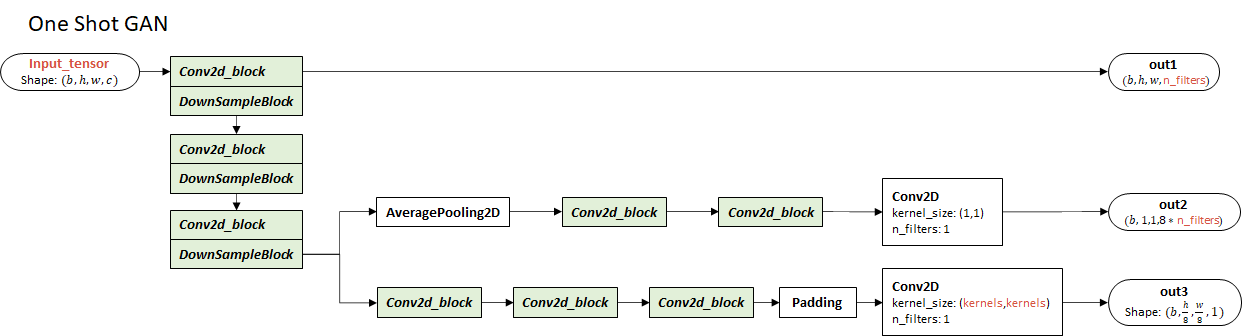

In [ ]:
def OneShotDiscriminator(
    inputShape = IMG_SIZE, 
    n_filters = GENERATOR_CONV_FILTERS,
    downsampling = DISCRIMINATOR_DOWNSAMPLING, 
    kernels = DISCRIMINATOR_CONV_KERNELS,
    first_kernel = FIRST_DISCRIMINATOR_CONV_KERNEL,
    split_kernels = DISCRIMINATOR_SPLIT_KERNELS,
    numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK,
    activation = GLOBAL_ACTIVATION,
    dropout_rate = DROPOUT_RATE,
    name = None,
    useSpecNorm=USE_SPEC_NORM
    ):
  input_tensor = tf.keras.layers.Input(shape=inputShape)
  

  #----------------------
  # Low Level Features
  #----------------------
  feat_0 = conv2d_block(input_tensor, n_filters=n_filters, useResidualConv2DBlock =  False, kernels = first_kernel,split_kernels = split_kernels,numberOfConvs=numberOfConvs, activation = activation,dropout_rate=0, final_activation=False,useSpecNorm=useSpecNorm, applyFinalNormalization = False)
  out1 = feat_0
  
  # add missing activation and normalization from previous layer
  feat_0 = tfa.layers.InstanceNormalization(gamma_initializer = GAMMA_INIT)(feat_0)
  feat_0 = activation_func(activation)(feat_0)
  down_0 = DownSampleBlock(input_tensor = feat_0, numOfChannels =  n_filters*2, downsampling = downsampling,kernels = kernels, activation = activation,useSpecNorm=useSpecNorm)
  feat_1, down_1 = encoder_block(down_0, n_filters=n_filters*4, useResidualConv2DBlock=False, downsampling= downsampling, kernels = kernels, split_kernels=False, useResidualBlock=False, numberOfConvs=numberOfConvs, activation=activation,useSpecNorm=useSpecNorm,dropout_rate=0)
  feat_2, F = encoder_block(down_1, n_filters=n_filters*8, useResidualConv2DBlock=False, downsampling= downsampling, kernels = kernels, split_kernels=False, useResidualBlock=False, numberOfConvs=numberOfConvs, activation=activation,useSpecNorm=useSpecNorm,dropout_rate=0)
  if USE_SELF_ATTENTION:
    F = SelfAttention(F)
  
  #----------------------
  # Content Features
  #----------------------
  pool_height, pool_width = tf.keras.backend.int_shape(F)[-3:-1] #get height an dwidth of last layer.
  #pool_height = 64
  #if CROP_TO_512_256:
  #  pool_width = 32
  #else:
  #  pool_width = 64
  F_cont = tf.keras.layers.AveragePooling2D(pool_size=(pool_height, pool_width))(F)
  cont_0 = conv2d_block(F_cont, n_filters=n_filters * 8, kernels = 1, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
  cont_1 = conv2d_block(cont_0, n_filters=n_filters * 8, kernels = 1, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
  cont_2 = conv2d_block(cont_1, n_filters=n_filters * 8, kernels = 1, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=0,useSpecNorm=useSpecNorm, final_activation=False, applyFinalNormalization = False)
  out2 = cont_2

  #----------------------
  # Layout Features
  #----------------------
  F_lay = conv2d_block(F, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=0,useSpecNorm=useSpecNorm)
  lay_0 = conv2d_block(F_lay, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
  lay_1 = conv2d_block(lay_0, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=dropout_rate,useSpecNorm=useSpecNorm)
  lay_2 = conv2d_block(lay_1, n_filters=1, kernels = kernels, activation = activation, split_kernels = split_kernels,numberOfConvs=numberOfConvs, useResidualConv2DBlock=False,dropout_rate=0,useSpecNorm=useSpecNorm,final_activation=False, applyFinalNormalization = False)
  out3 =lay_2

  return tf.keras.Model(inputs=input_tensor, outputs=[out1, out2, out3], name = name)

# Testcode
#model = OneShotDiscriminator()
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<a name="4-8-6"></a>
### 4.8.6 VoloGAN

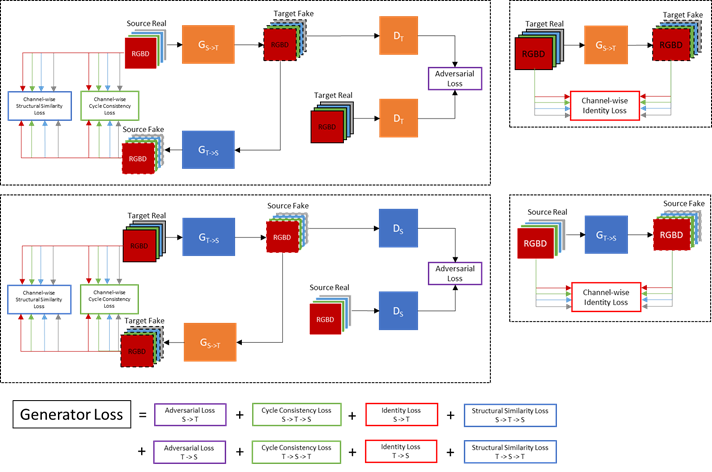

In [ ]:
class VoloGAN(tf.keras.Model):
  def __init__(self, generator_T, generator_S, discriminator_T, discriminator_S, lambda_cycle, lambda_identity, lambda_ssim, useCutmix = DISCRIMINATOR_CUTMIX, cutmixProbability = CUTMIX_PROBABILITY):
    super(VoloGAN, self).__init__()
    
    self.modelType = "VoloGAN"
    self.generator_S_to_T = generator_T
    self.generator_T_to_S = generator_S
    self.discriminator_S = discriminator_S
    self.discriminator_T = discriminator_T
    self.lambda_cycle = lambda_cycle
    self.lambda_identity = lambda_identity
    self.lambda_ssim = lambda_ssim
    self.useCutmix = useCutmix
    self.cutmixProbability = cutmixProbability

  # To reduce python overhead, and maximize the performance of your TPU, try out the experimental experimental_steps_per_execution argument to Model.compile. Here it increases throughput by about 50%:
  # https://www.tensorflow.org/guide/tpu#train_a_model_using_keras_high_level_apis 

  def compile(self, generator_S_to_T_optimizer, generator_T_to_S_optimizer, discriminator_S_optimizer, discriminator_T_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn, ssim_loss_fn):
    super(VoloGAN, self).compile()
    #super(VoloGAN, self).compile(steps_per_execution = 64)
    self.generator_S_to_T_optimizer = generator_S_to_T_optimizer
    self.generator_T_to_S_optimizer = generator_T_to_S_optimizer
    self.discriminator_S_optimizer = discriminator_S_optimizer
    self.discriminator_T_optimizer = discriminator_T_optimizer
    self.generator_loss_fn = gen_loss_fn
    self.discriminator_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn
    self.ssim_loss_fn = ssim_loss_fn

  def compileOptimizer(self, generator_S_to_T_optimizer, generator_T_to_S_optimizer, discriminator_S_optimizer, discriminator_T_optimizer):
    super(VoloGAN, self).compile()
    #super(VoloGAN, self).compile(steps_per_execution = 64)
    self.generator_S_to_T_optimizer = generator_S_to_T_optimizer
    self.generator_T_to_S_optimizer = generator_T_to_S_optimizer
    self.discriminator_S_optimizer = discriminator_S_optimizer
    self.discriminator_T_optimizer = discriminator_T_optimizer

  def call(self, batch):
    input_S, input_T = batch
    generated_T = self.generator_S_to_T(input_S)
    generated_S = self.generator_T_to_S(input_T)
    discriminated_T = self.discriminator_T(input_T)
    discriminated_S = self.discriminator_S(input_S)
    return tf.stack([generated_T, generated_S, discriminated_T, discriminated_S])

  def print_summary(self):
    def getNumberOfElements(listOfLayers):
      numElements = 0
      for layer in listOfLayers:
        numElements += tf.reduce_prod(layer.shape)
      return numElements

    summaryString = ""
    summaryString += "--------------------------------------------------\n"
    summaryString += "---------------- Summary Cycle GAN ---------------\n"
    summaryString += "--------------------------------------------------\n"
    
    summaryString += "\n"
    summaryString += self.generator_S_to_T.name + ":\n"
    gen1_total = getNumberOfElements(self.generator_S_to_T.variables)
    gen1_trainable = getNumberOfElements(self.generator_S_to_T.trainable_variables)
    gen1_nonTrainable = gen1_total - gen1_trainable
    summaryString += "  Total Variables: {:,}\n".format(gen1_total)
    summaryString += "  Trainable Variables: {:,}\n".format(gen1_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(gen1_nonTrainable)

    summaryString += "\n"
    summaryString += self.generator_T_to_S.name + ":\n"
    gen2_total = getNumberOfElements(self.generator_T_to_S.variables)
    gen2_trainable = getNumberOfElements(self.generator_T_to_S.trainable_variables)
    gen2_nonTrainable = gen2_total - gen2_trainable
    summaryString += "  Total Variables: {:,}\n".format(gen2_total)
    summaryString += "  Trainable Variables: {:,}\n".format(gen2_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(gen2_nonTrainable)

    summaryString += "\n"
    summaryString += self.discriminator_T.name + ":\n"
    disc1_total = getNumberOfElements(self.discriminator_T.variables)
    disc1_trainable = getNumberOfElements(self.discriminator_T.trainable_variables)
    disc1_nonTrainable = disc1_total - disc1_trainable
    summaryString += "  Total Variables: {:,}\n".format(disc1_total)
    summaryString += "  Trainable Variables: {:,}\n".format(disc1_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(disc1_nonTrainable)

    summaryString += "\n"
    summaryString += self.discriminator_S.name + ":\n"
    disc2_total = getNumberOfElements(self.discriminator_S.variables)
    disc2_trainable = getNumberOfElements(self.discriminator_S.trainable_variables)
    disc2_nonTrainable = disc2_total - disc2_trainable
    summaryString += "  Total Variables: {:,}\n".format(disc2_total)
    summaryString += "  Trainable Variables: {:,}\n".format(disc2_trainable)
    summaryString += "  Non-trainable Variables: {:,}\n".format(disc2_nonTrainable)

    summaryString += "_________________________________________________\n"

    voloGAN_total = gen1_total + gen2_total + disc1_total + disc2_total
    voloGAN_trainable = gen1_trainable + gen2_trainable + disc1_trainable + disc2_trainable
    voloGAN_nonTrainable = gen1_nonTrainable + gen2_nonTrainable + disc1_nonTrainable + disc2_nonTrainable
    summaryString += "Total Variables: {:,}\n".format(voloGAN_total)
    summaryString += "Trainable Variables: {:,}\n".format(voloGAN_trainable)
    summaryString += "Non-trainable Variables: {:,}\n".format(voloGAN_nonTrainable)

    summaryString += "_________________________________________________\n"

    print(summaryString)

    return summaryString

  def train_step(self, batch_train):
    real_S, real_T = batch_train

    # For VoloGAN, we need to calculate different
    # kinds of losses for the generators and discriminators.
    # We will perform the following steps here:
    #
    # 1. Pass real images through the generators and get the generated images
    # 2. Pass the generated images back to the generators to check if we
    #    we can predict the original image from the generated image.
    # 3. Do an identity mapping of the real images using the generators.
    # 4. Pass the generated images in 1) to the corresponding discriminators.
    # 5. Calculate the generators total loss (adverserial + cycle + identity)
    # 6. Calculate the discriminators loss
    # 7. Update the weights of the generators
    # 8. Update the weights of the discriminators
    # 9. Return the losses in a dictionary

    with tf.GradientTape(persistent=True) as tape:
      # Generating fakes
      generated_T = self.generator_S_to_T(real_S, training=True)
      generated_S = self.generator_T_to_S(real_T, training=True)

      # Cycle mapping
      cycled_S = self.generator_T_to_S(generated_T, training=True)
      cycled_T = self.generator_S_to_T(generated_S, training=True)

      # Identity mapping
      same_S = self.generator_T_to_S(real_S, training=True)
      same_T = self.generator_S_to_T(real_T, training=True)

      if DISCRIMINATOR_DESIGN == 'PatchGAN':
        # Discriminator output
        disc_real_S = self.discriminator_S(real_S, training=True)
        disc_generated_S = self.discriminator_S(generated_S, training=True)

        disc_real_T = self.discriminator_T(real_T, training=True)
        disc_generated_T = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S)

      elif DISCRIMINATOR_DESIGN == 'UNet':
        # Discriminator output
        disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=True)
        disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=True)
        disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=True)
        disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=True)
        
        if self.useCutmix and np.random.uniform(0,1) < self.cutmixProbability:
          batch_size, height, width, channel = rgbd_synthetic.shape
          mixing_mask = GetCutmixMask(batch_size, height, width, channel)
          _, cutmix_S = CutMix(real_S, generated_S, ignoreBackground = True, mixing_mask=mixing_mask)
          _, cutmix_T = CutMix(real_T, generated_T, ignoreBackground = True, mixing_mask=mixing_mask)
          
          #calculate discriminator output of cutmix images. Only decoder output relevant!
          _, disc_cutmix_S = self.discriminator_S(cutmix_S, training=True)
          _, disc_cutmix_T = self.discriminator_T(cutmix_T, training=True)

          #calculate cutmix of discriminator output
          _, cutmix_disc_S = CutMix(disc_real_S_decoder, disc_generated_S_decoder, ignoreBackground = True, mixing_mask=mixing_mask)
          _, cutmix_disc_T = CutMix(disc_real_T_decoder, disc_generated_T_decoder, ignoreBackground = True, mixing_mask=mixing_mask)

        else:
          disc_cutmix_S = None
          disc_cutmix_T = None
          cutmix_disc_S = None
          cutmix_disc_T = None

          
        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_encoder, disc_real_S_decoder, disc_generated_S_encoder, disc_generated_S_decoder, disc_cutmix_S,cutmix_disc_S)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_encoder, disc_real_T_decoder, disc_generated_T_encoder, disc_generated_T_decoder, disc_cutmix_T,cutmix_disc_T)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_encoder, disc_generated_T_decoder)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_encoder, disc_generated_S_decoder)


      elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
        # Discriminator output
        disc_real_S_low_level, disc_real_S_layout, disc_real_S_content  = self.discriminator_S(real_S, training=True)
        disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content = self.discriminator_S(generated_S, training=True)

        disc_real_T_low_level, disc_real_T_layout, disc_real_T_content = self.discriminator_T(real_T, training=True)
        disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content = self.discriminator_T(generated_T, training=True)

        # Discriminator loss
        discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_low_level, disc_real_S_layout, disc_real_S_content, disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)
        discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_low_level, disc_real_T_layout, disc_real_T_content, disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)

        # Generator adverserial loss
        generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)
        generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)

      else:
        raise Exception("Discriminator is not Defined")

      # Generator cycle loss
      cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
      cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

      # Generator identity loss
      id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
      id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

      # Generator SSIM Loss
      ssim_loss_T = self.ssim_loss_fn(real_T, cycled_T) * self.lambda_ssim
      ssim_loss_S = self.ssim_loss_fn(real_S, cycled_S) * self.lambda_ssim

      # Total generator loss
      total_gen_loss_T = generator_S_to_T_loss + cycle_loss_T + id_loss_T + ssim_loss_T
      total_gen_loss_S = generator_T_to_S_loss + cycle_loss_S + id_loss_S + ssim_loss_S

    # Get the gradients for the generators
    grads_T = tape.gradient(total_gen_loss_T, self.generator_S_to_T.trainable_variables)
    grads_S = tape.gradient(total_gen_loss_S, self.generator_T_to_S.trainable_variables)

    # Get the gradients for the discriminators
    discriminator_S_grads = tape.gradient(discriminator_S_loss, self.discriminator_S.trainable_variables)
    discriminator_T_grads = tape.gradient(discriminator_T_loss, self.discriminator_T.trainable_variables)

    # Update the weights of the generators
    self.generator_S_to_T_optimizer.apply_gradients(
      zip(grads_T, self.generator_S_to_T.trainable_variables)
    )
    self.generator_T_to_S_optimizer.apply_gradients(
      zip(grads_S, self.generator_T_to_S.trainable_variables)
    )

    # Update the weights of the discriminators
    self.discriminator_S_optimizer.apply_gradients(
      zip(discriminator_S_grads, self.discriminator_S.trainable_variables)
    )
    self.discriminator_T_optimizer.apply_gradients(
      zip(discriminator_T_grads, self.discriminator_T.trainable_variables)
    )
    return [total_gen_loss_T, total_gen_loss_S, discriminator_T_loss, discriminator_S_loss, generator_S_to_T_loss, generator_T_to_S_loss, cycle_loss_T, cycle_loss_S, id_loss_T, id_loss_S, ssim_loss_T, ssim_loss_S]

    
  def test_step(self, batch_test):
    real_S, real_T = batch_test

    # Generate fakes
    generated_T = self.generator_S_to_T(real_S, training=False)
    generated_S = self.generator_T_to_S(real_T, training=False)

    # Cycle mapping
    cycled_S = self.generator_T_to_S(generated_T, training=False)
    cycled_T = self.generator_S_to_T(generated_S, training=False)

    # Identity mapping
    same_S = self.generator_T_to_S(real_S, training=False)
    same_T = self.generator_S_to_T(real_T, training=False)

    if DISCRIMINATOR_DESIGN == 'PatchGAN':
      # Discriminator output
      disc_real_S = self.discriminator_S(real_S, training=False)
      disc_generated_S = self.discriminator_S(generated_S, training=False)

      disc_real_T = self.discriminator_T(real_T, training=False)
      disc_generated_T = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S, disc_generated_S)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T, disc_generated_T)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S)

    elif DISCRIMINATOR_DESIGN == 'UNet':
      # Discriminator output
      disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=False)
      disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=False)
      disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=False)
      disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=False)

      # Discriminator loss -> No Cutmix Regularization during Test!
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_encoder, disc_real_S_decoder, disc_generated_S_encoder, disc_generated_S_decoder, None, None)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_encoder, disc_real_T_decoder, disc_generated_T_encoder, disc_generated_T_decoder, None, None)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_encoder, disc_generated_T_decoder)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_encoder, disc_generated_S_decoder)


    elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
      # Discriminator output

      disc_real_S_low_level, disc_real_S_layout, disc_real_S_content  = self.discriminator_S(real_S, training=False)
      disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content = self.discriminator_S(generated_S, training=False)

      disc_real_T_low_level, disc_real_T_layout, disc_real_T_content = self.discriminator_T(real_T, training=False)
      disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content = self.discriminator_T(generated_T, training=False)

      # Discriminator loss
      discriminator_S_loss = self.discriminator_loss_fn(disc_real_S_low_level, disc_real_S_layout, disc_real_S_content, disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)
      discriminator_T_loss = self.discriminator_loss_fn(disc_real_T_low_level, disc_real_T_layout, disc_real_T_content, disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)

      # Generator adverserial loss
      generator_S_to_T_loss = self.generator_loss_fn(disc_generated_T_low_level, disc_generated_T_layout, disc_generated_T_content)
      generator_T_to_S_loss = self.generator_loss_fn(disc_generated_S_low_level, disc_generated_S_layout, disc_generated_S_content)

    else:
      raise Exception("Discriminator is not Defined")

    # Generator cycle loss
    cycle_loss_T = self.cycle_loss_fn(real_T, cycled_T) * self.lambda_cycle
    cycle_loss_S = self.cycle_loss_fn(real_S, cycled_S) * self.lambda_cycle

    # Generator identity loss
    id_loss_T = self.identity_loss_fn(real_T, same_T) * self.lambda_identity
    id_loss_S = self.identity_loss_fn(real_S, same_S) * self.lambda_identity

    # Generator SSIM Loss
    ssim_loss_T = self.ssim_loss_fn(real_T, cycled_T) * self.lambda_ssim
    ssim_loss_S = self.ssim_loss_fn(real_S, cycled_S) * self.lambda_ssim

    # Total generator loss
    total_gen_loss_T = generator_S_to_T_loss + cycle_loss_T + id_loss_T + ssim_loss_T
    total_gen_loss_S = generator_T_to_S_loss + cycle_loss_S + id_loss_S + ssim_loss_S

    return [total_gen_loss_T, total_gen_loss_S, discriminator_T_loss, discriminator_S_loss, generator_S_to_T_loss, generator_T_to_S_loss, cycle_loss_T, cycle_loss_S, id_loss_T, id_loss_S, ssim_loss_T, ssim_loss_S]

  #IDEA OF THIS METHOD: Show input and output of the generators, show the classification of the discriminator
  def ShowInferenceValidation(self, real_S, real_T, writeToTensorboard = False, log_dir = None, epoch = None):

    # Synthetic to target domain
    generated_T = self.generator_S_to_T(real_S, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = generated_T[0,...], writeToTensorboard = writeToTensorboard, log_dir = log_dir, plot_title = "Synthetic -> Target", save_str="Target_Generator/S_T", epoch = epoch)

    # target to synthetic domain
    generated_S = self.generator_T_to_S(real_T, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = generated_S[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Target -> Synthetic", save_str="Synthetic_Generator/T_S", epoch = epoch)

    # Cycle synthetic -> target -> synthetic
    cycled_S = self.generator_T_to_S(generated_T, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = cycled_S[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Synthetic -> Target -> Synthetic", save_str="Synthetic_Generator/S_T_S", epoch = epoch)

    # Cycle target -> synthetic -> target
    cycled_T = self.generator_S_to_T(generated_S, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = cycled_T[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Target -> Synthetic -> Target", save_str="Target_Generator/T_S_T", epoch = epoch)

    # Identity mapping Synthetic -> Synthetic
    same_S = self.generator_T_to_S(real_S, training=False)
    Plot_generator_prediction(input = real_S.astype(np.float32)[0,...], prediction = same_S[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Synthetic -> Synthetic", save_str="Synthetic_Generator/S_S", epoch = epoch)

    # Identity mapping Target -> Target
    same_T = self.generator_S_to_T(real_T, training=False)
    Plot_generator_prediction(input = real_T.astype(np.float32)[0,...], prediction = same_T[0,...], writeToTensorboard = writeToTensorboard,log_dir = log_dir, plot_title = "Target -> Target",save_str="Target_Generator/T_T", epoch = epoch)

    if False:
      step = 8
      PlotPointCloud(generated_T[0,...], step, writeToTensorboard = True, log_dir = log_dir, save_str = "Target_Generator/point_cloud", title = "Point Cloud generated_T", epoch = epoch)
      PlotPointCloud(generated_S[0,...], step, writeToTensorboard = True, log_dir = log_dir, save_str = "Synthetic_Generator/point_cloud", title = "Point Cloud generated_S", epoch = epoch)

    if DISCRIMINATOR_DESIGN == 'PatchGAN':
      # Discriminator output
      disc_real_S = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S,plot_title ="Synthetic Discriminator Real Synthetic Input", save_str="Synthetic_Discriminator/R_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_generated_S = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S,plot_title ="Synthetic Discriminator Fake Synthetic Input", save_str="Synthetic_Discriminator/F_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_real_T = self.discriminator_T(real_T, training=False)
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T,plot_title ="Target Discriminator Real Target Input", save_str="Target_Discriminator/R_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_generated_T = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T,plot_title ="Target Discriminator Fake Target Input", save_str="Target_Discriminator/F_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

    elif DISCRIMINATOR_DESIGN == 'UNet':
      # Discriminator output
      disc_real_S_encoder, disc_real_S_decoder = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S_decoder, plot_title ="Synthetic Discriminator Real Synthetic Input", save_str="Synthetic_Discriminator/R_S", global_prediction = disc_real_S_encoder, writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_generated_S_encoder, disc_generated_S_decoder  = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S_decoder, plot_title ="Synthetic Discriminator Fake Synthetic Input", save_str="Synthetic_Discriminator/F_S", global_prediction = disc_generated_S_encoder, writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_real_T_encoder, disc_real_T_decoder = self.discriminator_T(real_T, training=False)  
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T_decoder, plot_title ="Target Discriminator Real Target Input", save_str="Target_Discriminator/R_T", global_prediction = disc_real_T_encoder, writeToTensorboard = writeToTensorboard, log_dir = log_dir,epoch = epoch)

      disc_generated_T_encoder, disc_generated_T_decoder = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T_decoder,plot_title ="Target Discriminator Fake Target Input", save_str="Target_Discriminator/F_T", global_prediction = disc_generated_T_encoder, writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)
  
    elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
      #only the layout output is plotted
      disc_real_S = self.discriminator_S(real_S, training=False)
      Plot_discriminator_prediction(real_S.astype(np.float32)[0,...], disc_real_S[-1],plot_title ="Synthetic Discriminator Real Synthetic Input (Layout Loss)", save_str="Synthetic_Discriminator/R_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_generated_S = self.discriminator_S(generated_S, training=False)
      Plot_discriminator_prediction(generated_S[0,...], disc_generated_S[-1],plot_title ="Synthetic Discriminator Fake Synthetic Input (Layout Loss)", save_str="Synthetic_Discriminator/F_S", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_real_T = self.discriminator_T(real_T, training=False)
      Plot_discriminator_prediction(real_T.astype(np.float32)[0,...], disc_real_T[-1],plot_title ="Target Discriminator Real Target Input (Layout Loss)", save_str="Target_Discriminator/R_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

      disc_generated_T = self.discriminator_T(generated_T, training=False)
      Plot_discriminator_prediction(generated_T[0,...], disc_generated_T[-1],plot_title ="Target Discriminator Fake Target Input (Layout Loss)", save_str="Target_Discriminator/F_T", writeToTensorboard = writeToTensorboard,log_dir = log_dir, epoch = epoch)

    else:
        raise Exception("Discriminator is not Defined")
    

  @tf.function
  def distributed_train_step(self, batch_train):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.train_step, args=(batch_train,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  @tf.function
  def distributed_test_step(self, batch_test):
    ''' 
    per_replica_loss_vector:  vector of shape [per_replica-loss_gen1, per_replica-loss_gen2, per_replica-loss_disc1, per_replica-loss_disc1]
    reduced_loss_vector:      Vector of results of the different devices (for TPU 8)
    
    '''
    per_replica_loss_vector = strategy.run(self.test_step, args=(batch_test,))

    #reduce the result of the replicas for every loss value returned!
    reduced_loss_vector = []
    for per_replica_loss in per_replica_loss_vector:
      reduced_loss_vector.append(strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None))
    
    return reduced_loss_vector

  def Save_Submodels(self, baseDirectory):
    '''
    Saves each of the models containing the current weights.
    save_option is required to save models in distributed strategy with tpu othervise there is no acces to the local filesystem.
    '''
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    self.generator_T_to_S.save(os.path.join(baseDirectory, "generator_T_to_S"), options = save_options)
    self.generator_S_to_T.save(os.path.join(baseDirectory, "generator_S_to_T"), options = save_options)
    self.discriminator_S.save(os.path.join(baseDirectory, "discriminator_S"), options = save_options)
    self.discriminator_T.save(os.path.join(baseDirectory, "discriminator_T"), options = save_options)


  def Load_Model(self, path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S, print_summary = False):
    '''
    loads each of the models containing the saved weights.
    load_option is required to save models in distributed strategy with tpu othervise there is no acces to the local filesystem.
    '''
    load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    self.generator_S_to_T = tf.keras.models.load_model(path_generator_S_to_T, options=load_options)
    self.generator_T_to_S = tf.keras.models.load_model(path_generator_T_to_S, options=load_options)
    self.discriminator_T = tf.keras.models.load_model(path_discriminator_T, options=load_options)
    self.discriminator_S = tf.keras.models.load_model(path_discriminator_S, options=load_options)

    if print_summary:
      self.generator_S_to_T.summary()
      self.generator_T_to_S.summary()
      self.discriminator_T.summary()
      self.discriminator_S.summary()

  #def Save_Checkpoint(self, epoch):
    #self.generator_S_to_T.save_weights("generator_S_to_T")
    #self.generator_T_to_S.save_weights("generator_T_to_S")
    #self.discriminator_T.save_weights("discriminator_T")
    #self.discriminator_S.save_weights("discriminator_S")

  #def Load_Checkpoint(self, path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S):
  #  self.generator_S_to_T.load_weight(path_generator_S_to_T)
  #  self.generator_T_to_S.load_weight(path_generator_T_to_S)
  #  self.discriminator_T.load_weight(path_discriminator_T)
  #  self.discriminator_S.load_weight(path_discriminator_S)

<a name="5"></a>
# 5 - Training the Model


<a name="5-1"></a>
## 5.1 Model Preparation

In [ ]:
def getVoloGANModel(
    generator_Design, 
    discriminator_Design, 
    inputShape,  
    n_gen_layers, 
    upsampling_gen,
    downsampling_gen, 
    upsampling_disc, 
    downsampling_disc, 
    n_filters_gen, 
    n_filters_disc, 
    activation, 
    dropout_rate,
    gen_kernels,
    disc_kernels,
    gen_numberOfConvs,
    disc_numberOfConvs
    ):
  
  #Define Generator, based on Notebook Settings
  if generator_Design == 'ResNet':
    generator_T = ResNet(inputShape = inputShape, name = "Generator_T_ResNet", numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, n_filters=n_filters_gen,  number_of_layers = n_gen_layers, num_res_blocks = 3, upsampling = upsampling_gen, downsampling = downsampling_gen,activation=activation,dropout_rate=dropout_rate) # n_filters=64,  num_up_down_blocks = 4, num_res_blocks = 16
    generator_S = ResNet(inputShape = inputShape, name = "Generator_S_ResNet", numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, n_filters=n_filters_gen,  number_of_layers = n_gen_layers, num_res_blocks = 3, upsampling = upsampling_gen, downsampling = downsampling_gen,activation=activation,dropout_rate=dropout_rate)
  elif generator_Design == 'UNet':
    generator_T = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, upsampling = upsampling_gen, downsampling = downsampling_gen, n_filters = n_filters_gen, name = "Generator_T_UNet",activation=activation,dropout_rate=dropout_rate) #number_of_layers = 3, n_filters = 64 # Gute performance: number_of_layers = 5, useUpsampleLayer = True, n_filters = 16
    generator_S = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, upsampling = upsampling_gen, downsampling = downsampling_gen, n_filters = n_filters_gen, name = "Generator_S_UNet",activation=activation,dropout_rate=dropout_rate)#number_of_layers = 3, n_filters = 64
  elif generator_Design == 'UNet_risidual_bottleneck':
    generator_T = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, upsampling = upsampling_gen, downsampling = downsampling_gen, n_filters = n_filters_gen, useResidualBottleNeck = True, n_bottleneck_blocks = 3, useBottleneckIdentity = True,dropout_rate=dropout_rate, name = "Generator_T_UNet_risidual_bottleneck",activation=activation)#n_filters = 64
    generator_S = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, upsampling = upsampling_gen, downsampling = downsampling_gen, n_filters = n_filters_gen, useResidualBottleNeck = True, n_bottleneck_blocks = 3, useBottleneckIdentity = True,dropout_rate=dropout_rate, name = "Generator_S_UNet_risidual_bottleneck",activation=activation)#n_filters = 64
  elif generator_Design == 'UNet_risidual_blocks':
    generator_T = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, upsampling = upsampling_gen, downsampling = downsampling_gen, n_filters = n_filters_gen,useResidualConv2DBlock = True, useResidualBlock = False, useResidualBottleNeck = False, n_bottleneck_blocks = 1, dropout_rate=dropout_rate, name = "Generator_T_UNet_risidual_block",activation=activation) #number_of_layers = 3, n_filters = 64
    generator_S = UNet(inputShape = inputShape, number_of_layers = n_gen_layers, numberOfConvs = gen_numberOfConvs, kernels = gen_kernels, upsampling = upsampling_gen, downsampling = downsampling_gen, n_filters = n_filters_gen,useResidualConv2DBlock = True, useResidualBlock = False, useResidualBottleNeck = False, n_bottleneck_blocks = 1, dropout_rate=dropout_rate, name = "Generator_S_UNet_risidual_block",activation=activation)#number_of_layers = 3, n_filters = 64
  else:
    raise Exception("Generator:{} is not defined".format(generator_Design))
  
  #Define Discriminator, based on Notebook Settings
  if discriminator_Design == 'PatchGAN':
    discriminator_T = PatchGAN(inputShape = inputShape, numberOfConvs = disc_numberOfConvs, kernels = disc_kernels, n_filters = n_filters_disc, num_down_blocks = 3, downsampling = downsampling_disc, name = "Discriminator_T_PatchGAN",activation=activation,dropout_rate=dropout_rate) # n_filters = 64, num_down_blocks = 3 #low params: n_filters = 4, num_down_blocks = 3
    discriminator_S = PatchGAN(inputShape = inputShape, numberOfConvs = disc_numberOfConvs, kernels = disc_kernels, n_filters = n_filters_disc, num_down_blocks = 3, downsampling = downsampling_disc, name = "Discriminator_S_PatchGAN",activation=activation,dropout_rate=dropout_rate)
  elif discriminator_Design == 'UNet':
    discriminator_T = UNetDiscriminator( name = "Discriminator_T_UNet", numberOfConvs = disc_numberOfConvs, kernels = disc_kernels, n_filters = n_filters_disc, upsampling = upsampling_disc, downsampling = downsampling_disc, useSelfAttention = False,activation=activation,dropout_rate=dropout_rate)
    discriminator_S = UNetDiscriminator( name = "Discriminator_S_UNet", numberOfConvs = disc_numberOfConvs, kernels = disc_kernels, n_filters = n_filters_disc, upsampling = upsampling_disc, downsampling = downsampling_disc, useSelfAttention = False,activation=activation,dropout_rate=dropout_rate)
  elif discriminator_Design == 'OneShot_GAN':
    discriminator_T = OneShotDiscriminator(inputShape = inputShape, numberOfConvs = disc_numberOfConvs, kernels = disc_kernels, n_filters = n_filters_disc, downsampling = downsampling_disc, name = "Discriminator_T_OneShotGAN",activation=activation,dropout_rate=dropout_rate)
    discriminator_S = OneShotDiscriminator(inputShape = inputShape, numberOfConvs = disc_numberOfConvs, kernels = disc_kernels, n_filters = n_filters_disc, downsampling = downsampling_disc, name = "Discriminator_S_OneShotGAN",activation=activation,dropout_rate=dropout_rate)
  else:
    raise Exception("Discriminator:{} is not defined".format(discriminator_Design))

  return VoloGAN(generator_T, generator_S, discriminator_T, discriminator_S, lambda_cycle = LAMBDA_CYCLE, lambda_identity = LAMBDA_IDENTITY, lambda_ssim = LAMBDA_SSIM)

Model needs to be created with in strategy.scope(). In that way, all variables are created on all devices. The Model is not stored at the CPU, but the TPU cluster! Therefore the Model can not be saved in the VM File system, since this is running on the CPU.
https://www.tensorflow.org/guide/tpu 

In [ ]:
def Get_and_compile_model(generator_Design , discriminator_Design , gen_optimizer , gen_learning_rate , disc_optimizer , disc_learning_rate, activation):
  with strategy.scope():
    global voloGAN
    voloGAN = getVoloGANModel(
        generator_Design, 
        discriminator_Design,
        activation = activation, 
        inputShape = IMG_SIZE,  
        n_gen_layers = GENERATOR_UP_DOWN_LEVELS, 
        upsampling_gen = GENERATOR_UPSAMPLING,
        downsampling_gen =GENERATOR_DOWNSAMPLING,
        upsampling_disc = DISCRIMINATOR_UPSAMPLING, 
        downsampling_disc =DISCRIMINATOR_DOWNSAMPLING,
        n_filters_gen = GENERATOR_CONV_FILTERS, 
        n_filters_disc = DISCRIMINATOR_CONV_FILTERS,
        dropout_rate = DROPOUT_RATE,
        gen_kernels = GENERATOR_CONV_KERNELS,
        disc_kernels = DISCRIMINATOR_CONV_KERNELS,
        gen_numberOfConvs = GENERATOR_NUM_CONVS_PER_BLOCK,
        disc_numberOfConvs = DISCRIMINATOR_NUM_CONVS_PER_BLOCK
        )

  # Define Loss functions
  if discriminator_Design == 'PatchGAN':
    gen_loss_fn = generator_loss_fn
    disc_loss_fn = discriminator_loss_fn
  elif discriminator_Design == 'UNet':
    gen_loss_fn = generator_loss_fn_UNet_Disc
    disc_loss_fn = discriminator_loss_fn_UNet_Disc
  elif discriminator_Design == 'OneShot_GAN':
    gen_loss_fn = generator_loss_fn_OneShot_Disc
    disc_loss_fn = discriminator_loss_fn_OneShot_Disc
  else:
    raise Exception("Discriminator:{} is not defined".format(discriminator_Design))
  
  #Define optimizer for generator
  if gen_optimizer == "adam":
    optimizer_generator_S_to_T = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
    optimizer_generator_T_to_S = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
  elif gen_optimizer == "sgd":
    optimizer_generator_S_to_T = tf.keras.optimizers.SGD(learning_rate=gen_learning_rate, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = tf.keras.optimizers.SGD(learning_rate=gen_learning_rate, momentum=0.9, nesterov=True)
  elif gen_optimizer == "nadam":
    optimizer_generator_S_to_T = tf.keras.optimizers.Nadam(learning_rate=gen_learning_rate, beta_1=0.5)
    optimizer_generator_T_to_S = tf.keras.optimizers.Nadam(learning_rate=gen_learning_rate, beta_1=0.5)
  elif gen_optimizer == "swats_adam":
    optimizer_generator_S_to_T = SWATS_ADAM(learning_rate=gen_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = SWATS_ADAM(learning_rate=gen_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=True)
  elif gen_optimizer == "swats_nadam":
    optimizer_generator_S_to_T = SWATS_NADAM(learning_rate=gen_learning_rate, beta_1=0.5, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = SWATS_NADAM(learning_rate=gen_learning_rate, beta_1=0.5, momentum=0.9, nesterov=True)
  else:
    raise Exception("Gen_optimizer: {} is not defined".format(gen_optimizer))

  #Define optimizer for discriminator 
  if disc_optimizer == "adam":
    optimizer_discriminator_T = tf.keras.optimizers.Adam(learning_rate=disc_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
    optimizer_discriminator_S = tf.keras.optimizers.Adam(learning_rate=disc_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
  elif disc_optimizer == "sgd":
    optimizer_discriminator_T = tf.keras.optimizers.SGD(learning_rate=disc_learning_rate, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = tf.keras.optimizers.SGD(learning_rate=disc_learning_rate, momentum=0.9, nesterov=False)
  elif disc_optimizer == "nadam":
    optimizer_discriminator_T = tf.keras.optimizers.Nadam(learning_rate=disc_learning_rate, beta_1=0.5)
    optimizer_discriminator_S = tf.keras.optimizers.Nadam(learning_rate=disc_learning_rate, beta_1=0.5)
  elif disc_optimizer == "swats_adam":
    optimizer_discriminator_T = SWATS_ADAM(learning_rate=disc_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = SWATS_ADAM(learning_rate=disc_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=False)
  elif disc_optimizer == "swats_nadam":
    optimizer_discriminator_T = SWATS_NADAM(learning_rate=disc_learning_rate, beta_1=0.5, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = SWATS_NADAM(learning_rate=disc_learning_rate, beta_1=0.5, momentum=0.9, nesterov=False)
  else:
    raise Exception("Disc_optimizer: {} is not defined".format(disc_optimizer))
  
  # Compile Model
  voloGAN.compile(
    generator_S_to_T_optimizer = optimizer_generator_S_to_T,
    generator_T_to_S_optimizer = optimizer_generator_T_to_S,
    discriminator_T_optimizer = optimizer_discriminator_T,
    discriminator_S_optimizer = optimizer_discriminator_S,
    gen_loss_fn = gen_loss_fn,
    disc_loss_fn = disc_loss_fn,
    cycle_loss_fn = cycle_loss_l1_fn,
    identity_loss_fn = identity_loss_l1_fn,
    ssim_loss_fn = ssim_loss_fn
  )

In [ ]:
def LoadAndCompileModel(modelPath, gen_optimizer , gen_learning_rate , disc_optimizer , disc_learning_rate, activation):
  with strategy.scope():
    global voloGAN
    #Create VoloGAN Object without models and load the models
    voloGAN = VoloGAN(None, None, None, None, lambda_cycle = LAMBDA_CYCLE, lambda_identity = LAMBDA_IDENTITY, lambda_ssim = LAMBDA_SSIM)
    path_generator_S_to_T = modelPath +"/generator_S_to_T"
    path_generator_T_to_S = modelPath +"/generator_T_to_S"
    path_discriminator_T = modelPath +"/discriminator_T"
    path_discriminator_S = modelPath +"/discriminator_S"
    voloGAN.Load_Model(path_generator_S_to_T, path_generator_T_to_S, path_discriminator_T, path_discriminator_S, print_summary = True)
  
  # Define Loss functions
  if DISCRIMINATOR_DESIGN == 'PatchGAN':
    gen_loss_fn = generator_loss_fn
    disc_loss_fn = discriminator_loss_fn
  elif DISCRIMINATOR_DESIGN == 'UNet':
    gen_loss_fn = generator_loss_fn_UNet_Disc
    disc_loss_fn = discriminator_loss_fn_UNet_Disc
  elif DISCRIMINATOR_DESIGN == 'OneShot_GAN':
    gen_loss_fn = generator_loss_fn_OneShot_Disc
    disc_loss_fn = discriminator_loss_fn_OneShot_Disc
  else:
    raise Exception("Discriminator:{} is not defined".format(discriminator_Design))
  
  #Define optimizer for generator
  if gen_optimizer == "adam":
    optimizer_generator_S_to_T = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
    optimizer_generator_T_to_S = tf.keras.optimizers.Adam(learning_rate=gen_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
  elif gen_optimizer == "sgd":
    optimizer_generator_S_to_T = tf.keras.optimizers.SGD(learning_rate=gen_learning_rate, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = tf.keras.optimizers.SGD(learning_rate=gen_learning_rate, momentum=0.9, nesterov=True)
  elif gen_optimizer == "nadam":
    optimizer_generator_S_to_T = tf.keras.optimizers.Nadam(learning_rate=gen_learning_rate, beta_1=0.5)
    optimizer_generator_T_to_S = tf.keras.optimizers.Nadam(learning_rate=gen_learning_rate, beta_1=0.5)
  elif gen_optimizer == "swats_adam":
    optimizer_generator_S_to_T = SWATS_ADAM(learning_rate=gen_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = SWATS_ADAM(learning_rate=gen_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=True)
  elif gen_optimizer == "swats_nadam":
    optimizer_generator_S_to_T = SWATS_NADAM(learning_rate=gen_learning_rate, beta_1=0.5, momentum=0.9, nesterov=True)
    optimizer_generator_T_to_S = SWATS_NADAM(learning_rate=gen_learning_rate, beta_1=0.5, momentum=0.9, nesterov=True)
  else:
    raise Exception("Gen_optimizer: {} is not defined".format(gen_optimizer))

  #Define optimizer for discriminator
  if disc_optimizer == "adam":
    optimizer_discriminator_T = tf.keras.optimizers.Adam(learning_rate=disc_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
    optimizer_discriminator_S = tf.keras.optimizers.Adam(learning_rate=disc_learning_rate, beta_1=0.5,amsgrad=USE_AMSGRAD)
  elif disc_optimizer == "sgd":
    optimizer_discriminator_T = tf.keras.optimizers.SGD(learning_rate=disc_learning_rate, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = tf.keras.optimizers.SGD(learning_rate=disc_learning_rate, momentum=0.9, nesterov=False)
  elif disc_optimizer == "nadam":
    optimizer_discriminator_T = tf.keras.optimizers.Nadam(learning_rate=disc_learning_rate, beta_1=0.5)
    optimizer_discriminator_S = tf.keras.optimizers.Nadam(learning_rate=disc_learning_rate, beta_1=0.5)
  elif disc_optimizer == "swats_adam":
    optimizer_discriminator_T = SWATS_ADAM(learning_rate=disc_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = SWATS_ADAM(learning_rate=disc_learning_rate, beta_1=0.5, amsgrad=USE_AMSGRAD, momentum=0.9, nesterov=False)
  elif disc_optimizer == "swats_nadam":
    optimizer_discriminator_T = SWATS_NADAM(learning_rate=disc_learning_rate, beta_1=0.5, momentum=0.9, nesterov=False)
    optimizer_discriminator_S = SWATS_NADAM(learning_rate=disc_learning_rate, beta_1=0.5, momentum=0.9, nesterov=False)
  else:
    raise Exception("Disc_optimizer: {} is not defined".format(disc_optimizer))
  
  # Compile Model
  voloGAN.compile(
    generator_S_to_T_optimizer = optimizer_generator_S_to_T,
    generator_T_to_S_optimizer = optimizer_generator_T_to_S,
    discriminator_T_optimizer = optimizer_discriminator_T,
    discriminator_S_optimizer = optimizer_discriminator_S,
    gen_loss_fn = gen_loss_fn,
    disc_loss_fn = disc_loss_fn,
    cycle_loss_fn = cycle_loss_l1_fn,
    identity_loss_fn = identity_loss_l1_fn,
    ssim_loss_fn = ssim_loss_fn
  )

<a name="5-x"></a>
## 5.x Custom Callbacks


Checkpoint callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
class TrainingInfoCallback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model):
    self.log_dir = log_dir
    self.model = model

  def on_train_begin(self, logs=None):
    summaryString = self.model.print_summary()
    settingString = get_settings()
    gen_filename = '{}_gen_model.png'.format(NAME)
    disc_filename = '{}_disc_model.png'.format(NAME)
    _ = tf.keras.utils.plot_model(self.model.generator_S_to_T, show_shapes=True, expand_nested=False, show_dtype=True, to_file=gen_filename)
    _ = tf.keras.utils.plot_model(self.model.discriminator_T, show_shapes=True, expand_nested=False, show_dtype=True, to_file=disc_filename)
    gen_image = imageio.imread(gen_filename)
    gen_image = tf.expand_dims(gen_image, 0)
    disc_image = imageio.imread(disc_filename)
    disc_image = tf.expand_dims(disc_image, 0)
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.text("Model Summary", step = 0, data = summaryString)
        tf.summary.text("Notebook Settings", step = 0, data = settingString)
        tf.summary.image("Generator Model", step = 0, data = gen_image)
        tf.summary.image("Discriminator Model", step = 0, data = disc_image)

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class ModelImageValidation_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset, model, epoch_frequ = 1 ):
    self.log_dir = log_dir
    #for performance reaqsons and comparability always use the same and store it as instance variable! 
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    self.synthetic_testImage, self.target_testImage = np.einsum('dshwc->sdhwc', dataset)
    self.model = model
    self.epoch_frequ = epoch_frequ

  def on_train_begin(self, logs=None):
    self.model.ShowInferenceValidation(self.synthetic_testImage, self.target_testImage, writeToTensorboard = TENSORBOARD_TRAINING, log_dir = self.log_dir, epoch = 0)

  def on_epoch_end(self, epoch, logs=None):
    if (epoch+1) % self.epoch_frequ == 0:
      self.model.ShowInferenceValidation(self.synthetic_testImage, self.target_testImage, writeToTensorboard = TENSORBOARD_TRAINING, log_dir = self.log_dir, epoch = epoch)
    else:
      return

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class PCA_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset, model, epoch_frequ = 1 , dimension = 5, mode = "image_depth"):
    self.log_dir = log_dir
    self.dataset = dataset
    self.dimension = dimension
    self.mode = mode
    self.model = model
    self.epoch_frequ = epoch_frequ
    if mode == "image_depth":
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)
    elif mode == "image":
      # swap dimensions of dataset and select every channel without depth
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,0:-1]
    elif mode == "depth":
      # swap dimensions of dataset and select depth channel only
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,-1:]
    else:
      raise Exception("Unvalid mode provided!")

  def RunPCACallbackFunc(self, epoch):
    generated = self.model.generator_S_to_T(self.synthetic, training=False)
    Run_PCA(self.target, generated, self.dimension,self.mode, writeToTensorboard=True, log_dir = self.log_dir, epoch=epoch)
    Plot_Multiple_RGBD(generated, rows = 4, columns = 10, plot_title = "Generater Output", save_str="Target_Generator/S_T_images", writeToTensorboard=True, log_dir = self.log_dir, epoch=epoch)

  def on_train_begin(self, logs=None):
    self.RunPCACallbackFunc(epoch=0)

  def on_epoch_end(self, epoch, logs=None):
    if (epoch+1) % self.epoch_frequ == 0:
      self.RunPCACallbackFunc(epoch)
    else:
      return
  
  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class Histogram_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model, epoch_frequ = 1):
    self.log_dir = log_dir
    self.model = model
    self.epoch_frequ = epoch_frequ

  def PlotHistogramToTensorboard(self, epoch):
    with tf.device('/job:localhost'):
      models = [
                self.model.generator_S_to_T,
                self.model.generator_T_to_S,
                self.model.discriminator_S,
                self.model.discriminator_T
      ]
      with tf.summary.create_file_writer(self.log_dir).as_default():
        for model in models:
          for i, layer in enumerate(model.layers):
            try:
              if "conv" in layer.name or "dense" in layer.name or "scale_layer" in layer.name or "normalization" in layer.name:
                if "spectral" in layer.name:
                  #spectral norm has slightly different shape.
                  data = layer.get_weights()[0]
                else:
                  data = layer.get_weights()
                if "scale_layer" in layer.name:
                  tf.summary.scalar("gamma/{}_{}".format(model.name,layer.name), data = layer.scale.value()[0], step = epoch)
                else:
                  tf.summary.histogram('{}/{}'.format(model.name, layer.name), data = data, step=epoch, buckets=100)
            except:
              continue


  def on_train_begin(self, logs=None):
    self.PlotHistogramToTensorboard(epoch=0)

  def on_epoch_end(self, epoch, logs=None):
    if (epoch+1) % self.epoch_frequ == 0:
      self.PlotHistogramToTensorboard(epoch)
    else:
      return

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class SaveAndCheckpoint_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model, createCheckpoints, saveModel, epoch_frequ = 1):
    self.log_dir = log_dir
    self.model = model
    self.epoch_frequ = epoch_frequ
    self.createCheckpoints = createCheckpoints
    self.saveModel = saveModel

    self.checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')
    self.ckpt_model = tf.train.Checkpoint(
        optimizer_generator_T_to_S = self.model.generator_T_to_S_optimizer, 
        optimizer_generator_S_to_T = self.model.generator_S_to_T_optimizer, 
        optimizer_discriminator_S = self.model.discriminator_S_optimizer, 
        optimizer_discriminator_T = self.model.discriminator_T_optimizer, 
        model_generator_T_to_S = self.model.generator_T_to_S,
        model_generator_S_to_T = self.model.generator_S_to_T,
        model_discriminator_S = self.model.discriminator_S,
        model_discriminator_T = self.model.discriminator_T,
        )

  def on_epoch_end(self, epoch, logs=None): #save checkpoints
    if self.createCheckpoints and epoch % self.epoch_frequ == 0:
      print("Saving Checkpoint ckpt_{voloGAN_name}_epoch_{epoch}".format(voloGAN_name = NAME, epoch = epoch))
      self.ckpt_model.save(os.path.join(self.log_dir, "checkpoints", "ckpt_{voloGAN_name}_epoch_{epoch}".format(voloGAN_name = NAME,epoch = epoch)), options = self.checkpoint_options)
    else:
      return

  def on_train_end(self, logs=None): #save model
    if self.saveModel:
      self.model.Save_Submodels(baseDirectory = os.path.join(self.log_dir, "savedModel", "model_trained_{}_epochs".format(NAME, EPOCHS)))

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass

class ModelGraph_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model):
    self.log_dir = log_dir
    self.model = model
    self.isTracing = False

  def on_train_step_begin(self, epoch, logs=None):
    if epoch == 0:
      tf.summary.trace_on(graph=True, profiler=False)
      self.isTracing = True
  
  def on_train_step_end(self, epoch, logs=None):
    if self.isTracing:
      with tf.device('/job:localhost'):
        with tf.summary.create_file_writer(self.log_dir).as_default():
          tf.summary.trace_export(name="Model Trace", step=0, profiler_outdir=self.log_dir)
      self.isTracing = False

class Profile_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, model, epoch_to_profile):
    self.log_dir = log_dir
    self.model = model
    self.isTracing = False
    self.epoch_to_profile = epoch_to_profile

  def on_train_step_begin(self, epoch, logs=None):
    if epoch == self.epoch_to_profile:
      print("start profiling")
      tf.profiler.experimental.start(self.log_dir)
      self.isTracing = True
      print("started profiling")
  
  def on_train_step_end(self, epoch, logs=None):
    if self.isTracing:
      print("stop profiling")
      tf.profiler.experimental.stop()
      self.isTracing = False
      print("stopped profiling")

class LearningRate_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the learning rate of the optimizers.
  
  """

  def __init__(self, log_dir, model, warmup_epochs, lr_decay):
    self.log_dir = log_dir
    self.model = model
    self.warmup_epochs = warmup_epochs
    self.lr_decay = lr_decay
    self.decayFunc = None
    if lr_decay == "none":
      self.decayFunc = self.NoDecay
    elif lr_decay == "linear":
      self.decayFunc = self.LinearDecay
    elif lr_decay == "cosine":
      self.decayFunc = self.CosineDecay
    elif lr_decay == "exponential":
      self.decayFunc = self.ExponentialDecay
    else:
      raise Exception("provided lr_decay: '{}' is not defined".format(lr_decay))

  def LinearDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      return -(currentEpoch-warmup_epochs)*(target_lr/(total_epochs-(warmup_epochs)))+target_lr

  def ExponentialDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      k = 2*np.pi/(total_epochs-warmup_epochs)
      return target_lr * np.exp(-k*(currentEpoch+1-(warmup_epochs+1)))

  def CosineDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      return (target_lr/2) * np.cos((np.pi/(total_epochs-warmup_epochs))*(currentEpoch-warmup_epochs))+(target_lr/2)

  def NoDecay(self, currentEpoch, warmup_epochs, total_epochs, target_lr):
    if currentEpoch < warmup_epochs:
      return (currentEpoch + 1) * (target_lr/(warmup_epochs+1))
    else:
      return target_lr
  
  def on_train_step_begin(self, epoch, logs=None):
    self.model.generator_S_to_T_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, GEN_LEARNING_RATE)
    self.model.generator_T_to_S_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, GEN_LEARNING_RATE)
    self.model.discriminator_S_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, DISC_LEARNING_RATE)
    self.model.discriminator_T_optimizer.learning_rate = self.decayFunc(epoch, self.warmup_epochs, EPOCHS, DISC_LEARNING_RATE)

    with tf.device('/job:localhost'):
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.scalar("Training_params/Generator_learning_rate", data = self.model.generator_S_to_T_optimizer.learning_rate, step = epoch, description="Generator learning rate")
        tf.summary.scalar("Training_params/Discriminator_learning_rate", data = self.model.discriminator_S_optimizer.learning_rate, step = epoch, description="Discriminator learning rate")

  def on_train_step_end(self, epoch, logs=None):
    pass

class CutMixUpdate_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the cutmix Probability.
  
  """

  def __init__(self, log_dir, model, warmup_epochs):
    self.log_dir = log_dir
    self.model = model
    self.warmup_epochs = warmup_epochs
    self.model.cutmixProbability = 0

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    if epoch <= self.warmup_epochs:
      new_cutmix_prob = (epoch + 1) * (CUTMIX_PROBABILITY/(self.warmup_epochs+1))
      self.model.cutmixProbability = new_cutmix_prob

    with tf.device('/job:localhost'):
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.scalar("Training_params/Cutmix_probability", data = self.model.cutmixProbability, step = epoch, description="Probability off applying cutmix")

  def on_train_step_end(self, epoch, logs=None):
    pass

class LossFunction_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the loss function at a certain epoch. Inspired by: https://arxiv.org/pdf/1511.08861.pdf
  
  """

  def __init__(self, model, at_epoch):
    self.model = model
    self.at_epoch = at_epoch

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    if  epoch == self.at_epoch:
      self.model.cycle_loss_fn = cycle_loss_l2_fn
      self.model.identity_loss_fn = identity_loss_l2_fn

  def on_train_step_end(self, epoch, logs=None):
    pass

class Optimizer_Callback(tf.keras.callbacks.Callback):
  """
  A callback to change the loss function at a certain epoch. Inspired by: https://arxiv.org/pdf/1511.08861.pdf
  
  """

  def __init__(self, model, at_epoch):
    self.model = model
    self.at_epoch = at_epoch

  #REQUIRED in order for tracing and graping to work only for the test data, since parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    if  epoch == self.at_epoch:
      if GEN_OPTIMIZER == "swats_adam" or GEN_OPTIMIZER == "swats_nadam":
        global GEN_LEARNING_RATE
        GEN_LEARNING_RATE = 1e-3
        self.model.generator_S_to_T_optimizer.currentOptimizer = "sgd"
        self.model.generator_T_to_S_optimizer.currentOptimizer = "sgd"
        self.model.generator_S_to_T_optimizer.learning_rate = GEN_LEARNING_RATE
        self.model.generator_T_to_S_optimizer.learning_rate = GEN_LEARNING_RATE

      if DISC_OPTIMIZER == "swats_adam" or DISC_OPTIMIZER == "swats_nadam":
        global DISC_LEARNING_RATE
        DISC_LEARNING_RATE = 1e-3
        self.model.discriminator_S_optimizer.currentOptimizer = "sgd"
        self.model.discriminator_T_optimizer.currentOptimizer = "sgd"
        self.model.discriminator_S_optimizer.learning_rate = DISC_LEARNING_RATE
        self.model.discriminator_T_optimizer.learning_rate = DISC_LEARNING_RATE

  def on_train_step_end(self, epoch, logs=None):
    pass

In [ ]:
def GetCallbacks(model, sessionName = NAME):
  callbacks = []

  if True:
    trainingInfo_callback = TrainingInfoCallback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model
        )
    callbacks.append(trainingInfo_callback)

  if PLOT_VALIDATION_IMAGES:
    modelImageValidation_callback = ModelImageValidation_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName, "validation"), 
        dataset = list(testDataset.take(1).as_numpy_iterator()), # get 1 sample of the dataset
        model = model,
        epoch_frequ = VALIDATION_EPOCH_FREQUENCY
    )
    callbacks.append(modelImageValidation_callback)

  if PLOT_PCA: #and RUNTIME_ENVIRONMENT != "TPU":
    pca_callback = PCA_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"validation"),
        dataset = list(testDataset.take(50).as_numpy_iterator()), # get max. 50 or all available sample of the dataset
        model = model,
        dimension = 5,
        mode = "image_depth",
        epoch_frequ = VALIDATION_EPOCH_FREQUENCY
        )
    callbacks.append(pca_callback)

  if PLOT_HISTOGRAM:
    histogram_callback = Histogram_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        epoch_frequ = VALIDATION_EPOCH_FREQUENCY
        )
    callbacks.append(histogram_callback)

  if USE_CHECKPOINTS or SAVE_MODELS:
    saveAndCheckpoint_callback = SaveAndCheckpoint_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"Saved_models_and_checkpoints", sessionName),
        model = model,
        createCheckpoints = USE_CHECKPOINTS, 
        saveModel = SAVE_MODELS,
        epoch_frequ = 1
        )
    callbacks.append(saveAndCheckpoint_callback)

  if TENSORBOARD_MODEL_GRAPH:
    modelGraph_callback = ModelGraph_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model
        )
    callbacks.append(modelGraph_callback)

  if TENSORBOARD_PERFORMANCE_PROFILE:
    profile_callback = Profile_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        epoch_to_profile = EPOCH_TO_PROFILE
        )
    callbacks.append(profile_callback)

  if WARM_UP_EPOCHS != 0 and DISCRIMINATOR_CUTMIX and DISCRIMINATOR_DESIGN == 'UNet': 
    cutMixUpdate_Callback = CutMixUpdate_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        warmup_epochs = WARM_UP_EPOCHS
        )
    callbacks.append(cutMixUpdate_Callback)

  if ADAPT_PIXEL_LOSS:
    lossFunction_Callback = LossFunction_Callback(
        model = model,
        at_epoch = int(EPOCHS/2)
        )
    callbacks.append(lossFunction_Callback)
  
  if DISC_OPTIMIZER == "swats_adam" or DISC_OPTIMIZER == "swats_nadam" or GEN_OPTIMIZER == "swats_adam" or GEN_OPTIMIZER == "swats_nadam": # does not work yet...
    optimizer_Callback = Optimizer_Callback(
        model = model,
        at_epoch = int(EPOCHS/2)
        )
    callbacks.append(optimizer_Callback)

  if WARM_UP_EPOCHS != 0 or LR_DECAY != "none":
    learningRate_Callback = LearningRate_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        model = model,
        warmup_epochs = WARM_UP_EPOCHS,
        lr_decay = LR_DECAY
        )
    callbacks.append(learningRate_Callback)

  return callbacks

<a name="5-2"></a>
## 5.2 Definition Training Loop



In [ ]:
def fit_model(epochs = EPOCHS,
              training_validation = TRAINING_VALIDATION,
              tensorboard_training = TENSORBOARD_TRAINING,
              session_Name = NAME,
              return_train_loss = False, 
              return_test_loss = False,
              val_epoch_frequency = 1,
              callbacks = None
              ):
  
  with strategy.scope():
    print("Starting training strategy...")
    print("Prepareing distributed datasets...")

    for callback in callbacks:
      callback.on_train_begin()

    train_distributed, test_distributed = get_distributed_datasets(trainDataset, testDataset)
    
    train_batches_per_epoch = "???" 
    test_batches_per_epoch = "???" 
    
    # start training timer
    training_start_time = time.time()
    print("Start trainings loop...")

    for epoch in range(epochs):

      # start epoch timer
      epoch_start_time = time.time()

      # initialize training parameter
      total_train_loss = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
      num_train_batches = 0

      for callback in callbacks:
        callback.on_train_step_begin(epoch)

      # Run distributed training
      for batch_train in train_distributed:
        total_train_loss = tf.math.add(total_train_loss, voloGAN.distributed_train_step(batch_train))
        num_train_batches += 1
        # calculate epoch time
        epoch_time = round(time.time() - epoch_start_time, 3)
        print("\rT: Epoch: {0} of {1}. Batch: {2} of {3}. Duration Epoch: {4:3} min {5:2} sec".format((epoch+1) , epochs, num_train_batches, train_batches_per_epoch,int(epoch_time/60), int(epoch_time%60)), end= "")

      if train_batches_per_epoch == "???":
        train_batches_per_epoch = num_train_batches
      # average over all batches in the current epoch
      total_train_loss = total_train_loss / float(num_train_batches) * BATCH_SIZE_PER_REPLICA

      # calculate training time
      training_time = round(time.time() - training_start_time, 3)
      print("\rT: Epoch: {0:5} of {1:5}. Duration Epoch: {2:3} min {3:2} sec, Duration Training: {4:2} h {5:3} min {6:2} sec, Loss Gen_S_to_T = {7:.6f}, Loss Gen_T_to_S = {8:.6f}, Loss Disc_T = {9:.6f}, Loss Disc_S = {10:.6f}".format((epoch+1), epochs,int(epoch_time/60), int(epoch_time%60), int(training_time/3600), int((training_time%3600)/60), int(training_time%60), total_train_loss[0], total_train_loss[1], total_train_loss[2], total_train_loss[3]))
      
      for callback in callbacks:
        callback.on_train_step_end(epoch)

      # Run distributed test method
      if training_validation and (epoch+1) % val_epoch_frequency == 0:
        total_test_loss = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
        num_test_batches = 0
        for batch_test in test_distributed:
          total_test_loss = tf.math.add(total_test_loss, voloGAN.distributed_test_step(batch_test))
          num_test_batches += 1
          # calculate epoch time
          epoch_time = round(time.time() - epoch_start_time, 3)
          print("\rV: Epoch: {0} of {1}. Batch: {2} of {3}. Duration Epoch: {4:3} min {5:2} sec".format((epoch+1), epochs, num_test_batches, test_batches_per_epoch,int(epoch_time/60), int(epoch_time%60)), end= "")

        if test_batches_per_epoch == "???": 
          test_batches_per_epoch = num_test_batches
        # average over all batches in the current epoch
        total_test_loss = total_test_loss / float(num_test_batches) * BATCH_SIZE_PER_REPLICA

        # calculate training time
        training_time = round(time.time() - training_start_time, 3)
        print("\rV: Epoch: {0:5} of {1:5}. Duration Epoch: {2:3} min {3:2} sec, Duration Training: {4:2} h {5:3} min {6:2} sec, Loss Gen_S_to_T = {7:.6f}, Loss Gen_T_to_S = {8:.6f}, Loss Disc_T = {9:.6f}, Loss Disc_S = {10:.6f}".format((epoch+1) , epochs,int(epoch_time/60), int(epoch_time%60), int(training_time/3600), int((training_time%3600)/60), int(training_time%60), total_test_loss[0], total_test_loss[1], total_test_loss[2], total_test_loss[3]))

      for callback in callbacks:
        callback.on_epoch_end(epoch)
      
      # write losses to tensorboard log file
      if tensorboard_training:
        with tf.device('/job:localhost'):
          with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", session_Name,"train")).as_default():
            tf.summary.scalar("Generator/Generator S -> T: Total Loss", data = total_train_loss[0], step = epoch, description="Total generator loss ( adv + identity + cycle)")
            tf.summary.scalar("Generator/Generator T -> S: Total Loss", data = total_train_loss[1], step = epoch, description="Total generator loss ( adv + identity + cycle)")
            tf.summary.scalar("Discriminator/Discriminator T: Adversarial Loss", data = total_train_loss[2], step = epoch, description="Discriminator Adversarial Loss")
            tf.summary.scalar("Discriminator/Discriminator S: Adversarial Loss", data = total_train_loss[3], step = epoch, description="Discriminator Adversarial Loss")
            tf.summary.scalar("Generator/Generator S -> T: Adversarial Loss", data = total_train_loss[4], step = epoch, description="Adversarial generator loss")
            tf.summary.scalar("Generator/Generator T -> S: Adversarial Loss", data = total_train_loss[5], step = epoch, description="Adversarial generator loss")
            tf.summary.scalar("Generator/Generator S -> T: Cycle Loss", data = total_train_loss[6], step = epoch, description="Generator cycle consistency loss")
            tf.summary.scalar("Generator/Generator T -> S: Cycle Loss", data = total_train_loss[7], step = epoch, description="Generator cycle consistency loss")
            tf.summary.scalar("Generator/Generator S -> T: Identity Loss", data = total_train_loss[8], step = epoch, description="Generator identity loss")
            tf.summary.scalar("Generator/Generator T -> S: Identity Loss", data = total_train_loss[9], step = epoch, description="Generator identity loss")
            tf.summary.scalar("Generator/Generator S -> T: SSIM Loss", data = total_train_loss[10], step = epoch, description="Generator SSIM loss")
            tf.summary.scalar("Generator/Generator T -> S: SSIM Loss", data = total_train_loss[11], step = epoch, description="Generator SSIM loss")
          if training_validation and (epoch+1) % val_epoch_frequency == 0:
            with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", session_Name,"validation")).as_default():
              tf.summary.scalar("Generator/Generator S -> T: Total Loss", data = total_test_loss[0], step = epoch, description="Total generator loss ( adv + identity + cycle)")
              tf.summary.scalar("Generator/Generator T -> S: Total Loss", data = total_test_loss[1], step = epoch, description="Total generator loss ( adv + identity + cycle)")
              tf.summary.scalar("Discriminator/Discriminator T: Adversarial Loss", data = total_test_loss[2], step = epoch, description="Discriminator Adversarial Loss")
              tf.summary.scalar("Discriminator/Discriminator S: Adversarial Loss", data = total_test_loss[3], step = epoch, description="Discriminator Adversarial Loss")
              tf.summary.scalar("Generator/Generator S -> T: Adversarial Loss", data = total_test_loss[4], step = epoch, description="Adversarial generator loss")
              tf.summary.scalar("Generator/Generator T -> S: Adversarial Loss", data = total_test_loss[5], step = epoch, description="Adversarial generator loss")
              tf.summary.scalar("Generator/Generator S -> T: Cycle Loss", data = total_test_loss[6], step = epoch, description="Generator cycle consistency loss")
              tf.summary.scalar("Generator/Generator T -> S: Cycle Loss", data = total_test_loss[7], step = epoch, description="Generator cycle consistency loss")
              tf.summary.scalar("Generator/Generator S -> T: Identity Loss", data = total_test_loss[8], step = epoch, description="Generator identity loss")
              tf.summary.scalar("Generator/Generator T -> S: Identity Loss", data = total_test_loss[9], step = epoch, description="Generator identity loss")
              tf.summary.scalar("Generator/Generator S -> T: SSIM Loss", data = total_test_loss[10], step = epoch, description="Generator SSIM loss")
              tf.summary.scalar("Generator/Generator T -> S: SSIM Loss", data = total_test_loss[11], step = epoch, description="Generator SSIM loss")

    for callback in callbacks:
        callback.on_train_end()

    if return_train_loss and return_test_loss:
      return [total_train_loss, total_test_loss]
    elif return_test_loss:
      return total_test_loss
    elif return_train_loss:
      return total_train_loss

<a name="5-3"></a>
## 5.3 Definition Hyperparameter Tuning



github HParam class tensorflow: https://github.com/tensorflow/tensorboard/blob/b16ed7cd56ad4e8bee3a0c6cc9ca76042d6e3449/tensorboard/plugins/hparams/summary_v2.py#L36


In [ ]:
if TRAINING_MODE == "Hyperparameter_Tuning":
  from tensorboard.plugins.hparams import api as hp

  HP_GEN_LEARNING_RATE = hp.HParam('gen_learning_rate')
  HP_DISC_LEARNING_RATE = hp.HParam('disc_learning_rate')
  HP_GEN_OPTIMIZER = hp.HParam('gen_optimizer')
  HP_DISC_OPTIMIZER = hp.HParam('disc_optimizer')
  HP_USE_BIAS = hp.HParam('use_bias') # HP_USE_BIAS = hp.HParam('use_bias', hp.Discrete([True, False]))
  HP_GEN_UP_DOWN_LEVELS = hp.HParam('generator_up_down_layers')
  HP_GEN_FILTERS = hp.HParam('generator_filters')
  HP_LAMBDA_CYCLE = hp.HParam('lambda_cycle')
  HP_LAMBDA_IDENTITY = hp.HParam('lambda_identity')
  HP_LAMBDA_SSIM = hp.HParam('lambda_ssim')
  HP_GLOBAL_ACTIVATION = hp.HParam('global_activation')
  HP_GLOBAL_INITIALIZER = hp.HParam('global_initializer')
  HP_DROPOUT_RATE = hp.HParam('dropout_rate')
  HP_WARMUP_EPOCHS = hp.HParam('warmup_epochs')
  HP_UPSAMPLING = hp.HParam('upsampling')
  HP_DOWNSAMPLING = hp.HParam('downssampling')
  HP_GENERATOR_CONV_KERNELS = hp.HParam('gen_conv_kernels')
  HP_GENERATOR_NUM_CONVS_PER_BLOCK = hp.HParam('gen_num_conv')
  HP_DISCRIMINATOR_CONV_KERNELS = hp.HParam('disc_conv_kernels')
  HP_DISCRIMINATOR_NUM_CONVS_PER_BLOCK = hp.HParam('disc_num_conv')

  hparams_to_test = []

  #########################################################################
  # Code Block below can be copied several times to append new test cases!#
  #########################################################################
  hparams_to_test.append({HP_DISCRIMINATOR_NUM_CONVS_PER_BLOCK: 1, 
                          HP_DISCRIMINATOR_CONV_KERNELS: 3, 
                          HP_GENERATOR_NUM_CONVS_PER_BLOCK: 2, 
                          HP_GENERATOR_CONV_KERNELS:3, 
                          HP_DOWNSAMPLING:"conv_stride_2", 
                          HP_UPSAMPLING:"depth_to_space", 
                          HP_WARMUP_EPOCHS: 5, 
                          HP_DROPOUT_RATE: 0.2, 
                          HP_GEN_LEARNING_RATE: 2e-4, 
                          HP_DISC_LEARNING_RATE: 2e-4,
                          HP_GEN_OPTIMIZER: "nadam", 
                          HP_DISC_OPTIMIZER: "sgd", 
                          HP_USE_BIAS: False, 
                          HP_LAMBDA_CYCLE: 10, 
                          HP_LAMBDA_IDENTITY: 0.5, 
                          HP_LAMBDA_SSIM: 1, 
                          HP_GEN_UP_DOWN_LEVELS: 4, 
                          HP_GEN_FILTERS: 64, 
                          HP_GLOBAL_ACTIVATION : "leaky_relu", 
                          HP_GLOBAL_INITIALIZER: "he_alpha_normal"}
                         )

  
  METRIC_GEN1_LOSS = 'epoch_loss_1'
  METRIC_GEN2_LOSS = 'epoch_loss_2'
  METRIC_DISC1_LOSS = 'epoch_loss_3'
  METRIC_DISC2_LOSS = 'epoch_loss_4'

  with tf.device('/job:localhost'):
    with tf.summary.create_file_writer(os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME)).as_default():
      hp.hparams_config(
        hparams=[
                HP_GEN_LEARNING_RATE, 
                HP_DISC_LEARNING_RATE, 
                HP_GEN_OPTIMIZER,
                HP_DISC_OPTIMIZER, 
                HP_USE_BIAS, 
                HP_GEN_UP_DOWN_LEVELS, 
                HP_GEN_FILTERS, 
                HP_LAMBDA_CYCLE, 
                HP_LAMBDA_IDENTITY,
                HP_LAMBDA_SSIM,
                HP_GLOBAL_ACTIVATION,
                HP_GLOBAL_INITIALIZER,
                HP_DROPOUT_RATE,
                HP_WARMUP_EPOCHS,
                HP_UPSAMPLING,
                HP_DOWNSAMPLING,
                HP_GENERATOR_CONV_KERNELS,
                HP_GENERATOR_NUM_CONVS_PER_BLOCK,
                HP_DISCRIMINATOR_CONV_KERNELS,
                HP_DISCRIMINATOR_NUM_CONVS_PER_BLOCK],
        metrics=[
                hp.Metric(METRIC_GEN1_LOSS, display_name='Gen1 Loss'),
                hp.Metric(METRIC_GEN2_LOSS, display_name='Gen2 Loss'),
                hp.Metric(METRIC_DISC1_LOSS, display_name='Disc1 Loss'),
                hp.Metric(METRIC_DISC2_LOSS, display_name='Disc2 Loss')],
      )

In [ ]:
def train_model_with_hparams(hparams, run_name):
  # Renew seeds to have comparability for each run!
  RANDOM_SEED = 10
  random.seed(RANDOM_SEED)
  np.random.seed(seed=RANDOM_SEED)
  
  # If I change the global parameters, they are considered in the global settings in all places required! 
  global KERNEL_INIT, DISCRIMINATOR_NUM_CONVS_PER_BLOCK, DISCRIMINATOR_CONV_KERNELS, GENERATOR_NUM_CONVS_PER_BLOCK, GENERATOR_CONV_KERNELS, GENERATOR_DOWNSAMPLING, DISCRIMINATOR_DOWNSAMPLING, GENERATOR_UPSAMPLING,DISCRIMINATOR_UPSAMPLING, GEN_OPTIMIZER, GEN_LEARNING_RATE, DISC_OPTIMIZER, DISC_LEARNING_RATE, USE_BIAS_NODES, LAMBDA_CYCLE, LAMBDA_IDENTITY, LAMBDA_SSIM, COLOR_MODE, GENERATOR_UP_DOWN_LEVELS, GENERATOR_CONV_FILTERS ,GLOBAL_ACTIVATION, GLOBAL_INITIALIZER, DROPOUT_RATE, WARM_UP_EPOCHS
  GEN_OPTIMIZER = hparams[HP_GEN_OPTIMIZER]
  GEN_LEARNING_RATE = hparams[HP_GEN_LEARNING_RATE]
  DISC_OPTIMIZER = hparams[HP_DISC_OPTIMIZER]
  DISC_LEARNING_RATE = hparams[HP_DISC_LEARNING_RATE]
  USE_BIAS_NODES = hparams[HP_USE_BIAS]
  LAMBDA_CYCLE = hparams[HP_LAMBDA_CYCLE]
  LAMBDA_IDENTITY = hparams[HP_LAMBDA_IDENTITY]
  LAMBDA_SSIM = hparams[HP_LAMBDA_SSIM]
  GENERATOR_UP_DOWN_LEVELS = hparams[HP_GEN_UP_DOWN_LEVELS]
  GENERATOR_CONV_FILTERS = hparams[HP_GEN_FILTERS]
  GLOBAL_ACTIVATION = hparams[HP_GLOBAL_ACTIVATION]
  GLOBAL_INITIALIZER = hparams[HP_GLOBAL_INITIALIZER]
  DROPOUT_RATE = hparams[HP_DROPOUT_RATE]
  WARM_UP_EPOCHS = hparams[HP_WARMUP_EPOCHS]
  GENERATOR_UPSAMPLING = hparams[HP_UPSAMPLING]
  GENERATOR_DOWNSAMPLING = hparams[HP_DOWNSAMPLING]
  DISCRIMINATOR_UPSAMPLING = hparams[HP_UPSAMPLING]
  DISCRIMINATOR_DOWNSAMPLING = hparams[HP_DOWNSAMPLING]
  GENERATOR_CONV_KERNELS = hparams[HP_GENERATOR_CONV_KERNELS]
  GENERATOR_NUM_CONVS_PER_BLOCK = hparams[HP_GENERATOR_NUM_CONVS_PER_BLOCK]
  DISCRIMINATOR_CONV_KERNELS = hparams[HP_DISCRIMINATOR_CONV_KERNELS]
  DISCRIMINATOR_NUM_CONVS_PER_BLOCK = hparams[HP_DISCRIMINATOR_NUM_CONVS_PER_BLOCK]

  KERNEL_INIT = GetInitializer(GLOBAL_INITIALIZER, seed = RANDOM_SEED)

  sessionName = "{}/{}".format(NAME, run_name)

  Get_and_compile_model(
      generator_Design = GENERATOR_DESIGN, 
      discriminator_Design = DISCRIMINATOR_DESIGN,  
      gen_optimizer = GEN_OPTIMIZER, 
      gen_learning_rate = GEN_LEARNING_RATE,
      disc_optimizer = DISC_OPTIMIZER, 
      disc_learning_rate = DISC_LEARNING_RATE,
      activation=GLOBAL_ACTIVATION
      )

  total_test_loss = fit_model(
      training_validation = True,
      return_train_loss = False,
      session_Name = sessionName, 
      return_test_loss = True,
      val_epoch_frequency = 1,
      callbacks = GetCallbacks(model = voloGAN, sessionName = sessionName)
  )
  
  return total_test_loss   

In [ ]:
def run_hparam_session(run_name, hparams):
  run_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, run_name)
  total_test_loss = train_model_with_hparams(hparams, run_name)
  print(total_test_loss)
  with tf.device('/job:localhost'):
    with tf.summary.create_file_writer(run_dir).as_default():
      hp.hparams(hparams)  # record the values used in this trial
      tf.summary.scalar(METRIC_GEN1_LOSS, data = total_test_loss[0], step = 1)
      tf.summary.scalar(METRIC_GEN2_LOSS, data = total_test_loss[1], step = 1)
      tf.summary.scalar(METRIC_DISC1_LOSS, data = total_test_loss[2], step = 1)
      tf.summary.scalar(METRIC_DISC2_LOSS, data = total_test_loss[3], step = 1)

In [ ]:
def Run_hyperparameter_tuning():
  total_runs = len(hparams_to_test)-1
  for i,hparam in enumerate(hparams_to_test):
    try:
      run_name = "run-{}".format(i)
      print('--- Current trial: {}, last trial: run-{}'.format(run_name, total_runs))
      print({h.name: hparam[h] for h in hparam})
      run_hparam_session("hparam_tuning_{}".format(run_name), hparam)
    except tf.errors.ResourceExhaustedError:
      run_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, run_name)
      message = "Catched out of memory exception. Continue with next run!"
      print(message)
      with tf.device('/job:localhost'):
        with tf.summary.create_file_writer(run_dir).as_default():
          tf.summary.text("Error Log", step = 1, data = message)
    # reset tpu to be able to realocate memory  
    if tpu:
      tf.tpu.experimental.initialize_tpu_system(tpu)

<a name="5-4"></a>
## 5.4 Execute Model

In [ ]:
if USE_TENSORBOARD and NOTEBOOK_ENVIRONMENT == 'Google_Colab':
  !pip install -U tensorboard_plugin_profile
  %load_ext tensorboard
  %tensorboard --logdir $BASE_SAVE_DIRECTORY/logs/$NAME


In [ ]:
if TRAINING_MODE == "Training":
  if TRAINING_START == "Load Model":
    LoadAndCompileModel(
        MODEL_FILEPATH,       
        gen_optimizer = GEN_OPTIMIZER, 
        gen_learning_rate = GEN_LEARNING_RATE, 
        disc_optimizer = DISC_OPTIMIZER, 
        disc_learning_rate = DISC_LEARNING_RATE,
        activation = GLOBAL_ACTIVATION
        )
  else:
    Get_and_compile_model(
        generator_Design = GENERATOR_DESIGN, 
        discriminator_Design = DISCRIMINATOR_DESIGN, 
        gen_optimizer = GEN_OPTIMIZER, 
        gen_learning_rate = GEN_LEARNING_RATE, 
        disc_optimizer = DISC_OPTIMIZER, 
        disc_learning_rate = DISC_LEARNING_RATE,
        activation = GLOBAL_ACTIVATION
    )
  fit_model(
      val_epoch_frequency = VALIDATION_EPOCH_FREQUENCY,
      callbacks = GetCallbacks(model = voloGAN)
      )
elif TRAINING_MODE == "Hyperparameter_Tuning":
  Run_hyperparameter_tuning()
elif TRAINING_MODE == "Inference": 
  if TRAINING_START == "Load Model":
    LoadAndCompileModel(
        MODEL_FILEPATH,       
        gen_optimizer = GEN_OPTIMIZER, 
        gen_learning_rate = GEN_LEARNING_RATE, 
        disc_optimizer = DISC_OPTIMIZER, 
        disc_learning_rate = DISC_LEARNING_RATE,
        activation = GLOBAL_ACTIVATION
        )
    
    dataset = list(testDataset.take(50).as_numpy_iterator()) # get 1 sample of the dataset
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    synthetic, target = np.einsum('dshwc->sdhwc', dataset)
    del dataset
    generated_T = voloGAN.generator_S_to_T.predict(synthetic, batch_size=1)
    generated_S = voloGAN.generator_T_to_S.predict(target, batch_size=1)
    log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, "validation")

    # RUN PCA
    Run_PCA(synthetic, target, dimension = 5, mode = "image_depth", writeToTensorboard = False, log_dir = log_dir ,epoch = -1) # baseline with untrained samples!
    Run_PCA(synthetic, generated_S, dimension = 5, mode = "image_depth", writeToTensorboard = False, log_dir = log_dir ,epoch = -1) # baseline with untrained samples!
    Run_PCA(target, generated_T, dimension = 5, mode = "image_depth", writeToTensorboard = False, log_dir = log_dir ,epoch = (EPOCHS+1)) # EPOCHS + 1 indicates after training!

    #Plot Multiple Images
    Plot_Multiple_RGBD(synthetic, rows = 4, columns = 10, plot_title = "Synthetic Domain")
    Plot_Multiple_RGBD(target, rows = 4, columns = 10, plot_title = "Target Domain")
    Plot_Multiple_RGBD(generated_S, rows = 4, columns = 10, plot_title = "Generated Synthetic Domain")
    Plot_Multiple_RGBD(generated_T, rows = 4, columns = 10, plot_title = "Generated Target Domain")

    #Plot Point Cloud
    PlotPointCloud(synthetic[0,...], step = 2, title = "Real Synthetic Domain")
    PlotPointCloud(target[10,...], step = 2, title = "Real Target Domain")
    PlotPointCloud(generated_S[10,...], step = 2, title = "Generated Synthetic Domain")
    PlotPointCloud(generated_T[0,...], step = 2, title = "Generated Target Domain")
    
  else:
    raise Exception("Inference is not yet supported for parameter TRAINING_START = {}".format(TRAINING_START))

TODO:
- [ ] until now only mode = "image_depth" works, since the data is not prepared accordingly as in the wrapper function "Run_PCA_on_dataset"



```
dataset = list(testDataset.take(-1).as_numpy_iterator()) # get 1 sample of the dataset
    
# swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
synthetic, target = np.einsum('dshwc->sdhwc', dataset)
generated = voloGAN.generator_S_to_T.predict(synthetic, batch_size = 8)

Run_PCA(synthetic, target, dimension = 5, mode = "image_depth") # baseline with untrained samples!
Run_PCA(synthetic, generated, dimension = 5, mode = "image_depth") # after training! 
```



<a name="6"></a>
# 6 - Validating the Model

TODO: 
- [ ] create dedicated functions

In [ ]:
if False:
  dataset = list(testDataset.take(50).as_numpy_iterator()) # get 1 sample of the dataset
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  synthetic, target = np.einsum('dshwc->sdhwc', dataset)
  del dataset
  log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, "validation")
  Run_PCA(synthetic, target, dimension = 5, mode = "image_depth", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = -1) # baseline with untrained samples!
  del target
  generated = voloGAN.generator_S_to_T(synthetic, training = False)
  Run_PCA(synthetic, generated, dimension = 5, mode = "image_depth", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = (EPOCHS+1)) # EPOCHS + 1 indicates after training
  Plot_Multiple_RGBD(generated, rows = 4, columns = 10, plot_title = "Generater Output", save_str="Target_Generator/S_T_images", writeToTensorboard=True, log_dir = log_dir, epoch=(EPOCHS+1))
  del synthetic, generated

In [ ]:
if False:
  dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset

  log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME, "validation")
  # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
  rgbd_synthetic, rgbd_target = np.einsum('dshwc->sdhwc', dataset)
  del dataset

  generated_T = voloGAN.generator_S_to_T(rgbd_synthetic, training = False)
  generated_S = voloGAN.generator_T_to_S(rgbd_target, training = False)
  
  PlotPointCloud(rgbd_synthetic[0,...], step = 1, title = "Point Cloud Synthetic Domain Input", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = 0,save_str = "Target_Generator/point_cloud")
  del rgbd_synthetic
  PlotPointCloud(generated_T[0,...], step = 1, title = "Point Cloud generated Target", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = 1,save_str = "Target_Generator/point_cloud")
  del generated_T

  PlotPointCloud(rgbd_target[0,...], step = 1, title = "Point Cloud Target Domain Input", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = 0, save_str = "Synthetic_Generator/point_cloud")
  del rgbd_target
  PlotPointCloud(generated_S[0,...], step = 1, title = "Point Cloud generated Synthetic", writeToTensorboard = TENSORBOARD_TRAINING, log_dir = log_dir ,epoch = 1, save_str = "Synthetic_Generator/point_cloud")
  del generated_S

In [ ]:
!zip -r $BASE_SAVE_DIRECTORY/logs.zip $BASE_SAVE_DIRECTORY/logs
if NOTEBOOK_ENVIRONMENT == 'Google_Colab':
  from google.colab import files
  files.download("{}/logs.zip".format(BASE_SAVE_DIRECTORY))

In [ ]:
voloGAN.Save_Submodels(baseDirectory = os.path.join(BASE_SAVE_DIRECTORY, "savedModel", "model_trained_{}_epochs".format(NAME, EPOCHS)))
!zip -r $BASE_SAVE_DIRECTORY/savedModel.zip $BASE_SAVE_DIRECTORY/savedModel

Testcode to learn how to work with paths:


```python
inputFilepath = "/dir1/dir2/file.ext"
filename_w_ext = os.path.basename(inputFilepath)
filename, file_extension = os.path.splitext(filename_w_ext)

print(filename_w_ext)
print(filename)
print(file_extension)

print(os.path.dirname(inputFilepath))

filename_w_ext = os.path.basename(inputFilepath)
filename = os.path.splitext(os.path.basename(inputFilepath))[0]
print(filename)
```



<a name="7"></a>
# 7 - Run Inference and Generate Samples

TODO:
- [ ] clean code
- [ ] add json file path config file when saving
- [ ] update function description

In [ ]:
# Folder must be located at "/content/drive/My Drive/Master/DatasetVolograms"+directoryName+".zip"

def Load_and_Generate_Target_Samples(directoryName, generator, NumberOfSamplesToGenerate = None):
  '''
  Function that reads the training data. Each training sample consists of 
  1 RGB image with the shape (512,512,3) and one depth image with the shape
  (512,512,1). The files are read and combined into an array of training sample
  of (num_samples, 512,512,4). The files are provided in zip file, containing 
  synthetic_samples, real_samples and a path.json file.

  Inputs:
    1. directoryName: String,  base directory of the location of the json file
    2. NumberOfSamplesToGenerate:  int or None. If int, the number of samples provided
                              are returned. If None, all available samples are 
                              provided.

  Outputs:
    1. rgbd_synthetic:  numpy array of shape (num_samples, 512, 512, 4) 
                        containing the synthetic samples
    2. rgbd_real:       numpy array of shape (num_samples, 512, 512, 4) 
                        containing the real samples

  '''

  #Defeine paths
  zipFile = os.path.join(BASE_DRIVE_DIRECTORY, "Datasets", directoryName+".zip")
  unzipDirectory = os.path.join(BASE_VM_DIRECTORY, directoryName)
  jsonConfigFile = os.path.join(unzipDirectory, "training_paths.json")

  #Unzip data
  if os.path.isdir(unzipDirectory):
    print("Data already unzipped.")
  else:
    with ZipFile(zipFile, 'r') as zipObj:
      # Extract all the contents of zip file in different directory
      print('Start Unzipping file {} to {}'.format(zipFile,unzipDirectory)) 
      zipObj.extractall(unzipDirectory)
      print('Finnished unzipping')

  # Read json config file
  print("Read config file...")
  with open(jsonConfigFile) as f:
    data = json.load(f)

  def Read_and_generate(data_dict, info_str = ""):
    numberOfSamples = len(data_dict)

    #randomize Filenames!
    random.shuffle(data_dict)

    if NumberOfSamplesToGenerate:
      # incase more samples are requested as there are available
      readCount = min(numberOfSamples, NumberOfSamplesToGenerate)
    else:
      readCount = numberOfSamples
    
    #empty array container
    combined = []
    images = []
    depths = []

    print("------------------------------------------------------------------------------------------------------------------------------")
    print("Identified {} samples of {}".format(numberOfSamples, info_str))
    if readCount > 0:
      print("Start reading {} of {} samples of {} ...".format(readCount,numberOfSamples, info_str))
      for i, sample in enumerate(data_dict):
        # Load and combine a sample
        image = cv2.imread(os.path.join(unzipDirectory, sample["color_path"]))[:,:,::-1] #OPEN CV reads images in BGR not in RGB!!!!
        depth = cv2.imread(os.path.join(unzipDirectory, sample["depth_path"]), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        # normalize images to have values between 0..1
        image = image / 255
        depth = np.expand_dims(depth, axis = 2)
        combined = np.concatenate((image, depth), axis = 2)
        combined = np.expand_dims(combined, axis = 0)

        # generate a sample from the generator
        generated_sample_batch = generator(combined)

        # check and create directory with the same name as the original image but within a folder called directory.
        saveDirectory = os.path.join(os.path.join(BASE_SAVE_DIRECTORY,"generated", NAME), os.path.dirname(sample["color_path"]))
        fileName = os.path.splitext(os.path.basename(sample["color_path"]))[0]
        if not os.path.exists(saveDirectory):
          os.makedirs(saveDirectory)

        print("Progress: {} of {}".format((i+1), readCount))

        # save generated images in png and exr format
        for generated_sample in generated_sample_batch:
          image = np.array(generated_sample[:,:,0:3])
          depth = np.array(generated_sample[:,:,0:1])
          with tf.device('/job:localhost'):
            timeStamp = int(time.time())
            cv2.imwrite("{}/{}.png".format(saveDirectory,fileName),image*255)
            cv2.imwrite("{}/{}.exr".format(saveDirectory,fileName),depth)

        if (i+1) == readCount:
          break
      
    else:
      print("No data will be read.")

  Read_and_generate(data["synthetic_data"], "synthetic data")



In [ ]:
if RUN_INFERENCE:
  directoryName = 'training_synthetic_995_real_XXX' #@param ["training_paths_only_synthetic_995", "training_synthetic_995_real_XXX"]
  Load_and_Generate_Target_Samples(directoryName, cycleGAN.generator_S_to_T, 10)
else:
  print("Activate RUN_INFERENCE parameter in the notebook's settings to run inference and generate images")

<a name="A"></a>
# A - Notes, Hints, Guides & Toturials

Hyper Parameter Tuning https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams


<a name="A-1"></a>
## A.1 Saving and Loading

Save and load a model using a distribution strategy: https://www.tensorflow.org/tutorials/distribute/save_and_load



---

**Saving & Loading Models**

- saved_model.load(): https://www.tensorflow.org/api_docs/python/tf/saved_model/load

- saved_model.save(): https://www.tensorflow.org/api_docs/python/tf/saved_model/save

- tf.saved_model.SaveOptions: https://www.tensorflow.org/api_docs/python/tf/saved_model/SaveOptions

- tf.saved_model.LoadOptions: https://www.tensorflow.org/api_docs/python/tf/saved_model/LoadOptions 



```python
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cycleGAN.generator_T_to_S.save("/content/saved_models/generator_T_to_S", options = save_options)
cycleGAN.generator_S_to_T.save("/content/saved_models/generator_S_to_T", options = save_options)
cycleGAN.discriminator_S.save("/content/saved_models/discriminator_S", options = save_options)
cycleGAN.discriminator_T.save("/content/saved_models/discriminator_T", options = save_options)


load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
loaded_generator_T_to_S = tf.keras.models.load_model("/content/saved_models/generator_T_to_S", options=load_options)
generator_S_to_T = tf.keras.models.load_model("/content/saved_models/generator_S_to_T", options=load_options)
discriminator_S = tf.keras.models.load_model("/content/saved_models/discriminator_S", options=load_options)
discriminator_T = tf.keras.models.load_model("/content/saved_models/discriminator_T", options=load_options)

#loaded_generator_T_to_S.summary()
```



---

**Saving & Loading Checkpoints**
- Training Checkpoints: https://www.tensorflow.org/guide/checkpoint

- save_weights(): https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights

- load_weights(): https://www.tensorflow.org/api_docs/python/tf/keras/Model#load_weights

- tf.train.CheckpointOptions: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointOptions

- tf.train.CheckpointManager: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointManager

- tf.trainCheckpoint: https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint



``` python
#The checkpoint needs to be defined previously. All objects provided in the parameter list are tracked.
checkpoint_options = tf.train.CheckpointOptions(experimental_io_device='/job:localhost')

ckpt_generator_T_to_S = tf.train.Checkpoint(step=tf.Variable(4), optimizer=cycleGAN.generator_T_to_S_optimizer, net=cycleGAN.generator_T_to_S)
ckpt_generator_S_to_T = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.generator_S_to_T_optimizer, net=cycleGAN.generator_S_to_T)
ckpt_discriminator_S = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.discriminator_S_optimizer, net=cycleGAN.discriminator_S)
ckpt_discriminator_T = tf.train.Checkpoint(step=tf.Variable(2), optimizer=cycleGAN.discriminator_T_optimizer, net=cycleGAN.discriminator_T)

ckpt_generator_T_to_S.save("/content/saved_chkpts/generator_T_to_S/generator_T_to_S_epoch_{}".format(10), options = checkpoint_options)
ckpt_generator_S_to_T.save("/content/saved_chkpts/generator_S_to_T/generator_S_to_T_epoch_{}".format(10), options = checkpoint_options)
ckpt_discriminator_S.save("/content/saved_chkpts/discriminator_S/discriminator_S_epoch_{}".format(10), options = checkpoint_options)
ckpt_discriminator_T.save("/content/saved_chkpts/discriminator_T/discriminator_T_epoch_{}".format(10), options = checkpoint_options)

latest_cpkt_generator_T_to_S = tf.train.latest_checkpoint("/content/saved_chkpts/generator_T_to_S")

if latest_cpkt_generator_T_to_S:
  print("Latest checkpoint found: {}".format(latest_cpkt_generator_T_to_S))
  chpkt_restored_status = ckpt_generator_T_to_S.restore(latest_cpkt_generator_T_to_S, options = checkpoint_options)
  print(ckpt_generator_T_to_S.step)
  print(ckpt_generator_T_to_S.optimizer)
  print(ckpt_generator_T_to_S.net)
else:
  print("No checkpoint available. Start Training from scratch!")
```



<a name="A-2"></a>
## A.2 Tensorboard

Tensorboard Overview:
- Link https://www.tensorflow.org/tensorboard/get_started
- start tensor board: 

Hint: 
- can be used by implementing callbacks or by costum file writer!
- use %tensorboard --help to show commands

Building Model Graphs: 
- Requires Tf.profiler: https://www.tensorflow.org/api_docs/python/tf/profiler

- writing scalars: https://www.tensorflow.org/tensorboard/scalars_and_keras

- hyperparameter Tuning: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

TPU Support:
- The TPU can take advantage of tensorboard as well. It has to be pointed out, that all file writing processes must be performed by the localhost, since the tpu has no acces.
- When performing tracing tasks, the TPU only worrks with the API "tf.profiler.experimental.client" using the function trace(). The problem is that, this function requires a path for writing the profiling results. The solution is using a cloud storage bucket, which is nbot available for free-user acounts.
  - Idea: trace and optimize with GPU to optimize dataset pipeline. Padding must be optimized seperatly!

<a name="A-3"></a>
## A.3 Understanding Reduction of loss functions

Below is a test to understand the behavior of the different reduction settings:
- tf.keras.losses.Reduction.SUM
- tf.keras.losses.Reduction.NONE
- tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE

When working with distributed strategies on TPUs, only SUM and NONE are allowed, since the batch is splitted among devices.

<b>Problem:</b> 

the loss objective of cycle GAN assumes a dimensional reduction in order to be able to add the different losses together to the total loss: 

- Total loss = adversarial loss + cycle loss + identity loss

Since the different loss terms come from different models (generator or discriminator) they have different shapes which prevents them from beeing added. Therfore, if i specify NONE, there will be an arror in the train_step()-method of the cycleGAN. If I use SUM, I can run this mehtod, but the loss is super high. 

My possible solution:
1. Define the loss functions with tf.keras.losses.Reduction.NONE
2. in the method train_step() in the cycleGAN class, I manually reduce the dimensions by calculating Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) as proven in the test bellow. This gives me the sum over the local batch of the current replica with the batch_size = BATCH_SIZE_PER_REPLICA
3. In the distributed_train_step, I reduce the results from the replicas using the reduction technique SUM. The sum is over all local batches of the replicas.
4. In the training loop, ...



``` python
#Test Code!

fake_Image = tf.random.normal(shape=(3,2,2,4))

label = tf.ones_like(fake_Image)

#define different loss functions
loss_fn_SUM = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.eduction.SUM)
loss_fn_NONE = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_BATCH = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

#calculate loss
loss_SUM = loss_fn_SUM(label, fake_Image)
loss_NONE = loss_fn_NONE(label, fake_Image)
loss_BATCH = loss_fn_BATCH(label, fake_Image)

print("------------------------------------------------------------------------------")
print("Print Results of calculating loss using loss_fn")
print("------------------------------------------------------------------------------")
print("loss_SUM: {}, shape:{}".format(loss_SUM,loss_SUM.shape))
print("loss_NONE: {}, shape:{}".format(loss_NONE,loss_NONE.shape))
print("loss_BATCH: {}, shape:{}".format(loss_BATCH,loss_BATCH.shape))

#double Check!
print("------------------------------------------------------------------------------")
print("Double Check Results")
print("------------------------------------------------------------------------------")
print("Calculated sum of all elements of loss_None: {} -> sum(loss_NONE) = loss_SUM".format(np.sum(loss_NONE)))
print("Shape of loss_None: {}, product of all elements of the shape:{}".format(loss_NONE.shape, np.prod(loss_NONE.shape)))
print("Loss_Batch = sum(loss_NONE) / prod(loss_NONE.shape) -> {} = {} / {}".format(loss_BATCH,np.sum(loss_NONE), np.prod(loss_NONE.shape)))

#RESULT: loss_batch = sum of all elements in loss_NONE / (shape(none)) = loss_SUMM / Shape(loss_None)
```



<a name="A-4"></a>
## A.4 Training Loop

Tensorflow's Training implementation: https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/engine/training.py#L138-L2675

Tensorflow's Callback implementation: https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/keras/callbacks.py#L2391

Motivation: aktuell habe ich eine custom Trainingsloop. Problem: viel händisch und keine nicht die Vorzüge der Tensorflow Trainingsloop... z.b. Callbacks & training progress.

Ich habe eine funktionierende Lösung hinbekommen, welche auch für die TPU funktioniert. Damit das funktioniert, muss das distributed dataset zudem in der pipeline mit ".repeat()" ergänzt werden und in der trainingsloop die losses als dict returned werden:



```python
return {
            "total_gen_loss_T": total_gen_loss_T,
            "total_gen_loss_S": total_gen_loss_S,
            "discriminator_T_loss": discriminator_T_loss,
            "discriminator_S_loss": discriminator_S_loss,
        }
```




```python
class TrainingInfoCallback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir):
    self.log_dir = log_dir

  def on_train_begin(self, logs=None):
    summaryString = self.model.print_summary()
    settingString = get_settings()
    with tf.device('/job:localhost'): 
      with tf.summary.create_file_writer(self.log_dir).as_default():
        tf.summary.text("Model Summary", step = 0, data = summaryString)
        tf.summary.text("Notebook Settings", step = 0, data = settingString)

class ModelImageValidation_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset):
    self.log_dir = log_dir
    #for performance reaqsons and comparability always use the same and store it as instance variable! 
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
    self.synthetic_testImage, self.target_testImage = np.einsum('dshwc->sdhwc', dataset)

  def on_epoch_end(self, epoch, logs=None):
    self.model.ShowInferenceValidation(self.synthetic_testImage, self.target_testImage, writeToTensorboard = TENSORBOARD_TRAINING, epoch = epoch)

class PCA_Callback(tf.keras.callbacks.Callback):
  #"""A callback to generate and save images after each epoch"""

  def __init__(self, log_dir, dataset, dimension = 5, mode = "image_depth"):
    self.log_dir = log_dir
    self.dataset = dataset
    self.dimension = dimension
    self.mode = mode
    if mode == "image_depth":
    # swap dimensions of dataset (num_samples, syn_tar, height, width, channel) -> (syn_tar, num_samples, height, width, channel)
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)
    elif mode == "image":
      # swap dimensions of dataset and select every channel without depth
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,0:-1]
    elif mode == "depth":
      # swap dimensions of dataset and select depth channel only
      self.synthetic, self.target = np.einsum('dshwc->sdhwc', dataset)[:,:,:,:,-1:]
    else:
      raise ("Unvalid mode provided!")

  def on_train_begin(self, logs=None):
    Run_PCA(self.synthetic, self.target, self.dimension,self.mode, writeToTensorboard=True, epoch=-1)

  def on_epoch_end(self, epoch, logs=None):
    generated = self.model.generator_S_to_T.predict(self.synthetic, batch_size = 8)
    Run_PCA(self.synthetic, generated, self.dimension,self.mode, writeToTensorboard=True, epoch=epoch)
    Plot_Multiple_RGBD(generated, rows = 4, columns = 12, plot_title = "Generater Output", save_str="Target_Generator/S_T_images", writeToTensorboard=True, epoch=epoch)


def GetCallbacks():
  callbacks = []

  if True:
    tensorboard_callback = TensorBoard(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME), 
        update_freq = 'epoch',
        histogram_freq = 1, 
        #profile_batch = '1, 10',
        write_images=False
        )
    callbacks.append(tensorboard_callback)

  if True:
    trainingInfo_callback = TrainingInfoCallback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME)
        )
    callbacks.append(trainingInfo_callback)

  if True:
    modelImageValidation_callback = ModelImageValidation_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME), 
        dataset = list(testDataset.take(1).as_numpy_iterator()) # get 1 sample of the dataset
    )
    callbacks.append(modelImageValidation_callback)

  if True:
    pca_callback = PCA_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", NAME),
        dataset = list(testDataset.take(50).as_numpy_iterator()), # get max. 50 or all available sample of the dataset
        dimension = 5,
        mode = "image_depth"
        )
    callbacks.append(pca_callback)
  
  return callbacks

if TRAINING_MODE == "Training":
  Get_and_compile_model(optimizer = "adam", learning_rate = 2e-4, beta_1 = 0.5)
  #fit_model()
  with strategy.scope():
    train_distributed, test_distributed = get_distributed_datasets(trainDataset, testDataset)
    steps_per_epoch = int(TRAIN_COUNT/GLOBAL_BATCH_SIZE)
    validation_steps = int(TEST_COUNT/GLOBAL_BATCH_SIZE)
    #print("steps_per_epoch: {}, validation_steps: {}".format(steps_per_epoch,validation_steps))
    cycleGAN.fit(
        x = train_distributed,
        steps_per_epoch = steps_per_epoch,
        validation_data = test_distributed,
        validation_steps = validation_steps,
        validation_freq=2,
        verbose = 1,
        epochs = 5,
        callbacks = GetCallbacks()
    )
elif TRAINING_MODE == "Hyperparameter_Tuning":
  Run_hyperparameter_tuning()
```



<a name="A-5"></a>
## A.5 Misc

RAM Ussage

```python
import psutil
ram = psutil.virtual_memory()
print("Total RAM: {0:.3f} GB".format(ram[0]/(2**30)))
print("Available RAM: {0:.3f} GB".format(ram[1]/(2**30)))
print("Usage RAM: {}%".format(ram[2]))
```



Getting the activation function:


```python
print(tf.keras.activations.get("relu"))
print(tf.keras.activations.get("selu"))
print(tf.keras.activations.get("elu"))
#print(tf.keras.activations.get("leaky_relu"))
print(tf.keras.activations.get(tf.nn.leaky_relu))
print(tf.keras.activations.get(tf.nn.selu))
print(tf.keras.activations.get(tf.nn.relu))
print(tf.keras.activations.get(tf.nn.elu))
```


Tested Configurations in Kaggle:

Param | Pass | Pass / Fail | Fail | Fail | Pass | Pass | Pass| Pass / Fail
--- | --- | --- | --- | --- | --- | --- | --- | ---
Generator | UNet | UNet | UNet | UNet | UNet residual bottleneck | UNet residual blocks | UNet | UNet
Diskriminator | PatchGAN | PatchGAN | UNet | PatchGAN | PatchGAN | PatchGAN | UNet | UNet
Number Of Samples | 960 | 960 | 960 | 960 | 960 | 960 | 960 | 960
Batch_Size | 1 | 1 | 1 | 8 | 1 | 1 | 1 | 1
Unet Layer(Gen) | 5 | 5 | 5 | 5 | 4 | 4 | 3 | 4
Unet Filter(Gen) | 32 | 64 | 64 | 32 | 64 | 64 | 32 | 32
Unet Layer(Disc) | - | - | 5 | - | - | - | 5 | 5
Unet Filter(Disc) | - | - | 8 | - | - | - | 8 | 8
Total Params | ~ 41 Mio | ~ 165 Mio | ??? | ~ 41 Mio | ~ 33.5 Mio | ~ 43.5 Mio | ~ 4 Mio | ~ 11.5 Mio
Reason Fail | - | Fail after first succesful epoch due to fragmentation | Fragmentation | Memory Exhausted | - | - | - | Fail after first succesful epoch due to fragmentation





calculate FID with Callback:



```python
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
class FID_Callback(tf.keras.callbacks.Callback):

  def __init__(self, log_dir, dataset, model, epoch_frequ = 1):
    self.log_dir = log_dir
    #for performance reaqsons and comparability always use the same and store t as instance variable! 
    # swap dimensions of dataset (num_samples, syn_tar, height, width, hannel) -> (syn_tar, num_samples, height, width, channel)
    self.synthetic_testImage, self.target_testImage = np.einsum'dshwc->sdhwc', dataset)
    self.model = model
    self.epoch_frequ = epoch_frequ
    self.inceptionV3 = InceptionV3(include_top=False, pooling='avg',eights="imagenet", input_shape=(512,512,4))

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.epoch_frequ == 0:
      
      generated_target = self.model.generator_S_to_T.predict(self.ynthetic_testImage)
      generated_synthetic = self.model.generator_T_to_S.predict(self.arget_testImage)

      fid_S_T = calculate_fid(self,model, self.target_testImage, images2)
      fid_T_S = calculate_fid(self,model, self.synthetic_testImage, images2)
      # write losses to tensorboard log file
      with tf.device('/job:localhost'):
        with tf.summary.create_file_writer(self.log_dir).as_default():
          tf.summary.scalar("Generator/Generator S -> T: FID", data = fid_S_T, tep = epoch, description="Generator FID")
          tf.summary.scalar("Generator/Generator T -> S: FID", data = fid_T_S, tep = epoch, description="Generator FID")
    else:
      return

  #REQUIRED in order for tracing and graping to work only for the test data, ince parent does not implements this!
  def on_train_step_begin(self, epoch, logs=None):
    pass
  def on_train_step_end(self, epoch, logs=None):
    pass 
  
  # calculate frechet inception distance
  def calculate_fid(self,model, images1, images2):
    # calculate activations
    act1 = model.predict(images1[:,:,:,0:3])
    act2 = model.predict(images2[:,:,:,0:3])
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
      covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def GetCallbacks(model, sessionName = NAME):
  callbacks = []
  
  if True:
    fid_Callback = FID_Callback(
        log_dir = os.path.join(BASE_SAVE_DIRECTORY,"logs", sessionName,"train"),
        dataset = list(testDataset.take(50).as_numpy_iterator()), # get max. 50 or all available sample of the dataset
        model = model,
        epoch_frequ = 1
        )
    callbacks.append(fid_Callback)

  return callbacks
```




Plot Histogram from Modelsweights
```
Run_Cell = True #@param {type:"boolean"}
if Run_Cell:
  models = [
            OneShotDiscriminator( name = "OneShotDiscriminator",useSpecNorm = False),
            UNetDiscriminator(name = "UNetDiscriminator",useSpecNorm = False),
            UNetDiscriminator(name = "UNetDiscriminator"),
            UNet(name = "Unet",useSpecNorm = False)
  ]
  #data = []
 
  fig = plt.figure(figsize=[30,20])
  fig.suptitle("Weights before Training", fontsize=60)
 
  for m, model in enumerate(models):
    ax = fig.add_subplot(2, 2, m+1)
    ax.set_title(model.name, fontsize=30)
    #print("------------------------------------")
    #print(model.name)
    #print("------------------------------------")
    for i, layer in enumerate(model.layers):
      
      #print(layer.name)
      try:
        if "conv" in layer.name or "dense" in layer.name or "scale_layer" in layer.name or "normalization" in layer.name:
          #data.append(np.ravel(layer.get_weights()))
          ax.hist(np.ravel(layer.get_weights()),100,label="{}".format(layer.name), alpha=0.5,log=True)
      except:
        print("ERROR CATCHED")
    ax.legend(loc="upper left",ncol=2)
```



Check global location of ip adress

```
!curl ipinfo.io/ip
!curl ipinfo.io/34.67.198.174
```